# NOTEBOOK NAVIGATION GUIDE

This notebook implements and analyzes multiple optimization models comparing
Additive Manufacturing (AM) and Traditional Manufacturing (TM) under cost,
time, and uncertainty considerations.

The notebook is organized by MODEL TYPE and SCENARIO.
Each section is self-contained but follows a logical progression.
Running the notebook top-to-bottom is recommended.


#### Section 1: Incremental Discounts Model (Piecewise Linear Costs)

This section implements Model 1, where economies of scale are represented using piecewise linear (incremental) cost functions.

1.1 Incremental Discounts with Capacity Constraints
	•	Baseline MILP formulation
	•	Includes:
	•	Demand satisfaction
	•	Budget constraint
	•	Machine capacity constraints
	•	No lead time effects
	•	Serves as the reference model

1.2 Incremental Discounts – No Lead Time
	•	Assumes machines can start production immediately
	•	Generates Pareto frontiers across different demand levels
	•	Used to study pure cost–time tradeoffs

1.3 Incremental Discounts – With Lead Time
	•	Adds fixed startup delays for each technology
	•	Penalizes TM casting due to long tooling lead times
	•	Shows how tighter deadlines shift optimal solutions toward AM

1.4 Incremental Discounts – 30% AM Setup Cost Reduction
	•	Applies a 30% reduction to AM fixed setup costs
	•	Re-solves the lead-time model
	•	Evaluates whether lower capital cost alone improves AM competitiveness

⸻

#### Section 2: Bulk Discount Model (Binary Bracket Formulation)

This section implements Model 2, where economies of scale are modeled using binary pricing brackets instead of continuous PWL functions.

2.1 Bulk Discounts – No Lead Time
	•	Uses binary variables to activate volume-based pricing tiers
	•	No lead time penalties
	•	Enables direct comparison with incremental discount results

2.2 Bulk Discounts – With Lead Time
	•	Adds technology-specific lead times
	•	Highlights differences between AM and TM under realistic startup delays

2.3 Bulk Discounts – Lead Time with 30% AM Setup Cost Reduction
	•	Applies the same AM cost reduction under the bulk discount structure
	•	Confirms that capacity and lead time, not setup cost alone, drive dominance

⸻

#### Section 3: Monte Carlo Simulation

This section introduces uncertainty into the optimization framework.
	•	Repeats the optimization thousands of times
	•	Randomly samples:
	•	Demand
	•	Time limits (ε)
	•	Setup costs
	•	Unit costs
	•	Processing times
	•	Machine capacities

Used to:
	•	Generate a global cost–time outcome cloud
	•	Evaluate robustness of optimal strategies

⸻

Section 4: Post-Processing & Visualization
	•	Plots:
	•	Pareto frontiers by demand level
	•	AM-dominant vs TM-dominant regions
	•	Monte Carlo simulation outcomes
	•	Figures generated here correspond directly to thesis results

⸻

#### How to Use This Notebook
	•	Run cells sequentially for full reproducibility
	•	Individual sections can be executed independently once shared data is loaded
	•	Solver: Gurobi (license required)
	•	Monte Carlo sections may require longer runtime

# Incremental discounts

## with capacity constraint

### (original)

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1) Define sets and parameters
machines    = ['AM_hWAAM', 'AM_Binder_1', 'AM_Binder_2', 'AM_PBF', 'TM_Casting']
parts       = ['part_1', 'part_2']
mass        = {'part_1': 4.02, 'part_2': 2.68}
batch_size  = {
    ('AM_hWAAM','part_1'):6, ('AM_hWAAM','part_2'):6,
    ('AM_Binder_1','part_1'):8, ('AM_Binder_1','part_2'):8,
    ('AM_Binder_2','part_1'):5, ('AM_Binder_2','part_2'):5,
    ('AM_PBF','part_1'):5, ('AM_PBF','part_2'):5,
    ('TM_Casting','part_1'):1, ('TM_Casting','part_2'):1,
}
time        = {
    ('AM_hWAAM','part_1'):9.30, ('AM_hWAAM','part_2'):9.30,
    ('AM_Binder_1','part_1'):8.74, ('AM_Binder_1','part_2'):7.74,
    ('AM_Binder_2','part_1'):14.77,('AM_Binder_2','part_2'):13.77,
    ('AM_PBF','part_1'):22.86,   ('AM_PBF','part_2'):21.86,
    ('TM_Casting','part_1'):20,  ('TM_Casting','part_2'):4,
}
setup_cost  = {
    'AM_hWAAM':2000, 'AM_Binder_1':2500,'AM_Binder_2':2200,
    'AM_PBF':7630,  'TM_Casting':8000
}

'''setup_cost = {
    'AM_hWAAM': 2000,
    'AM_Binder_1': 3000,
    'AM_Binder_2': 2500,
    'AM_PBF': 4000,
    'TM_Casting': 200000  # large, but can produce many parts cheaply
}'''
cap_hours   = {
    'AM_hWAAM':500, 'AM_Binder_1':500,'AM_Binder_2':500,
    'AM_PBF':500,  'TM_Casting':300
}
'''pwl_breakpoints = {
    m:[0,50,200,500,1000] for m in machines
}
pwl_costvals    = {
    'AM_hWAAM':[0,50*40,50*40+150*35,50*40+150*35+800*30],
    'AM_Binder_1':[0,50*45,50*45+150*40,50*45+150*40+800*35],
    'AM_Binder_2':[0,50*30,50*30+150*25,50*30+150*25+800*22],
    'AM_PBF':[0,50*50,50*50+150*45,50*50+150*45+800*40],
    'TM_Casting':[0,50*80,50*80+150*45,50*80+150*45+800*5],
}

pwl_costvals = {
    'AM_hWAAM': [
        0,
        50*40,
        50*40 + 150*35,
        50*40 + 150*35 + 300*30,
        50*40 + 150*35 + 300*30 + 500*25
    ],
    'AM_Binder_1': [
        0,
        50*45,
        50*45 + 150*40,
        50*45 + 150*40 + 300*35,
        50*45 + 150*40 + 300*35 + 500*30
    ],
    'AM_Binder_2': [
        0,
        50*42,
        50*42 + 150*35,
        50*42 + 150*35 + 300*32,
        50*42 + 150*35 + 300*32 + 500*18
    ],
    'AM_PBF': [
        0,
        50*50,
        50*50 + 150*45,
        50*50 + 150*45 + 300*40,
        50*50 + 150*45 + 300*40 + 500*35
    ],
    'TM_Casting': [
        0,
        50*35,
        50*35 + 150*30,
        50*35 + 150*30 + 300*15,
        50*35 + 150*30 + 300*15 + 500*5
    ]
}

B = 1000000

#demand_values  = list(range(100,1100,100))
demand_values  = list(range(40, 1200, 200))
'''


pwl_breakpoints = { m:[0,50,200,500,1000,2000] for m in machines }

pwl_costvals = {
    'AM_hWAAM': [
        0,
        50*38,
        50*38 + 150*36,
        50*38 + 150*36 + 300*34,
        50*38 + 150*36 + 300*34 + 500*31,
        50*38 + 150*36 + 300*34 + 500*31 + 1000*30  # small reduction
    ],
    'AM_Binder_1': [
        0,
        50*38,
        50*38 + 150*37,
        50*38 + 150*37 + 300*35,
        50*38 + 150*37 + 300*35 + 500*32,
        50*38 + 150*37 + 300*35 + 500*32 + 1000*30
    ],
    'AM_Binder_2': [
        0,
        50*37,
        50*37 + 150*35,
        50*37 + 150*35 + 300*31,
        50*37 + 150*35 + 300*31 + 500*29,
        50*37 + 150*35 + 300*31 + 500*29 + 1000*28
    ],
    'AM_PBF': [
        0,
        50*50,
        50*50 + 150*48,
        50*50 + 150*48 + 300*44,
        50*50 + 150*48 + 300*44 + 500*38,
        50*50 + 150*48 + 300*44 + 500*38 + 1000*35
    ],

    'TM_Casting': [
        0,
        50*38,
        50*38 + 150*35,
        50*38 + 150*35 + 300*31,
        50*38 + 150*35 + 300*31 + 500*26,
        50*38 + 150*35 + 300*31 + 500*26 + 1000* 20
    ]
}
B = 10000000000

demand_values = list(range(30, 2100, 200))



epsilon_values = list(range(300,10000,500))

results = []
for demand in demand_values:
    for eps in epsilon_values:
        model = gp.Model()
        model.Params.OutputFlag = 0

        # decision vars
        n       = model.addVars(machines, vtype=GRB.INTEGER, lb=0, name="copies")
        x       = model.addVars(machines, parts, vtype=GRB.INTEGER, name="x")
        vol     = model.addVars(machines, vtype=GRB.CONTINUOUS, name="vol")
        varCost = model.addVars(machines, vtype=GRB.CONTINUOUS, name="varCost")
        y       = model.addVars(machines, vtype=GRB.BINARY, name="y")

        # expressions
        total_time = gp.quicksum(x[i,j]*batch_size[i,j]*time[i,j]
                                 for i in machines for j in parts)
        total_cost = gp.quicksum(setup_cost[i]*n[i] + varCost[i]
                                 for i in machines)

        model.setObjective(total_cost, GRB.MINIMIZE)

        # constraints
        model.addConstr(total_cost <= B)
        model.addConstr(total_time <= eps)
        model.addConstr(gp.quicksum(x[i,j]*batch_size[i,j]
                          for i in machines for j in parts) >= demand)

        for i in machines:
            # volume definition
            model.addConstr(vol[i] == gp.quicksum(x[i,j]*batch_size[i,j]
                                   for j in parts))
            # capacity per copy
            model.addConstr(gp.quicksum(x[i,j]*batch_size[i,j]*time[i,j]
                           for j in parts) <= cap_hours[i]*n[i])
            # big-M link
            for j in parts:
                model.addConstr(x[i,j] <= 1e6 * y[i])
            model.addConstr(n[i] >= y[i])  # if you run, you need at least one copy

            # piecewise cost
            model.addGenConstrPWL(vol[i], varCost[i],
                                  pwl_breakpoints[i],
                                  pwl_costvals[i])

        model.optimize()
        if model.status == GRB.OPTIMAL:
            cost_val = model.ObjVal
            time_val = total_time.getValue()
            # print details
            print(f"\n=== Demand: {demand}, Epsilon: {eps} ===")
            print(f"  -> Total Cost: {cost_val:.2f}")
            print(f"  -> Total Time: {time_val:.2f}")
            print("  Machines used:")
            for i in machines:
                if n[i].X > 0:
                    print(f"    * {i}: copies={int(n[i].X)}, vol={vol[i].X:.0f}, varCost={varCost[i].X:.2f}")
                    for j in parts:
                        if x[i,j].X>0:
                            print(f"        x[{i},{j}]={x[i,j].X:.0f}")
            # store
            results.append({
                'Demand':demand,'Epsilon':eps,
                'Total_Cost':cost_val,'Total_Time':time_val
            })

# build df and pareto filter
df = pd.DataFrame(results)
def dominated(r, grp):
    return any((o.Total_Cost<=r.Total_Cost and o.Total_Time<=r.Total_Time and
               (o.Total_Cost<r.Total_Cost or o.Total_Time<r.Total_Time))
               for _,o in grp.iterrows())

pareto = []
for d,grp in df.groupby('Demand'):
    grp['dom'] = grp.apply(lambda r: dominated(r,grp),axis=1)
    pareto.append(grp[~grp.dom])
df_p = pd.concat(pareto,ignore_index=True)

# plot
plt.figure(figsize=(8,6))
for d,grp in df_p.groupby('Demand'):
    grp = grp.sort_values('Total_Time')
    plt.plot(grp.Total_Time,grp.Total_Cost,'o-',label=f"D={d}")
plt.xlabel("Total Time")
plt.ylabel("Total Cost")
plt.title("Pareto Frontier")
plt.legend()
plt.grid(True)
plt.show()

## no lead time

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mt

# 1) Define sets and parameters
machines = ['AM_hWAAM', 'AM_Binder', 'AM_slm', 'AM_PBF', 'TM_Casting']
am_machines = ['AM_hWAAM', 'AM_Binder', 'AM_slm', 'AM_PBF']
tm_machines = ['TM_Casting']
parts = ['part_1', 'part_2']
mass = {'part_1': 4.02, 'part_2': 2.68}
batch_size = {
    ('AM_hWAAM','part_1'):6, ('AM_hWAAM','part_2'):6,
    ('AM_Binder','part_1'):8, ('AM_Binder','part_2'):8,
    ('AM_slm','part_1'):5, ('AM_slm','part_2'):5,
    ('AM_PBF','part_1'):5, ('AM_PBF','part_2'):5,
    ('TM_Casting','part_1'):1, ('TM_Casting','part_2'):1,
}
time = {
    ('AM_hWAAM','part_1'):9.30, ('AM_hWAAM','part_2'):9.30,
    ('AM_Binder','part_1'):8.74, ('AM_Binder','part_2'):7.74,
    ('AM_slm','part_1'):14.77,('AM_slm','part_2'):13.77,
    ('AM_PBF','part_1'):22.86,   ('AM_PBF','part_2'):21.86,
    ('TM_Casting','part_1'):4.5,  ('TM_Casting','part_2'):24,
}

setup_cost = {
    'AM_hWAAM':     380000,
    'AM_Binder':  350000,
    'AM_slm':  400000,
    'AM_PBF':       500000,   
    'TM_Casting':   430000    # high due to mold/tooling costs
}

cap_hours = {
    'AM_hWAAM':440, 'AM_Binder':460,'AM_slm':460,
    'AM_PBF':450,  'TM_Casting':260
}


pwl_breakpoints = {
    m: [0, 25, 50, 100, 200, 400, 800, 1200, 2200] for m in machines

}
'''
pwl_costvals = {
    'AM_hWAAM': [
        0,
        25*40,
        25*40 + 25*40,
        25*40 + 25*40 + 50*38,
        25*40 + 25*40 + 50*38 + 100*37,
        25*40 + 25*40 + 50*38 + 100*37 + 200*36,
        25*40 + 25*40 + 50*38 + 100*37 + 200*36 + 400*35,
        25*40 + 25*40 + 50*38 + 100*37 + 200*36 + 400*35 + 400*34,
        25*40 + 25*40 + 50*38 + 100*37 + 200*36 + 400*35 + 400*34 + 1000*33
    ],
    'AM_Binder': [
        0,
        25*42,
        25*42 + 25*42,
        25*42 + 25*42 + 50*40,
        25*42 + 25*42 + 50*40 + 100*39,
        25*42 + 25*42 + 50*40 + 100*39 + 200*37,
        25*42 + 25*42 + 50*40 + 100*39 + 200*37 + 400*36,
        25*42 + 25*42 + 50*40 + 100*39 + 200*37 + 400*36 + 400*35,
        25*42 + 25*42 + 50*40 + 100*39 + 200*37 + 400*36 + 400*35 + 1000*34
    ],
    'AM_slm': [
        0,
        25*41,
        25*41 + 25*41,
        25*41 + 25*41 + 50*39,
        25*41 + 25*41 + 50*39 + 100*38,
        25*41 + 25*41 + 50*39 + 100*38 + 200*36,
        25*41 + 25*41 + 50*39 + 100*38 + 200*36 + 400*35,
        25*41 + 25*41 + 50*39 + 100*38 + 200*36 + 400*35 + 400*34,
        25*41 + 25*41 + 50*39 + 100*38 + 200*36 + 400*35 + 400*34 + 1000*33
    ],
    'AM_PBF': [
        0,
        25*47,
        25*47 + 25*47,
        25*47 + 25*47 + 50*45,
        25*47 + 25*47 + 50*45 + 100*44,
        25*47 + 25*47 + 50*45 + 100*44 + 200*42,
        25*47 + 25*47 + 50*45 + 100*44 + 200*42 + 400*41,
        25*47 + 25*47 + 50*45 + 100*44 + 200*42 + 400*41 + 400*40,
        25*47 + 25*47 + 50*45 + 100*44 + 200*42 + 400*41 + 400*40 + 1000*39
    ],
    'TM_Casting': [
        0,
        25*51,
        25*51 + 25*50,
        25*51 + 25*50 + 50*40,
        25*51 + 25*50 + 50*40 + 100*30,
        25*51 + 25*50 + 50*40 + 100*30 + 200*25,
        25*51 + 25*50 + 50*40 + 100*30 + 200*25 + 400*20,
        25*51 + 25*50 + 50*40 + 100*30 + 200*25 + 400*20 + 400*15,
        25*51 + 25*50 + 50*40 + 100*30 + 200*25 + 400*20 + 400*15 + 1000*10
    ]
}'''

pwl_costvals = {
    'AM_hWAAM': [
        0,
        25*1000,                                   # seg1 @ 1000
        25*1000 + 25*950,                          # seg2 @ 950
        25*1000 + 25*950 + 50*903,                 # seg3 @ 903 ≈ 950*(38/40)
        25*1000 + 25*950 + 50*903 + 100*879,       # seg4 @ 879 ≈ 950*(37/40)
        25*1000 + 25*950 + 50*903 + 100*879 + 200*855,   # seg5 @ 855 ≈ 950*(36/40)
        25*1000 + 25*950 + 50*903 + 100*879 + 200*855 + 400*831,  # seg6 @ 831 ≈ 950*(35/40)
        25*1000 + 25*950 + 50*903 + 100*879 + 200*855 + 400*831 + 400*808,  # seg7 @ 808 ≈ 950*(34/40)
        25*1000 + 25*950 + 50*903 + 100*879 + 200*855 + 400*831 + 400*808 + 1000*784  # seg8 @ 784 ≈ 950*(33/40)
    ],
    'AM_Binder': [
        0,
        25*626,                                         # 2 × (25*313)
        25*626 + 25*594,                                # 2 × (25*313 + 25*297)
        25*626 + 25*594 + 50*566,                       # 2 × (… + 50*283)
        25*626 + 25*594 + 50*566 + 100*526,             # 2 × (… + 100*263)
        25*626 + 25*594 + 50*566 + 100*526 + 200*522,   # 2 × (… + 200*261)
        25*626 + 25*594 + 50*566 + 100*526 + 200*522 + 400*508,   # 2 × (… + 400*254)
        25*626 + 25*594 + 50*566 + 100*526 + 200*522 + 400*508 + 400*496,   # 2 × (… + 400*248)
        25*626 + 25*594 + 50*566 + 100*526 + 200*522 + 400*508 + 400*496 + 1000*506  # 2 × (… + 1000*253)
    ],
    'AM_slm': [
        0,
        25*790,
        25*790 + 25*750,                          # seg2 @ 750 ≈ 790*0.95
        25*790 + 25*750 + 50*710,                 # seg3 @ 710 ≈ 750*(39/41)
        25*790 + 25*750 + 50*710 + 100*693,       # seg4 @ 693 ≈ 750*(38/41)
        25*790 + 25*750 + 50*710 + 100*693 + 200*659,  # seg5 @ 659 ≈ 750*(36/41)
        25*790 + 25*750 + 50*710 + 100*693 + 200*659 + 400*640,  # seg6 @ 640 ≈ 750*(35/41)
        25*790 + 25*750 + 50*710 + 100*693 + 200*659 + 400*640 + 400*623,  # seg7 @ 623 ≈ 750*(34/41)
        25*790 + 25*750 + 50*710 + 100*693 + 200*659 + 400*640 + 400*623 + 1000*603  # seg8 @ 603 ≈ 750*(33/41)
    ],
    'AM_PBF': [
        0,
        25*960,                                         # 2 × (25*480)
        25*960 + 25*912,                                # 2 × (25*456)
        25*960 + 25*912 + 50*922,                       # 2 × (… + 50*461)
        25*960 + 25*912 + 50*922 + 100*902,             # 2 × (… + 100*451)
        25*960 + 25*912 + 50*922 + 100*902 + 200*814,   # 2 × (… + 200*407)
        25*960 + 25*912 + 50*922 + 100*902 + 200*814 + 400*796,   # 2 × (… + 400*398)
        25*960 + 25*912 + 50*922 + 100*902 + 200*814 + 400*796 + 400*774,   # 2 × (… + 400*387)
        25*960 + 25*912 + 50*922 + 100*902 + 200*814 + 400*796 + 400*774 + 1000*756  # 2 × (… + 1000*378)
    ],
    'TM_Casting': [
        0,
        25*2500,
        25*2500 + 25*2375,                       # seg2 @ 2375 ≈ 2500*0.95
        25*2500 + 25*2375 + 50*1583,             # seg3 @ 1583 ≈ 2375*(40/60)
        25*2500 + 25*2375 + 50*1583 + 100*1188,  # seg4 @ 1188 ≈ 2375*(30/60)
        25*2500 + 25*2375 + 50*1583 + 100*1188 + 200*991,   # seg5 @ 991 ≈ 2375*(25/60)
        25*2500 + 25*2375 + 50*1583 + 100*1188 + 200*991 + 400*792,  # seg6 @ 792 ≈ 2375*(20/60)
        25*2500 + 25*2375 + 50*1583 + 100*1188 + 200*991 + 400*792 + 400*595,  # seg7 @ 595 ≈ 2375*(15/60)
        25*2500 + 25*2375 + 50*1583 + 100*1188 + 200*991 + 400*792 + 400*595 + 1000*396  # seg8 @ 396 ≈ 2375*(10/60)
    ]
}


B = 100000000


demand_values = [10, 30, 55, 80, 110, 160, 250, 300, 450, 600, 700, 900, 1000, 1200, 1500, 1700, 1800, 1900, 2100]
epsilon_values = list(range(300,10000,300))
results = []

for demand in demand_values:
    for eps in epsilon_values:
        model = gp.Model()
        model.Params.OutputFlag = 0

        n       = model.addVars(machines, vtype=GRB.INTEGER, lb=0, name="copies")
        x       = model.addVars(machines, parts, vtype=GRB.INTEGER, name="x")
        vol     = model.addVars(machines, vtype=GRB.CONTINUOUS, name="vol")
        varCost = model.addVars(machines, vtype=GRB.CONTINUOUS, name="varCost")
        y       = model.addVars(machines, vtype=GRB.BINARY, name="y")

        total_time = gp.quicksum(x[i,j]*batch_size[i,j]*time[i,j] for i in machines for j in parts)
        total_cost = gp.quicksum(setup_cost[i]*n[i] + varCost[i] for i in machines)
        model.setObjective(total_cost, GRB.MINIMIZE)

        model.addConstr(total_cost <= B)
        model.addConstr(total_time <= eps)
        model.addConstr(gp.quicksum(x[i,j]*batch_size[i,j] for i in machines for j in parts) >= demand)

        for i in machines:
            model.addConstr(vol[i] == gp.quicksum(x[i,j]*batch_size[i,j] for j in parts))
            model.addConstr(gp.quicksum(x[i,j]*batch_size[i,j]*time[i,j] for j in parts) <= cap_hours[i]*n[i])
            for j in parts:
                model.addConstr(x[i,j] <= 1e6 * y[i])
            model.addConstr(n[i] >= y[i])
            model.addGenConstrPWL(vol[i], varCost[i], pwl_breakpoints[i], pwl_costvals[i])

        model.optimize()
        if model.status == GRB.OPTIMAL:
            # volumes and machine counts
            vol_AM = sum(vol[i].X for i in am_machines)
            vol_TM = sum(vol[i].X for i in tm_machines)
            n_AM   = sum(n[i].X for i in am_machines)
            n_TM   = sum(n[i].X for i in tm_machines)
        
            results.append({
                'Demand': demand,
                'Epsilon': eps,
                'Total_Cost': model.ObjVal,
                'Total_Time': total_time.getValue(),
                'vol_AM': vol_AM,
                'vol_TM': vol_TM,
                'n_AM': n_AM,
                'n_TM': n_TM,
                'Tech': 'AM Dominant' if vol_AM > vol_TM else 'TM Dominant'
            })

# Create DataFrame
df = pd.DataFrame(results)

summary = df.groupby('Demand')[['n_AM', 'n_TM']].mean().apply(np.ceil).astype(int).reset_index()
summary.columns = ['Demand', 'AM_Machines_Required', 'TM_Machines_Required']
print(summary)

# Pareto filter
def dominated(r, grp):
    return any((o.Total_Cost<=r.Total_Cost and o.Total_Time<=r.Total_Time and
               (o.Total_Cost<r.Total_Cost or o.Total_Time<r.Total_Time))
               for _,o in grp.iterrows())

pareto = []
for d, grp in df.groupby('Demand'):
    grp['dom'] = grp.apply(lambda r: dominated(r, grp), axis=1)
    pareto.append(grp[~grp.dom])
df_p = pd.concat(pareto, ignore_index=True)

# Plot with colors based on dominance
plt.figure(figsize=(10, 6))
for tech in ['AM Dominant', 'TM Dominant']:
    df_tech = df_p[df_p['Tech'] == tech]
    plt.scatter(df_tech['Total_Time'], df_tech['Total_Cost'],
                label=tech, s=80,
                c='orange' if tech == 'AM Dominant' else 'blue')
plt.xlabel("Total Time")
plt.ylabel("Total Cost")
plt.title("Pareto Frontier Colored by AM/TM Dominance")
plt.legend()
plt.grid(True)
plt.show()



import matplotlib.pyplot as plt
import matplotlib.ticker as mt
import matplotlib.patches as mpatches

# 1) Tech colours
color_am, color_tm = 'orange','blue'
tech_color       = {'AM Dominant': color_am, 'TM Dominant': color_tm}

# 2) Plot setup
fig, ax = plt.subplots(figsize=(10, 6))

# 3) For each demand, draw its points *and* the little segments in between
for D, grp in df_p.groupby('Demand'):
    grp = grp.sort_values('Total_Time')

    # 3a) scatter each point in its own colour
    for _, row in grp.iterrows():
        ax.scatter(row['Total_Time'], row['Total_Cost'],
                   color     = tech_color[row['Tech']],
                   s         = 80,
                   edgecolor = 'k',
                   linewidth = 0.5,
                   zorder    = 3)

    # 3b) connect each adjacent pair
    for i in range(len(grp)-1):
        p1 = grp.iloc[i]
        p2 = grp.iloc[i+1]
        col = tech_color[p1['Tech']]
        ax.plot([p1['Total_Time'], p2['Total_Time']],
                [p1['Total_Cost'], p2['Total_Cost']],
                color   = col,
                linewidth=1.5,
                zorder  = 2)

    # 3c) label the last point
    last = grp.iloc[-1]
    ax.text(last['Total_Time'] + 100, last['Total_Cost'],
            f"D={D}", fontsize=8, va='center')

# 4) Legend
am_patch = mpatches.Patch(color=color_am, label='AM Dominant')
tm_patch = mpatches.Patch(color=color_tm, label='TM Dominant')
ax.legend(handles=[am_patch, tm_patch], loc='lower right')

# 5) Axes, formatting
ax.set_xlabel('Total Time (Hrs)')
ax.set_ylabel('Total Cost (M USD)')
ax.set_title('Pareto Frontier by Demand (D)')
ax.grid(True)

ax.xaxis.set_major_formatter(mt.FuncFormatter(lambda x, _: f"{int(x):,}"))
ax.yaxis.set_major_formatter(mt.FuncFormatter(lambda y, _: f"{y/1e6:.1f}M"))

plt.tight_layout()

plt.savefig("pareto_incremental.png", dpi=300, bbox_inches="tight")

plt.show()


## with lead time

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# 1) Define sets and parameters
machines = ['AM_hWAAM', 'AM_Binder', 'AM_slm', 'AM_PBF', 'TM_Casting']
am_machines = ['AM_hWAAM', 'AM_Binder', 'AM_slm', 'AM_PBF']
tm_machines = ['TM_Casting']
parts = ['part_1', 'part_2']
mass = {'part_1': 4.02, 'part_2': 2.68}
batch_size = {
    ('AM_hWAAM','part_1'):6, ('AM_hWAAM','part_2'):6,
    ('AM_Binder','part_1'):8, ('AM_Binder','part_2'):8,
    ('AM_slm','part_1'):5, ('AM_slm','part_2'):5,
    ('AM_PBF','part_1'):5, ('AM_PBF','part_2'):5,
    ('TM_Casting','part_1'):1, ('TM_Casting','part_2'):1,
}
time = {
    ('AM_hWAAM','part_1'):9.30, ('AM_hWAAM','part_2'):9.30,
    ('AM_Binder','part_1'):8.74, ('AM_Binder','part_2'):7.74,
    ('AM_slm','part_1'):14.77,('AM_slm','part_2'):13.77,
    ('AM_PBF','part_1'):22.86,   ('AM_PBF','part_2'):21.86,
    ('TM_Casting','part_1'):4.5,  ('TM_Casting','part_2'):24,
}

setup_cost = {
    'AM_hWAAM':     380000,
    'AM_Binder':  350000,
    'AM_slm':  400000,
    'AM_PBF':       500000,   
    'TM_Casting':   430000    # high due to mold/tooling costs
}

setup_time = {
    'AM_hWAAM': 12,
    'AM_Binder': 10,
    'AM_slm': 15,
    'AM_PBF': 20,
    'TM_Casting': 50
}

cap_hours = {
    'AM_hWAAM':440, 'AM_Binder':460,'AM_slm':460,
    'AM_PBF':450,  'TM_Casting':260
}


pwl_breakpoints = {
    m: [0, 25, 50, 100, 200, 400, 800, 1200, 2200] for m in machines
}

pwl_costvals = {
    'AM_hWAAM': [
        0,
        25*1000,                                   # seg1 @ 1000
        25*1000 + 25*950,                          # seg2 @ 950
        25*1000 + 25*950 + 50*903,                 # seg3 @ 903 ≈ 950*(38/40)
        25*1000 + 25*950 + 50*903 + 100*879,       # seg4 @ 879 ≈ 950*(37/40)
        25*1000 + 25*950 + 50*903 + 100*879 + 200*855,   # seg5 @ 855 ≈ 950*(36/40)
        25*1000 + 25*950 + 50*903 + 100*879 + 200*855 + 400*831,  # seg6 @ 831 ≈ 950*(35/40)
        25*1000 + 25*950 + 50*903 + 100*879 + 200*855 + 400*831 + 400*808,  # seg7 @ 808 ≈ 950*(34/40)
        25*1000 + 25*950 + 50*903 + 100*879 + 200*855 + 400*831 + 400*808 + 1000*784  # seg8 @ 784 ≈ 950*(33/40)
    ],
    'AM_Binder': [
        0,
        25*626,                                         # 2 × (25*313)
        25*626 + 25*594,                                # 2 × (25*313 + 25*297)
        25*626 + 25*594 + 50*566,                       # 2 × (… + 50*283)
        25*626 + 25*594 + 50*566 + 100*526,             # 2 × (… + 100*263)
        25*626 + 25*594 + 50*566 + 100*526 + 200*522,   # 2 × (… + 200*261)
        25*626 + 25*594 + 50*566 + 100*526 + 200*522 + 400*508,   # 2 × (… + 400*254)
        25*626 + 25*594 + 50*566 + 100*526 + 200*522 + 400*508 + 400*496,   # 2 × (… + 400*248)
        25*626 + 25*594 + 50*566 + 100*526 + 200*522 + 400*508 + 400*496 + 1000*506  # 2 × (… + 1000*253)
    ],
    'AM_slm': [
        0,
        25*790,
        25*790 + 25*750,                          # seg2 @ 750 ≈ 790*0.95
        25*790 + 25*750 + 50*710,                 # seg3 @ 710 ≈ 750*(39/41)
        25*790 + 25*750 + 50*710 + 100*693,       # seg4 @ 693 ≈ 750*(38/41)
        25*790 + 25*750 + 50*710 + 100*693 + 200*659,  # seg5 @ 659 ≈ 750*(36/41)
        25*790 + 25*750 + 50*710 + 100*693 + 200*659 + 400*640,  # seg6 @ 640 ≈ 750*(35/41)
        25*790 + 25*750 + 50*710 + 100*693 + 200*659 + 400*640 + 400*623,  # seg7 @ 623 ≈ 750*(34/41)
        25*790 + 25*750 + 50*710 + 100*693 + 200*659 + 400*640 + 400*623 + 1000*603  # seg8 @ 603 ≈ 750*(33/41)
    ],
    'AM_PBF': [
        0,
        25*960,                                         # 2 × (25*480)
        25*960 + 25*912,                                # 2 × (25*456)
        25*960 + 25*912 + 50*922,                       # 2 × (… + 50*461)
        25*960 + 25*912 + 50*922 + 100*902,             # 2 × (… + 100*451)
        25*960 + 25*912 + 50*922 + 100*902 + 200*814,   # 2 × (… + 200*407)
        25*960 + 25*912 + 50*922 + 100*902 + 200*814 + 400*796,   # 2 × (… + 400*398)
        25*960 + 25*912 + 50*922 + 100*902 + 200*814 + 400*796 + 400*774,   # 2 × (… + 400*387)
        25*960 + 25*912 + 50*922 + 100*902 + 200*814 + 400*796 + 400*774 + 1000*756  # 2 × (… + 1000*378)
    ],
    'TM_Casting': [
        0,
        25*2500,
        25*2500 + 25*2375,                       # seg2 @ 2375 ≈ 2500*0.95
        25*2500 + 25*2375 + 50*1583,             # seg3 @ 1583 ≈ 2375*(40/60)
        25*2500 + 25*2375 + 50*1583 + 100*1188,  # seg4 @ 1188 ≈ 2375*(30/60)
        25*2500 + 25*2375 + 50*1583 + 100*1188 + 200*991,   # seg5 @ 991 ≈ 2375*(25/60)
        25*2500 + 25*2375 + 50*1583 + 100*1188 + 200*991 + 400*792,  # seg6 @ 792 ≈ 2375*(20/60)
        25*2500 + 25*2375 + 50*1583 + 100*1188 + 200*991 + 400*792 + 400*595,  # seg7 @ 595 ≈ 2375*(15/60)
        25*2500 + 25*2375 + 50*1583 + 100*1188 + 200*991 + 400*792 + 400*595 + 1000*396  # seg8 @ 396 ≈ 2375*(10/60)
    ]
}

lead_time = {
    'AM_hWAAM': 2*24 , 'AM_Binder': 2*24 , 'AM_slm': 3*24 , 'AM_PBF': 3*24 ,
    'TM_Casting': 21*24  # For example
}
B = 100000000


demand_values = [10, 30, 55, 80, 110, 160, 250, 300, 450, 600, 700, 900, 1000, 1200, 1500, 1700, 1800, 1900, 2100]
epsilon_values = list(range(300,10000,300))

results = []
for demand in demand_values:
    for eps in epsilon_values:
        model = gp.Model()
        model.Params.OutputFlag = 0

        n       = model.addVars(machines, vtype=GRB.INTEGER, lb=0, name="copies")
        x       = model.addVars(machines, parts, vtype=GRB.INTEGER, name="x")
        vol     = model.addVars(machines, vtype=GRB.CONTINUOUS, name="vol")
        varCost = model.addVars(machines, vtype=GRB.CONTINUOUS, name="varCost")
        y       = model.addVars(machines, vtype=GRB.BINARY, name="y")

        total_time = (gp.quicksum(x[i,j]*batch_size[i,j]*time[i,j] for i in machines for j in parts) 
                      + gp.quicksum(y[i]*lead_time[i] for i in machines)
                      + gp.quicksum(n[i]*setup_time[i] for i in machines)
                     )#per copy installation time)
        total_cost = gp.quicksum(setup_cost[i]*n[i] + varCost[i] for i in machines)
        model.setObjective(total_cost, GRB.MINIMIZE)

        model.addConstr(total_cost <= B)
        model.addConstr(total_time <= eps)
        model.addConstr(gp.quicksum(x[i,j]*batch_size[i,j] for i in machines for j in parts) >= demand)

        for i in machines:
            model.addConstr(vol[i] == gp.quicksum(x[i,j]*batch_size[i,j] for j in parts))
            model.addConstr(gp.quicksum(x[i,j]*batch_size[i,j]*time[i,j] for j in parts) <= cap_hours[i]*n[i])
            for j in parts:
                model.addConstr(x[i,j] <= 1e6 * y[i])
            model.addConstr(n[i] >= y[i])
            model.addGenConstrPWL(vol[i], varCost[i], pwl_breakpoints[i], pwl_costvals[i])

        model.optimize()
        if model.status == GRB.OPTIMAL:
            # volumes and machine counts
            vol_AM = sum(vol[i].X for i in am_machines)
            vol_TM = sum(vol[i].X for i in tm_machines)
            n_AM   = sum(n[i].X for i in am_machines)
            n_TM   = sum(n[i].X for i in tm_machines)
        
            results.append({
                'Demand': demand,
                'Epsilon': eps,
                'Total_Cost': model.ObjVal,
                'Total_Time': total_time.getValue(),
                'vol_AM': vol_AM,
                'vol_TM': vol_TM,
                'n_AM': n_AM,
                'n_TM': n_TM,
                'Tech': 'AM Dominant' if vol_AM > vol_TM else 'TM Dominant'
            })



#og plot
# Create DataFrame
df = pd.DataFrame(results)

summary = df.groupby('Demand')[['n_AM', 'n_TM']].mean().apply(np.ceil).astype(int).reset_index()
summary.columns = ['Demand', 'AM_Machines_Required', 'TM_Machines_Required']
print(summary)

# Pareto filter
def dominated(r, grp):
    return any((o.Total_Cost<=r.Total_Cost and o.Total_Time<=r.Total_Time and
               (o.Total_Cost<r.Total_Cost or o.Total_Time<r.Total_Time))
               for _,o in grp.iterrows())

pareto = []
for d, grp in df.groupby('Demand'):
    grp['dom'] = grp.apply(lambda r: dominated(r, grp), axis=1)
    pareto.append(grp[~grp.dom])
df_p = pd.concat(pareto, ignore_index=True)

# Plot with colors based on dominance
plt.figure(figsize=(10, 6))
for tech in ['AM Dominant', 'TM Dominant']:
    df_tech = df_p[df_p['Tech'] == tech]
    plt.scatter(df_tech['Total_Time'], df_tech['Total_Cost'],
                label=tech, s=80,
                c='orange' if tech == 'AM Dominant' else 'blue')
plt.xlabel("Total Time")
plt.ylabel("Total Cost")
plt.title("Pareto Frontier Colored by AM/TM Dominance")
plt.legend()
plt.grid(True)
plt.show()


# 1) Tech colours
color_am, color_tm = 'orange','blue'
tech_color       = {'AM Dominant': color_am, 'TM Dominant': color_tm}

# 2) Plot setup
fig, ax = plt.subplots(figsize=(10, 6))

# 3) For each demand, draw its points *and* the little segments in between
for D, grp in df_p.groupby('Demand'):
    grp = grp.sort_values('Total_Time')

    # 3a) scatter each point in its own colour
    for _, row in grp.iterrows():
        ax.scatter(row['Total_Time'], row['Total_Cost'],
                   color     = tech_color[row['Tech']],
                   s         = 80,
                   edgecolor = 'k',
                   linewidth = 0.5,
                   zorder    = 3)

    # 3b) connect each adjacent pair
    for i in range(len(grp)-1):
        p1 = grp.iloc[i]
        p2 = grp.iloc[i+1]
        col = tech_color[p1['Tech']]
        ax.plot([p1['Total_Time'], p2['Total_Time']],
                [p1['Total_Cost'], p2['Total_Cost']],
                color   = col,
                linewidth=1.5,
                zorder  = 2)

    # 3c) label the last point
    last = grp.iloc[-1]
    ax.text(last['Total_Time'] + 100, last['Total_Cost'],
            f"D={D}", fontsize=8, va='center')

# 4) Legend
am_patch = mpatches.Patch(color=color_am, label='AM Dominant')
tm_patch = mpatches.Patch(color=color_tm, label='TM Dominant')
ax.legend(handles=[am_patch, tm_patch], loc='lower right')

# 5) Axes, formatting
ax.set_xlabel('Total Time (Hrs)')
ax.set_ylabel('Total Cost (M USD)')
ax.set_title('Pareto Frontier by Demand (D)')
ax.grid(True)

ax.xaxis.set_major_formatter(mt.FuncFormatter(lambda x, _: f"{int(x):,}"))
ax.yaxis.set_major_formatter(mt.FuncFormatter(lambda y, _: f"{y/1e6:.1f}M"))

plt.tight_layout()

plt.savefig("pareto_incremental_lead_time.png", dpi=300, bbox_inches="tight")

plt.show() 


### setup cost reduction (30%)

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# 1) Define sets and parameters
machines = ['AM_hWAAM', 'AM_Binder', 'AM_slm', 'AM_PBF', 'TM_Casting']
am_machines = ['AM_hWAAM', 'AM_Binder', 'AM_slm', 'AM_PBF']
tm_machines = ['TM_Casting']
parts = ['part_1', 'part_2']
mass = {'part_1': 4.02, 'part_2': 2.68}

batch_size = {
    ('AM_hWAAM','part_1'):6, ('AM_hWAAM','part_2'):6,
    ('AM_Binder','part_1'):8, ('AM_Binder','part_2'):8,
    ('AM_slm','part_1'):5, ('AM_slm','part_2'):5,
    ('AM_PBF','part_1'):5, ('AM_PBF','part_2'):5,
    ('TM_Casting','part_1'):1, ('TM_Casting','part_2'):1,
}
time = {
    ('AM_hWAAM','part_1'):9.30, ('AM_hWAAM','part_2'):9.30,
    ('AM_Binder','part_1'):8.74, ('AM_Binder','part_2'):7.74,
    ('AM_slm','part_1'):14.77,('AM_slm','part_2'):13.77,
    ('AM_PBF','part_1'):22.86,   ('AM_PBF','part_2'):21.86,
    ('TM_Casting','part_1'):4.5,  ('TM_Casting','part_2'):24,
}

setup_cost = {
    'AM_hWAAM':     0.7* 380000,
    'AM_Binder':   0.7* 350000,
    'AM_slm':   0.7* 400000,
    'AM_PBF':     0.7*   500000,   
    'TM_Casting':   430000    # high due to mold/tooling costs
}

cap_hours = {
    'AM_hWAAM':440, 'AM_Binder':460,'AM_slm':460,
    'AM_PBF':450,  'TM_Casting':260
}


pwl_breakpoints = {
    m: [0, 25, 50, 100, 200, 400, 800, 1200, 2200] for m in machines
}

pwl_costvals = {
    'AM_hWAAM': [
        0,
        25*1000,                                   # seg1 @ 1000
        25*1000 + 25*950,                          # seg2 @ 950
        25*1000 + 25*950 + 50*903,                 # seg3 @ 903 ≈ 950*(38/40)
        25*1000 + 25*950 + 50*903 + 100*879,       # seg4 @ 879 ≈ 950*(37/40)
        25*1000 + 25*950 + 50*903 + 100*879 + 200*855,   # seg5 @ 855 ≈ 950*(36/40)
        25*1000 + 25*950 + 50*903 + 100*879 + 200*855 + 400*831,  # seg6 @ 831 ≈ 950*(35/40)
        25*1000 + 25*950 + 50*903 + 100*879 + 200*855 + 400*831 + 400*808,  # seg7 @ 808 ≈ 950*(34/40)
        25*1000 + 25*950 + 50*903 + 100*879 + 200*855 + 400*831 + 400*808 + 1000*784  # seg8 @ 784 ≈ 950*(33/40)
    ],
    'AM_Binder': [
        0,
        25*626,                                         # 2 × (25*313)
        25*626 + 25*594,                                # 2 × (25*313 + 25*297)
        25*626 + 25*594 + 50*566,                       # 2 × (… + 50*283)
        25*626 + 25*594 + 50*566 + 100*526,             # 2 × (… + 100*263)
        25*626 + 25*594 + 50*566 + 100*526 + 200*522,   # 2 × (… + 200*261)
        25*626 + 25*594 + 50*566 + 100*526 + 200*522 + 400*508,   # 2 × (… + 400*254)
        25*626 + 25*594 + 50*566 + 100*526 + 200*522 + 400*508 + 400*496,   # 2 × (… + 400*248)
        25*626 + 25*594 + 50*566 + 100*526 + 200*522 + 400*508 + 400*496 + 1000*506  # 2 × (… + 1000*253)
    ],
    'AM_slm': [
        0,
        25*790,
        25*790 + 25*750,                          # seg2 @ 750 ≈ 790*0.95
        25*790 + 25*750 + 50*710,                 # seg3 @ 710 ≈ 750*(39/41)
        25*790 + 25*750 + 50*710 + 100*693,       # seg4 @ 693 ≈ 750*(38/41)
        25*790 + 25*750 + 50*710 + 100*693 + 200*659,  # seg5 @ 659 ≈ 750*(36/41)
        25*790 + 25*750 + 50*710 + 100*693 + 200*659 + 400*640,  # seg6 @ 640 ≈ 750*(35/41)
        25*790 + 25*750 + 50*710 + 100*693 + 200*659 + 400*640 + 400*623,  # seg7 @ 623 ≈ 750*(34/41)
        25*790 + 25*750 + 50*710 + 100*693 + 200*659 + 400*640 + 400*623 + 1000*603  # seg8 @ 603 ≈ 750*(33/41)
    ],
    'AM_PBF': [
        0,
        25*960,                                         # 2 × (25*480)
        25*960 + 25*912,                                # 2 × (25*456)
        25*960 + 25*912 + 50*922,                       # 2 × (… + 50*461)
        25*960 + 25*912 + 50*922 + 100*902,             # 2 × (… + 100*451)
        25*960 + 25*912 + 50*922 + 100*902 + 200*814,   # 2 × (… + 200*407)
        25*960 + 25*912 + 50*922 + 100*902 + 200*814 + 400*796,   # 2 × (… + 400*398)
        25*960 + 25*912 + 50*922 + 100*902 + 200*814 + 400*796 + 400*774,   # 2 × (… + 400*387)
        25*960 + 25*912 + 50*922 + 100*902 + 200*814 + 400*796 + 400*774 + 1000*756  # 2 × (… + 1000*378)
    ],
    'TM_Casting': [
        0,
        25*2500,
        25*2500 + 25*2375,                       # seg2 @ 2375 ≈ 2500*0.95
        25*2500 + 25*2375 + 50*1583,             # seg3 @ 1583 ≈ 2375*(40/60)
        25*2500 + 25*2375 + 50*1583 + 100*1188,  # seg4 @ 1188 ≈ 2375*(30/60)
        25*2500 + 25*2375 + 50*1583 + 100*1188 + 200*991,   # seg5 @ 991 ≈ 2375*(25/60)
        25*2500 + 25*2375 + 50*1583 + 100*1188 + 200*991 + 400*792,  # seg6 @ 792 ≈ 2375*(20/60)
        25*2500 + 25*2375 + 50*1583 + 100*1188 + 200*991 + 400*792 + 400*595,  # seg7 @ 595 ≈ 2375*(15/60)
        25*2500 + 25*2375 + 50*1583 + 100*1188 + 200*991 + 400*792 + 400*595 + 1000*396  # seg8 @ 396 ≈ 2375*(10/60)
    ]
}
lead_time = {
    'AM_hWAAM': 2*24 , 'AM_Binder': 2*24 , 'AM_slm': 3*24 , 'AM_PBF': 3*24 ,
    'TM_Casting': 21*24  # For example
}

setup_time = {
    'AM_hWAAM': 12,
    'AM_Binder': 10,
    'AM_slm': 15,
    'AM_PBF': 20,
    'TM_Casting': 50
} 

B = 100000000


demand_values = [10, 30, 55, 80, 110, 160, 250, 300, 450, 600, 700, 900, 1000, 1200, 1500, 1700, 1800, 1900, 2100]
epsilon_values = list(range(300,10000,300))

results = []
for demand in demand_values:
    for eps in epsilon_values:
        model = gp.Model()
        model.Params.OutputFlag = 0

        n       = model.addVars(machines, vtype=GRB.INTEGER, lb=0, name="copies")
        x       = model.addVars(machines, parts, vtype=GRB.INTEGER, name="x")
        vol     = model.addVars(machines, vtype=GRB.CONTINUOUS, name="vol")
        varCost = model.addVars(machines, vtype=GRB.CONTINUOUS, name="varCost")
        y       = model.addVars(machines, vtype=GRB.BINARY, name="y")

        total_time = (gp.quicksum(x[i,j]*batch_size[i,j]*time[i,j] for i in machines for j in parts) 
                      + gp.quicksum(y[i]*lead_time[i] for i in machines)
                      + gp.quicksum(n[i]*setup_time[i] for i in machines)
                     )#per copy installation time)
        total_cost = gp.quicksum(setup_cost[i]*n[i] + varCost[i] for i in machines)
        model.setObjective(total_cost, GRB.MINIMIZE)

        model.addConstr(total_cost <= B)
        model.addConstr(total_time <= eps)
        model.addConstr(gp.quicksum(x[i,j]*batch_size[i,j] for i in machines for j in parts) >= demand)

        for i in machines:
            model.addConstr(vol[i] == gp.quicksum(x[i,j]*batch_size[i,j] for j in parts))
            model.addConstr(gp.quicksum(x[i,j]*batch_size[i,j]*time[i,j] for j in parts) <= cap_hours[i]*n[i])
            for j in parts:
                model.addConstr(x[i,j] <= 1e6 * y[i])
            model.addConstr(n[i] >= y[i])
            model.addGenConstrPWL(vol[i], varCost[i], pwl_breakpoints[i], pwl_costvals[i])

        model.optimize()
        if model.status == GRB.OPTIMAL:
            # volumes and machine counts
            vol_AM = sum(vol[i].X for i in am_machines)
            vol_TM = sum(vol[i].X for i in tm_machines)
            n_AM   = sum(n[i].X for i in am_machines)
            n_TM   = sum(n[i].X for i in tm_machines)
        
            results.append({
                'Demand': demand,
                'Epsilon': eps,
                'Total_Cost': model.ObjVal,
                'Total_Time': total_time.getValue(),
                'vol_AM': vol_AM,
                'vol_TM': vol_TM,
                'n_AM': n_AM,
                'n_TM': n_TM,
                'Tech': 'AM Dominant' if vol_AM > vol_TM else 'TM Dominant'
            })



#og plot
# Create DataFrame
df = pd.DataFrame(results)

summary = df.groupby('Demand')[['n_AM', 'n_TM']].mean().apply(np.ceil).astype(int).reset_index()
summary.columns = ['Demand', 'AM_Machines_Required', 'TM_Machines_Required']
print(summary)

# Pareto filter
def dominated(r, grp):
    return any((o.Total_Cost<=r.Total_Cost and o.Total_Time<=r.Total_Time and
               (o.Total_Cost<r.Total_Cost or o.Total_Time<r.Total_Time))
               for _,o in grp.iterrows())

pareto = []
for d, grp in df.groupby('Demand'):
    grp['dom'] = grp.apply(lambda r: dominated(r, grp), axis=1)
    pareto.append(grp[~grp.dom])
df_p = pd.concat(pareto, ignore_index=True)

# Plot with colors based on dominance
plt.figure(figsize=(10, 6))
for tech in ['AM Dominant', 'TM Dominant']:
    df_tech = df_p[df_p['Tech'] == tech]
    plt.scatter(df_tech['Total_Time'], df_tech['Total_Cost'],
                label=tech, s=80,
                c='orange' if tech == 'AM Dominant' else 'blue')
plt.xlabel("Total Time")
plt.ylabel("Total Cost")
plt.title("Pareto Frontier Colored by AM/TM Dominance")
plt.legend()
plt.grid(True)
plt.show()


import matplotlib.pyplot as plt
import matplotlib.ticker as mt
import matplotlib.patches as mpatches

# 1) Tech colours
color_am, color_tm = 'orange','blue'
tech_color       = {'AM Dominant': color_am, 'TM Dominant': color_tm}

# 2) Plot setup
fig, ax = plt.subplots(figsize=(10, 6))

# 3) For each demand, draw its points *and* the little segments in between
for D, grp in df_p.groupby('Demand'):
    grp = grp.sort_values('Total_Time')

    # 3a) scatter each point in its own colour
    for _, row in grp.iterrows():
        ax.scatter(row['Total_Time'], row['Total_Cost'],
                   color     = tech_color[row['Tech']],
                   s         = 80,
                   edgecolor = 'k',
                   linewidth = 0.5,
                   zorder    = 3)

    # 3b) connect each adjacent pair
    for i in range(len(grp)-1):
        p1 = grp.iloc[i]
        p2 = grp.iloc[i+1]
        col = tech_color[p1['Tech']]
        ax.plot([p1['Total_Time'], p2['Total_Time']],
                [p1['Total_Cost'], p2['Total_Cost']],
                color   = col,
                linewidth=1.5,
                zorder  = 2)

    # 3c) label the last point
    last = grp.iloc[-1]
    ax.text(last['Total_Time'] + 100, last['Total_Cost'],
            f"D={D}", fontsize=8, va='center')

# 4) Legend
am_patch = mpatches.Patch(color=color_am, label='AM Dominant')
tm_patch = mpatches.Patch(color=color_tm, label='TM Dominant')
ax.legend(handles=[am_patch, tm_patch], loc='lower right')

# 5) Axes, formatting
ax.set_xlabel('Total Time (Hrs)')
ax.set_ylabel('Total Cost (M USD)')
ax.set_title('Pareto Frontier by Demand (D)')
ax.grid(True)

ax.xaxis.set_major_formatter(mt.FuncFormatter(lambda x, _: f"{int(x):,}"))
ax.yaxis.set_major_formatter(mt.FuncFormatter(lambda y, _: f"{y/1e6:.1f}M"))

plt.tight_layout()

plt.savefig("pareto_incremental_lead_time_reduced_cost.png", dpi=300, bbox_inches="tight")

plt.show()


# Bulk function with binary brackets

# bulk discounts

## no lead time

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
import numpy as np


# -------------------------------------------------

# 1) Define sets and parameters
machines = ['AM_hWAAM', 'AM_Binder', 'AM_slm', 'AM_PBF', 'TM_Casting']
am_machines = ['AM_hWAAM', 'AM_Binder', 'AM_slm', 'AM_PBF']
tm_machines = ['TM_Casting']
parts = ['part_1', 'part_2']
mass = {'part_1': 4.02, 'part_2': 2.68}
batch = {
    ('AM_hWAAM','part_1'):6, ('AM_hWAAM','part_2'):6,
    ('AM_Binder','part_1'):8, ('AM_Binder','part_2'):8,
    ('AM_slm','part_1'):5, ('AM_slm','part_2'):5,
    ('AM_PBF','part_1'):5, ('AM_PBF','part_2'):5,
    ('TM_Casting','part_1'):1, ('TM_Casting','part_2'):1,
}
time = {
    ('AM_hWAAM','part_1'):9.30, ('AM_hWAAM','part_2'):9.30,
    ('AM_Binder','part_1'):8.74, ('AM_Binder','part_2'):7.74,
    ('AM_slm','part_1'):14.77,('AM_slm','part_2'):13.77,
    ('AM_PBF','part_1'):22.86,   ('AM_PBF','part_2'):21.86,
    ('TM_Casting','part_1'):4.5,  ('TM_Casting','part_2'):24,
}

setup = {
    'AM_hWAAM':     380000,
    'AM_Binder':  350000,
    'AM_slm':  400000,
    'AM_PBF':       500000,   
    'TM_Casting':   430000    # high due to mold/tooling costs
}

cap_hours = {
    'AM_hWAAM':440, 'AM_Binder':460,'AM_slm':460,
    'AM_PBF':450,  'TM_Casting':260
}


bigM, eps_small = 1e8, 1
B = 100000000                   # total budget

demand_vals = [10, 30, 55, 80, 110, 160, 250, 300, 450, 600, 700, 900, 1000, 1200, 1500, 1700, 1800, 1900, 2100]
eps_vals = list(range(300,10000,300))

# -------------------------------------------------
# 2) Piece‑wise variable rates (4 brackets)
# -------------------------------------------------
'''
r_AM = {
    1:  42,
    2:  41,
    3:  40,
    4:  39,
    5:  38,
    6:  36,
    7:  34,
    8:  32,
    9:  31,
    10: 30,
    11: 29,
    12: 28
}

r_TM = {
    1: 60,
    2: 55,
    3: 50,
    4: 45,
    5: 40,
    6: 35,
    7: 32,
    8: 29,
    9: 25,
    10: 22,
    11: 19,
    12: 15,
}

bounds_AM = {
    1:  (0, 20),
    2:  (20, 40),
    3:  (40, 70),
    4:  (70, 100),
    5:  (100, 160),
    6:  (160, 250),
    7:  (250, 400),
    8:  (400, 600),
    9:  (600, 800),
    10: (800, 1000),
    11: (1000, 1500),
    12: (1500, 2100)
}
bounds_TM = bounds_AM.copy()

'''
bounds_AM = {
    1: (0, 25),
    2: (25, 50),
    3: (50, 100),
    4: (100, 200),
    5: (200, 400),
    6: (400, 800),
    7: (800, 1400),
    8: (1400, 2200)
}
bounds_TM = bounds_AM.copy()

r_AM = {
    1: 1000,   # first 0–25 parts @ 1000 $/part
    2: 950,    # 25–50           @ 950
    3: 903,    # 50–100          @ 903
    4: 879,
    5: 855,
    6: 831,
    7: 808,
    8: 786
}
r_TM = {
    1: 2500,
    2: 2375,
    3: 1583,
    4: 1188,
    5:  938,
    6:  792,
    7:  625,
    8:  417
}

# -------------------------------------------------
# 3) Optimization loop
# -------------------------------------------------
res = []
for D in demand_vals:
    for eps in eps_vals:
        m = gp.Model()
        m.Params.OutputFlag = 0

        # ------ decision vars -----------------------------------
        n   = m.addVars(machines, vtype=GRB.INTEGER, lb=0, name='units')
        x   = m.addVars(machines, parts, vtype=GRB.INTEGER, name='batches')
        vol = m.addVars(machines, vtype=GRB.CONTINUOUS, name='vol')      # parts
        vc  = m.addVars(machines, vtype=GRB.CONTINUOUS, name='varCost')
        num_brackets = 8
        z = m.addVars(machines, range(1, num_brackets+1), vtype=GRB.BINARY, name='br')

        # ------ totals ------------------------------------------
        T = gp.quicksum(x[i,j]*batch[i,j]*time[i,j] for i in machines for j in parts)
        C = gp.quicksum(setup[i]*n[i] + vc[i]       for i in machines)

        m.setObjective(C, GRB.MINIMIZE)

        # ------ global constraints ------------------------------
        m.addConstr(C <= B, 'budget')
        m.addConstr(T <= eps, 'eps')
        m.addConstr(gp.quicksum(x[i,j]*batch[i,j] for (i,j) in batch) >= D, 'demand')

        # ------ machine‑level logic -----------------------------
        for i in machines:
            # volume definition
            m.addConstr(vol[i] == gp.quicksum(x[i,j]*batch[i,j] for j in parts),
                        f'vol_{i}')

            # cap on processing hours
            m.addConstr(gp.quicksum(x[i,j]*batch[i,j]*time[i,j] for j in parts)
                        <= cap_hours[i]*n[i], f'cap_{i}')

            # run machine only if purchased
            for j in parts:
                m.addConstr(x[i,j] <= bigM*n[i], f'runOnlyIf_{i}_{j}')

            # one bracket must be selected
            m.addConstr(gp.quicksum(z[i,k] for k in range(1, num_brackets+1)) == 1, f'oneBr_{i}')

            # piecewise logic for cost bracket selection
            bnds  = bounds_AM if i in am_machines else bounds_TM
            rates = r_AM      if i in am_machines else r_TM

            for k in range(1, num_brackets+1):
                lb, ub = bnds[k]
                if k == 1:
                    m.addConstr(vol[i] <= ub + bigM*(1 - z[i,k]), f"ub_{i}_{k}")
                else:
                    m.addConstr(vol[i] >= lb + eps_small - bigM*(1 - z[i,k]), f"lb_{i}_{k}")
                    m.addConstr(vol[i] <= ub + bigM*(1 - z[i,k]), f"ub_{i}_{k}")

            m.addConstr(vc[i] == gp.quicksum(rates[k]*vol[i]*z[i,k] for k in range(1, num_brackets+1)), f"vc_{i}")
        # ------ solve and collect -------------------------------
        m.optimize()
        if m.status == GRB.OPTIMAL:
            n_AM = sum(n[i].X for i in am_machines)
            n_TM = sum(n[i].X for i in tm_machines)
            am_vol = sum(vol[i].X for i in am_machines)
            tm_vol = vol[tm_machines[0]].X
            cost_val = C.getValue()
            time_val = T.getValue()
        
            res.append({
                'Demand': D,
                'Eps': eps,
                'Total_Cost': cost_val,
                'Total_Time': time_val,
                'AMvol': am_vol,
                'TMvol': tm_vol,
                'n_AM': n_AM,
                'n_TM': n_TM,
                'Tech': 'AM Dominant' if am_vol > tm_vol else 'TM Dominant'
            })
            cost_val = C.getValue()
            time_val = T.getValue()
            # PRINT detailed breakdown here:
            #print(f"\n=== Demand: {D}, Epsilon: {eps} ===")
            #print(f"  -> Total Cost: {cost_val:.2f}")
            #print(f"  -> Total Time: {time_val:.2f}")
            #print("  Machines used and production details:")
            for i in machines:
                if n[i].X >= 1:
                    print(f"    * Machine: {i} (copies = {int(n[i].X)})")
                    print(f"      - vol[{i}]: {vol[i].X:.2f} parts")
                    print(f"      - varCost[{i}]: {vc[i].X:.2f}")
                    for j in parts:
                        if x[i,j].X > 0.5:
                            print(f"         x[{i},{j}] = {x[i,j].X:.0f}")
            # now save to results 
            am_vol = sum(vol[i].X for i in am_machines)
            tm_vol = vol[tm_machines[0]].X
            res.append({
                'Demand': D,
                'Eps': eps,
                'Total_Cost': cost_val,
                'Total_Time': time_val,
                'AMvol': am_vol,
                'TMvol': tm_vol,
                'Tech': 'AM Dominant' if am_vol > tm_vol else 'TM Dominant'
            })
        else: 
            print("INFEASIBLE")


# -------------------------------------------------
# 5) quick plot
# -------------------------------------------------

df = pd.DataFrame(res)

summary = df.groupby('Demand')[['n_AM', 'n_TM']].mean().apply(np.ceil).astype(int).reset_index()
summary.columns = ['Demand', 'AM_Machines_Required', 'TM_Machines_Required']
print(summary)



# Pareto filtering
def dominated(r, sub):
    better = (sub['Total_Cost']<=r['Total_Cost']) & (sub['Total_Time']<=r['Total_Time'])
    strict = (sub['Total_Cost']<r['Total_Cost'])  | (sub['Total_Time']<r['Total_Time'])
    return any(better & strict)
pareto = []
for d in df.Demand.unique():
    s = df[df.Demand==d].copy()
    s['dom'] = s.apply(lambda r: dominated(r,s), axis=1)
    pareto.append(s[~s.dom])
df_p = pd.concat(pareto, ignore_index=True)

# Plot colored by dominant technology
plt.figure(figsize=(10, 6))
for tech in ['AM Dominant', 'TM Dominant']:
    df_tech = df_p[df_p['Tech'] == tech]
    plt.scatter(df_tech['Total_Time'], df_tech['Total_Cost'],
                label=tech, s=80,
                c='orange' if tech == 'AM Dominant' else 'blue')
plt.xlabel("Total Time (hours)")
plt.ylabel("Total Cost ($)")
plt.title("Pareto Frontier Colored by AM/TM Dominance")
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
import numpy as np


# -------------------------------------------------

# 1) Define sets and parameters
machines = ['AM_hWAAM', 'AM_Binder', 'AM_slm', 'AM_PBF', 'TM_Casting']
am_machines = ['AM_hWAAM', 'AM_Binder', 'AM_slm', 'AM_PBF']
tm_machines = ['TM_Casting']
parts = ['part_1', 'part_2']
mass = {'part_1': 4.02, 'part_2': 2.68}
batch = {
    ('AM_hWAAM','part_1'):6, ('AM_hWAAM','part_2'):6,
    ('AM_Binder','part_1'):8, ('AM_Binder','part_2'):8,
    ('AM_slm','part_1'):5, ('AM_slm','part_2'):5,
    ('AM_PBF','part_1'):5, ('AM_PBF','part_2'):5,
    ('TM_Casting','part_1'):1, ('TM_Casting','part_2'):1,
}
time = {
    ('AM_hWAAM','part_1'):9.30, ('AM_hWAAM','part_2'):9.30,
    ('AM_Binder','part_1'):8.74, ('AM_Binder','part_2'):7.74,
    ('AM_slm','part_1'):14.77,('AM_slm','part_2'):13.77,
    ('AM_PBF','part_1'):22.86,   ('AM_PBF','part_2'):21.86,
    ('TM_Casting','part_1'):4.5,  ('TM_Casting','part_2'):24,
}

setup = {
    'AM_hWAAM':     380000,
    'AM_Binder':  350000,
    'AM_slm':  400000,
    'AM_PBF':       500000,   
    'TM_Casting':   430000    # high due to mold/tooling costs
}

cap_hours = {
    'AM_hWAAM':440, 'AM_Binder':460,'AM_slm':460,
    'AM_PBF':450,  'TM_Casting':260
}


bigM, eps_small = 1e8, 1
B = 100000000                   # total budget

demand_vals = [10, 30, 55, 80, 110, 160, 250, 300, 450, 600, 700, 900, 1000, 1200, 1500, 1700, 1800, 1900, 2100]
eps_vals = list(range(300,10000,300))

# -------------------------------------------------
# 2) Piece‑wise variable rates (4 brackets)
# -------------------------------------------------

bounds_AM = {
    1: (0, 25),
    2: (25, 50),
    3: (50, 100),
    4: (100, 200),
    5: (200, 400),
    6: (400, 800),
    7: (800, 1400),
    8: (1400, 2200)
}
bounds_TM = bounds_AM.copy()

r_AM = {
    1: 1000,   # first 0–25 parts @ 1000 $/part
    2: 950,    # 25–50           @ 950
    3: 903,    # 50–100          @ 903
    4: 879,
    5: 855,
    6: 831,
    7: 808,
    8: 786
}
r_TM = {
    1: 2500,
    2: 2375,
    3: 1583,
    4: 1188,
    5:  938,
    6:  792,
    7:  625,
    8:  417
}

# -------------------------------------------------
# 3) Optimization loop
# -------------------------------------------------
res = []
for D in demand_vals:
    for eps in eps_vals:
        m = gp.Model()
        m.Params.OutputFlag = 0

        # ------ decision vars -----------------------------------
        n   = m.addVars(machines, vtype=GRB.INTEGER, lb=0, name='units')
        x   = m.addVars(machines, parts, vtype=GRB.INTEGER, name='batches')
        vol = m.addVars(machines, vtype=GRB.CONTINUOUS, name='vol')      # parts
        vc  = m.addVars(machines, vtype=GRB.CONTINUOUS, name='varCost')
        num_brackets = 8
        z = m.addVars(machines, range(1, num_brackets+1), vtype=GRB.BINARY, name='br')

        # ------ totals ------------------------------------------
        T = gp.quicksum(x[i,j]*batch[i,j]*time[i,j] for i in machines for j in parts)
        C = gp.quicksum(setup[i]*n[i] + vc[i]       for i in machines)

        m.setObjective(C, GRB.MINIMIZE)

        # ------ global constraints ------------------------------
        m.addConstr(C <= B, 'budget')
        m.addConstr(T <= eps, 'eps')
        m.addConstr(gp.quicksum(x[i,j]*batch[i,j] for (i,j) in batch) >= D, 'demand')

        # ------ machine‑level logic -----------------------------
        for i in machines:
            # volume definition
            m.addConstr(vol[i] == gp.quicksum(x[i,j]*batch[i,j] for j in parts),
                        f'vol_{i}')

            # cap on processing hours
            m.addConstr(gp.quicksum(x[i,j]*batch[i,j]*time[i,j] for j in parts)
                        <= cap_hours[i]*n[i], f'cap_{i}')

            # run machine only if purchased
            for j in parts:
                m.addConstr(x[i,j] <= bigM*n[i], f'runOnlyIf_{i}_{j}')

            # one bracket must be selected
            m.addConstr(gp.quicksum(z[i,k] for k in range(1, num_brackets+1)) == 1, f'oneBr_{i}')

            # piecewise logic for cost bracket selection
            bnds  = bounds_AM if i in am_machines else bounds_TM
            rates = r_AM      if i in am_machines else r_TM

            for k in range(1, num_brackets+1):
                lb, ub = bnds[k]
                if k == 1:
                    m.addConstr(vol[i] <= ub + bigM*(1 - z[i,k]), f"ub_{i}_{k}")
                else:
                    m.addConstr(vol[i] >= lb + eps_small - bigM*(1 - z[i,k]), f"lb_{i}_{k}")
                    m.addConstr(vol[i] <= ub + bigM*(1 - z[i,k]), f"ub_{i}_{k}")

            m.addConstr(vc[i] == gp.quicksum(rates[k]*vol[i]*z[i,k] for k in range(1, num_brackets+1)), f"vc_{i}")
        # ------ solve and collect -------------------------------
        m.optimize()
        if m.status == GRB.OPTIMAL:

            n_AM = sum(n[i].X for i in am_machines)
            n_TM = sum(n[i].X for i in tm_machines)
            am_vol = sum(vol[i].X for i in am_machines)
            tm_vol = vol[tm_machines[0]].X
            cost_val = C.getValue()
            time_val = T.getValue()
        
            res.append({
                'Demand': D,
                'Eps': eps,
                'Total_Cost': cost_val,
                'Total_Time': time_val,
                'AMvol': am_vol,
                'TMvol': tm_vol,
                'n_AM': n_AM,
                'n_TM': n_TM,
                'Tech': 'AM Dominant' if am_vol > tm_vol else 'TM Dominant'
            })
            
            cost_val = C.getValue()
            time_val = T.getValue()
            # PRINT detailed breakdown here:
            #print(f"\n=== Demand: {D}, Epsilon: {eps} ===")
            #print(f"  -> Total Cost: {cost_val:.2f}")
            #print(f"  -> Total Time: {time_val:.2f}")
            #print("  Machines used and production details:")
            for i in machines:
                if n[i].X >= 1:
                    #print(f"    * Machine: {i} (copies = {int(n[i].X)})")
                    #print(f"      - vol[{i}]: {vol[i].X:.2f} parts")
                    #print(f"      - varCost[{i}]: {vc[i].X:.2f}")
                    for j in parts:
                        if x[i,j].X > 0.5:
                            print(f"         x[{i},{j}] = {x[i,j].X:.0f}")
            # now save to results 
            am_vol = sum(vol[i].X for i in am_machines)
            tm_vol = vol[tm_machines[0]].X
            res.append({
                'Demand': D,
                'Eps': eps,
                'Total_Cost': cost_val,
                'Total_Time': time_val,
                'AMvol': am_vol,
                'TMvol': tm_vol,
                'Tech': 'AM Dominant' if am_vol > tm_vol else 'TM Dominant'
            })
        else: 
            print("INFEASIBLE")


# -------------------------------------------------
# 5) quick plot
# -------------------------------------------------
df = pd.DataFrame(res)

summary = df.groupby('Demand')[['n_AM', 'n_TM']].mean().apply(np.ceil).astype(int).reset_index()
summary.columns = ['Demand', 'AM_Machines_Required', 'TM_Machines_Required']
print(summary)




# Pareto filtering
def dominated(r, sub):
    better = (sub['Total_Cost']<=r['Total_Cost']) & (sub['Total_Time']<=r['Total_Time'])
    strict = (sub['Total_Cost']<r['Total_Cost'])  | (sub['Total_Time']<r['Total_Time'])
    return any(better & strict)
pareto = []
for d in df.Demand.unique():
    s = df[df.Demand==d].copy()
    s['dom'] = s.apply(lambda r: dominated(r,s), axis=1)
    pareto.append(s[~s.dom])
df_p = pd.concat(pareto, ignore_index=True)

# Plot colored by dominant technology
plt.figure(figsize=(10, 6))
for tech in ['AM Dominant', 'TM Dominant']:
    df_tech = df_p[df_p['Tech'] == tech]
    plt.scatter(df_tech['Total_Time'], df_tech['Total_Cost'],
                label=tech, s=80,
                c='orange' if tech == 'AM Dominant' else 'blue')
plt.xlabel("Total Time (hours)")
plt.ylabel("Total Cost ($)")
plt.title("Pareto Frontier Colored by AM/TM Dominance")
plt.legend()
plt.grid(True)
plt.show()




import matplotlib.pyplot as plt
import matplotlib.ticker as mt
import matplotlib.patches as mpatches

# ── 1) Define your tech colours
color_am, color_tm = 'orange', 'blue'
tech_color        = {'AM Dominant': color_am, 'TM Dominant': color_tm}

# ── 2) Create the figure
fig, ax = plt.subplots(figsize=(10, 6))

# ── 3) For each Demand, plot its points & connect them segment-by-segment
for D, grp in df_p.groupby('Demand'):
    grp = grp.sort_values('Total_Time')

    # 3a) scatter each point in its own tech colour
    for _, row in grp.iterrows():
        ax.scatter(row['Total_Time'], row['Total_Cost'],
                   color     = tech_color[row['Tech']],
                   s         = 80,
                   edgecolor = 'k',
                   linewidth = 0.5,
                   zorder    = 3)

    # 3b) connect each neighbor pair with the first point’s colour
    for i in range(len(grp)-1):
        p1 = grp.iloc[i]
        p2 = grp.iloc[i+1]
        ax.plot([p1['Total_Time'], p2['Total_Time']],
                [p1['Total_Cost'], p2['Total_Cost']],
                color    = tech_color[p1['Tech']],
                linewidth=1.5,
                zorder   = 2)

    # 3c) label the last point
    last = grp.iloc[-1]
    ax.text(last['Total_Time'] + 100, last['Total_Cost'],
            f"D={D}", fontsize=8, va='center')

# ── 4) Legend & axes formatting
am_patch = mpatches.Patch(color=color_am, label='AM Dominant')
tm_patch = mpatches.Patch(color=color_tm, label='TM Dominant')
ax.legend(handles=[am_patch, tm_patch], loc='lower right')

ax.set_xlabel('Total Time (hours)')
ax.set_ylabel('Total Cost ($ USD)')
ax.set_title('Pareto Frontier by Demand (D)')
ax.grid(True)

ax.xaxis.set_major_formatter(mt.FuncFormatter(lambda x, _: f"{int(x):,}"))
ax.yaxis.set_major_formatter(mt.FuncFormatter(lambda y, _: f"{y/1e6:.1f}M"))

plt.tight_layout()

# ── 5) Save to disk before showing
plt.savefig("pareto_bulk.png", dpi=300, bbox_inches='tight')

plt.show()

## with lead time

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
import numpy as np


# -------------------------------------------------

# 1) Define sets and parameters
machines = ['AM_hWAAM', 'AM_Binder', 'AM_slm', 'AM_PBF', 'TM_Casting']
am_machines = ['AM_hWAAM', 'AM_Binder', 'AM_slm', 'AM_PBF']
tm_machines = ['TM_Casting']
parts = ['part_1', 'part_2']
mass = {'part_1': 4.02, 'part_2': 2.68}

batch = {
    ('AM_hWAAM','part_1'):6, ('AM_hWAAM','part_2'):6,
    ('AM_Binder','part_1'):8, ('AM_Binder','part_2'):8,
    ('AM_slm','part_1'):5, ('AM_slm','part_2'):5,
    ('AM_PBF','part_1'):5, ('AM_PBF','part_2'):5,
    ('TM_Casting','part_1'):1, ('TM_Casting','part_2'):1,
}
time = {
    ('AM_hWAAM','part_1'):9.30, ('AM_hWAAM','part_2'):9.30,
    ('AM_Binder','part_1'):8.74, ('AM_Binder','part_2'):7.74,
    ('AM_slm','part_1'):14.77,('AM_slm','part_2'):13.77,
    ('AM_PBF','part_1'):22.86,   ('AM_PBF','part_2'):21.86,
    ('TM_Casting','part_1'):4.5,  ('TM_Casting','part_2'):24,
}

setup = {
    'AM_hWAAM':     380000,
    'AM_Binder':  350000,
    'AM_slm':  400000,
    'AM_PBF':       500000,   
    'TM_Casting':   430000    # high due to mold/tooling costs
}

cap_hours = {
    'AM_hWAAM':440, 'AM_Binder':460,'AM_slm':460,
    'AM_PBF':450,  'TM_Casting':260
}

lead_time = {
    'AM_hWAAM': 2*24 , 'AM_Binder': 2*24 , 'AM_slm': 3*24 , 'AM_PBF': 3*24 ,
    'TM_Casting': 21*24  # For example
}

setup_time = {
    'AM_hWAAM': 12,
    'AM_Binder': 10,
    'AM_slm': 15,
    'AM_PBF': 20,
    'TM_Casting': 50
}


bigM, eps_small = 1e8, 1
B = 100000000                   # total budget

demand_vals = [10, 30, 55, 80, 110, 160, 250, 300, 450, 600, 700, 900, 1000, 1200, 1500, 1700, 1800, 1900, 2100]
eps_vals = list(range(300,10000,300))

# -------------------------------------------------
# 2) Piece‑wise variable rates (4 brackets)
# -------------------------------------------------

bounds_AM = {
    1: (0, 25),
    2: (25, 50),
    3: (50, 100),
    4: (100, 200),
    5: (200, 400),
    6: (400, 800),
    7: (800, 1400),
    8: (1400, 2200)
}
bounds_TM = bounds_AM.copy()

r_AM = {
    1: 1000,   # first 0–25 parts @ 1000 $/part
    2: 950,    # 25–50           @ 950
    3: 903,    # 50–100          @ 903
    4: 879,
    5: 855,
    6: 831,
    7: 808,
    8: 786
}
r_TM = {
    1: 2500,
    2: 2375,
    3: 1583,
    4: 1188,
    5:  938,
    6:  792,
    7:  625,
    8:  417
}

# -------------------------------------------------
# 3) Optimization loop
# -------------------------------------------------
res = []
for D in demand_vals:
    for eps in eps_vals:
        m = gp.Model()
        m.Params.OutputFlag = 0

        # ------ decision vars -----------------------------------
        n   = m.addVars(machines, vtype=GRB.INTEGER, lb=0, name='units')
        x   = m.addVars(machines, parts, vtype=GRB.INTEGER, name='batches')
        vol = m.addVars(machines, vtype=GRB.CONTINUOUS, name='vol')      # parts
        vc  = m.addVars(machines, vtype=GRB.CONTINUOUS, name='varCost')
        num_brackets = 8
        z = m.addVars(machines, range(1, num_brackets+1), vtype=GRB.BINARY, name='br')
        y = m.addVars(machines, vtype=GRB.BINARY, name='used')

        # ------ totals ------------------------------------------
        T = (
                gp.quicksum(x[i,j] * batch[i,j] * time[i,j] for i in machines for j in parts)
                + gp.quicksum(y[i] * lead_time[i] for i in machines)      # procurement/tooling delay
                + gp.quicksum(n[i] * setup_time[i] for i in machines)     # NEW: install/calibration per copy
            )

        C = gp.quicksum(setup[i]*n[i] + vc[i]       for i in machines)

        m.setObjective(C, GRB.MINIMIZE)

        # ------ global constraints ------------------------------
        m.addConstr(C <= B, 'budget')
        m.addConstr(T <= eps, 'eps')
        m.addConstr(gp.quicksum(x[i,j]*batch[i,j] for (i,j) in batch) >= D, 'demand')

        # ------ machine‑level logic -----------------------------
        for i in machines:
          for j in parts:
            m.addConstr(x[i,j] <= bigM * y[i], name=f"runIf_{i}_{j}")
            # optional: if you have copies, also enforce n >= y
            m.addConstr(n[i] >= y[i], name=f"useIf_{i}")
            # volume definition
            m.addConstr(vol[i] == gp.quicksum(x[i,j]*batch[i,j] for j in parts),
                        f'vol_{i}')

            # cap on processing hours
            m.addConstr(gp.quicksum(x[i,j]*batch[i,j]*time[i,j] for j in parts)
                        <= cap_hours[i]*n[i], f'cap_{i}')

            # run machine only if purchased
            for j in parts:
                m.addConstr(x[i,j] <= bigM*n[i], f'runOnlyIf_{i}_{j}')

            # one bracket must be selected
            m.addConstr(gp.quicksum(z[i,k] for k in range(1, num_brackets+1)) == 1, f'oneBr_{i}')

            # piecewise logic for cost bracket selection
            bnds  = bounds_AM if i in am_machines else bounds_TM
            rates = r_AM      if i in am_machines else r_TM

            for k in range(1, num_brackets+1):
                lb, ub = bnds[k]
                if k == 1:
                    m.addConstr(vol[i] <= ub + bigM*(1 - z[i,k]), f"ub_{i}_{k}")
                else:
                    m.addConstr(vol[i] >= lb + eps_small - bigM*(1 - z[i,k]), f"lb_{i}_{k}")
                    m.addConstr(vol[i] <= ub + bigM*(1 - z[i,k]), f"ub_{i}_{k}")

            m.addConstr(vc[i] == gp.quicksum(rates[k]*vol[i]*z[i,k] for k in range(1, num_brackets+1)), f"vc_{i}")
        # ------ solve and collect -------------------------------
        m.optimize()
        if m.status == GRB.OPTIMAL:
            
            n_AM = sum(n[i].X for i in am_machines)
            n_TM = sum(n[i].X for i in tm_machines)
            am_vol = sum(vol[i].X for i in am_machines)
            tm_vol = vol[tm_machines[0]].X
            cost_val = C.getValue()
            time_val = T.getValue()
        
            res.append({
                'Demand': D,
                'Eps': eps,
                'Total_Cost': cost_val,
                'Total_Time': time_val,
                'AMvol': am_vol,
                'TMvol': tm_vol,
                'n_AM': n_AM,
                'n_TM': n_TM,
                'Tech': 'AM Dominant' if am_vol > tm_vol else 'TM Dominant'
            })
            
            cost_val = C.getValue()
            time_val = T.getValue()
            # PRINT detailed breakdown here:
            #print(f"\n=== Demand: {D}, Epsilon: {eps} ===")
            #print(f"  -> Total Cost: {cost_val:.2f}")
            #print(f"  -> Total Time: {time_val:.2f}")
            #print("  Machines used and production details:")
            for i in machines:
                if n[i].X >= 1:
                    #print(f"    * Machine: {i} (copies = {int(n[i].X)})")
                    #print(f"      - vol[{i}]: {vol[i].X:.2f} parts")
                    #print(f"      - varCost[{i}]: {vc[i].X:.2f}")
                    for j in parts:
                        if x[i,j].X > 0.5:
                            continue
                            #print(f"         x[{i},{j}] = {x[i,j].X:.0f}")
            # now save to results 
            am_vol = sum(vol[i].X for i in am_machines)
            tm_vol = vol[tm_machines[0]].X
            res.append({
                'Demand': D,
                'Eps': eps,
                'Total_Cost': cost_val,
                'Total_Time': time_val,
                'AMvol': am_vol,
                'TMvol': tm_vol,
                'Tech': 'AM Dominant' if am_vol > tm_vol else 'TM Dominant'
            })
        else: 
            continue
            #print("INFEASIBLE")


# -------------------------------------------------
# 5) quick plot
# -------------------------------------------------
df = pd.DataFrame(res)

summary = df.groupby('Demand')[['n_AM', 'n_TM']].mean().apply(np.ceil).astype(int).reset_index()
summary.columns = ['Demand', 'AM_Machines_Required', 'TM_Machines_Required']
print(summary)


# Pareto filtering
def dominated(r, sub):
    better = (sub['Total_Cost']<=r['Total_Cost']) & (sub['Total_Time']<=r['Total_Time'])
    strict = (sub['Total_Cost']<r['Total_Cost'])  | (sub['Total_Time']<r['Total_Time'])
    return any(better & strict)
pareto = []
for d in df.Demand.unique():
    s = df[df.Demand==d].copy()
    s['dom'] = s.apply(lambda r: dominated(r,s), axis=1)
    pareto.append(s[~s.dom])
df_p = pd.concat(pareto, ignore_index=True)

# Plot colored by dominant technology
plt.figure(figsize=(10, 6))
for tech in ['AM Dominant', 'TM Dominant']:
    df_tech = df_p[df_p['Tech'] == tech]
    plt.scatter(df_tech['Total_Time'], df_tech['Total_Cost'],
                label=tech, s=80,
                c='orange' if tech == 'AM Dominant' else 'blue')
plt.xlabel("Total Time (hours)")
plt.ylabel("Total Cost ($)")
plt.title("Pareto Frontier Colored by AM/TM Dominance")
plt.legend()
plt.grid(True)
plt.show()




import matplotlib.pyplot as plt
import matplotlib.ticker as mt
import matplotlib.patches as mpatches

# ── 1) Define your tech colours
color_am, color_tm = 'orange', 'blue'
tech_color        = {'AM Dominant': color_am, 'TM Dominant': color_tm}

# ── 2) Create the figure
fig, ax = plt.subplots(figsize=(10, 6))

# ── 3) For each Demand, plot its points & connect them segment-by-segment
for D, grp in df_p.groupby('Demand'):
    grp = grp.sort_values('Total_Time')

    # 3a) scatter each point in its own tech colour
    for _, row in grp.iterrows():
        ax.scatter(row['Total_Time'], row['Total_Cost'],
                   color     = tech_color[row['Tech']],
                   s         = 80,
                   edgecolor = 'k',
                   linewidth = 0.5,
                   zorder    = 3)

    # 3b) connect each neighbor pair with the first point’s colour
    for i in range(len(grp)-1):
        p1 = grp.iloc[i]
        p2 = grp.iloc[i+1]
        ax.plot([p1['Total_Time'], p2['Total_Time']],
                [p1['Total_Cost'], p2['Total_Cost']],
                color    = tech_color[p1['Tech']],
                linewidth=1.5,
                zorder   = 2)

    # 3c) label the last point
    last = grp.iloc[-1]
    ax.text(last['Total_Time'] + 100, last['Total_Cost'],
            f"D={D}", fontsize=8, va='center')

# ── 4) Legend & axes formatting
am_patch = mpatches.Patch(color=color_am, label='AM Dominant')
tm_patch = mpatches.Patch(color=color_tm, label='TM Dominant')
ax.legend(handles=[am_patch, tm_patch], loc='lower right')

ax.set_xlabel('Total Time (hours)')
ax.set_ylabel('Total Cost ($ USD)')
ax.set_title('Pareto Frontier by Demand (D)')
ax.grid(True)

ax.xaxis.set_major_formatter(mt.FuncFormatter(lambda x, _: f"{int(x):,}"))
ax.yaxis.set_major_formatter(mt.FuncFormatter(lambda y, _: f"{y/1e6:.1f}M"))

plt.tight_layout()

# ── 5) Save to disk before showing
plt.savefig("pareto_bulk_lead time.png", dpi=300, bbox_inches='tight')

plt.show()

### cost reduction (30%)

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
import numpy as np


# -------------------------------------------------

# 1) Define sets and parameters
machines = ['AM_hWAAM', 'AM_Binder', 'AM_slm', 'AM_PBF', 'TM_Casting']
am_machines = ['AM_hWAAM', 'AM_Binder', 'AM_slm', 'AM_PBF']
tm_machines = ['TM_Casting']
parts = ['part_1', 'part_2']
mass = {'part_1': 4.02, 'part_2': 2.68}
batch = {
    ('AM_hWAAM','part_1'):6, ('AM_hWAAM','part_2'):6,
    ('AM_Binder','part_1'):8, ('AM_Binder','part_2'):8,
    ('AM_slm','part_1'):5, ('AM_slm','part_2'):5,
    ('AM_PBF','part_1'):5, ('AM_PBF','part_2'):5,
    ('TM_Casting','part_1'):1, ('TM_Casting','part_2'):1,
}
time = {
    ('AM_hWAAM','part_1'):9.30, ('AM_hWAAM','part_2'):9.30,
    ('AM_Binder','part_1'):8.74, ('AM_Binder','part_2'):7.74,
    ('AM_slm','part_1'):14.77,('AM_slm','part_2'):13.77,
    ('AM_PBF','part_1'):22.86,   ('AM_PBF','part_2'):21.86,
    ('TM_Casting','part_1'):4.5,  ('TM_Casting','part_2'):24,
}

setup_cost = {
    'AM_hWAAM':   0.7* 380000,
    'AM_Binder':  0.7* 350000,
    'AM_slm':     0.7* 400000,
    'AM_PBF':     0.7* 500000,   
    'TM_Casting': 430000    # high due to mold/tooling costs
}

cap_hours = {
    'AM_hWAAM':440, 'AM_Binder':460,'AM_slm':460,
    'AM_PBF':450,  'TM_Casting':260
}

lead_time = {
    'AM_hWAAM': 2*24 , 'AM_Binder': 2*24 , 'AM_slm': 3*24 , 'AM_PBF': 3*24 ,
    'TM_Casting': 21*24  # For example
}

setup_time = {
    'AM_hWAAM': 12,
    'AM_Binder': 10,
    'AM_slm': 15,
    'AM_PBF': 20,
    'TM_Casting': 50
}

bigM, eps_small = 1e8, 1
B = 100000000                   # total budget

demand_vals = [10, 30, 55, 80, 110, 160, 250, 300, 450, 600, 700, 900, 1000, 1200, 1500, 1700, 1800, 1900, 2100]
eps_vals = list(range(300,10000,300))

# -------------------------------------------------
# 2) Piece‑wise variable rates (4 brackets)
# -------------------------------------------------

bounds_AM = {
    1: (0, 25),
    2: (25, 50),
    3: (50, 100),
    4: (100, 200),
    5: (200, 400),
    6: (400, 800),
    7: (800, 1400),
    8: (1400, 2200)
}
bounds_TM = bounds_AM.copy()

r_AM = {
    1: 1000,   # first 0–25 parts @ 1000 $/part
    2: 950,    # 25–50           @ 950
    3: 903,    # 50–100          @ 903
    4: 879,
    5: 855,
    6: 831,
    7: 808,
    8: 786
}
r_TM = {
    1: 2500,
    2: 2375,
    3: 1583,
    4: 1188,
    5:  938,
    6:  792,
    7:  625,
    8:  417
}
# -------------------------------------------------
# 3) Optimization loop
# -------------------------------------------------
res = []
for D in demand_vals:
    for eps in eps_vals:
        m = gp.Model()
        m.Params.OutputFlag = 0

        # ------ decision vars -----------------------------------
        n   = m.addVars(machines, vtype=GRB.INTEGER, lb=0, name='units')
        x   = m.addVars(machines, parts, vtype=GRB.INTEGER, name='batches')
        vol = m.addVars(machines, vtype=GRB.CONTINUOUS, name='vol')      # parts
        vc  = m.addVars(machines, vtype=GRB.CONTINUOUS, name='varCost')
        num_brackets = 8
        z = m.addVars(machines, range(1, num_brackets+1), vtype=GRB.BINARY, name='br')
        y = m.addVars(machines, vtype=GRB.BINARY, name='used')

        # ------ totals ------------------------------------------
        
        T = (gp.quicksum(x[i,j] * batch[i,j] * time[i,j] for i in machines for j in parts)
             + gp.quicksum(y[i] * lead_time[i] for i in machines)      # procurement/tooling delay
             + gp.quicksum(n[i] * setup_time[i] for i in machines)     # NEW: install/calibration per copy
            )
        
        C = gp.quicksum(setup_cost[i] * n[i] + vc[i] for i in machines)
        
        m.setObjective(C, GRB.MINIMIZE)


        # ------ global constraints ------------------------------
        m.addConstr(C <= B, 'budget')
        m.addConstr(T <= eps, 'eps')
        m.addConstr(gp.quicksum(x[i,j]*batch[i,j] for (i,j) in batch) >= D, 'demand')

        # ------ machine‑level logic -----------------------------
        for i in machines:
          for j in parts:
            m.addConstr(x[i,j] <= bigM * y[i], name=f"runIf_{i}_{j}")
            # optional: if you have copies, also enforce n >= y
            m.addConstr(n[i] >= y[i], name=f"useIf_{i}")
            # volume definition
            m.addConstr(vol[i] == gp.quicksum(x[i,j]*batch[i,j] for j in parts),
                        f'vol_{i}')

            # cap on processing hours
            m.addConstr(gp.quicksum(x[i,j]*batch[i,j]*time[i,j] for j in parts)
                        <= cap_hours[i]*n[i], f'cap_{i}')

            # run machine only if purchased
            for j in parts:
                m.addConstr(x[i,j] <= bigM*n[i], f'runOnlyIf_{i}_{j}')

            # one bracket must be selected
            m.addConstr(gp.quicksum(z[i,k] for k in range(1, num_brackets+1)) == 1, f'oneBr_{i}')

            # piecewise logic for cost bracket selection
            bnds  = bounds_AM if i in am_machines else bounds_TM
            rates = r_AM      if i in am_machines else r_TM

            for k in range(1, num_brackets+1):
                lb, ub = bnds[k]
                if k == 1:
                    m.addConstr(vol[i] <= ub + bigM*(1 - z[i,k]), f"ub_{i}_{k}")
                else:
                    m.addConstr(vol[i] >= lb + eps_small - bigM*(1 - z[i,k]), f"lb_{i}_{k}")
                    m.addConstr(vol[i] <= ub + bigM*(1 - z[i,k]), f"ub_{i}_{k}")

            m.addConstr(vc[i] == gp.quicksum(rates[k]*vol[i]*z[i,k] for k in range(1, num_brackets+1)), f"vc_{i}")
        # ------ solve and collect -------------------------------
        m.optimize()
        if m.status == GRB.OPTIMAL:

            n_AM = sum(n[i].X for i in am_machines)
            n_TM = sum(n[i].X for i in tm_machines)
            am_vol = sum(vol[i].X for i in am_machines)
            tm_vol = vol[tm_machines[0]].X
            cost_val = C.getValue()
            time_val = T.getValue()
        
            res.append({
                'Demand': D,
                'Eps': eps,
                'Total_Cost': cost_val,
                'Total_Time': time_val,
                'AMvol': am_vol,
                'TMvol': tm_vol,
                'n_AM': n_AM,
                'n_TM': n_TM,
                'Tech': 'AM Dominant' if am_vol > tm_vol else 'TM Dominant'
            })
            
            cost_val = C.getValue()
            time_val = T.getValue()
            # PRINT detailed breakdown here:
            #print(f"\n=== Demand: {D}, Epsilon: {eps} ===")
            #print(f"  -> Total Cost: {cost_val:.2f}")
            #print(f"  -> Total Time: {time_val:.2f}")
            #print("  Machines used and production details:")
            for i in machines:
                if n[i].X >= 1:
                    #print(f"    * Machine: {i} (copies = {int(n[i].X)})")
                    #print(f"      - vol[{i}]: {vol[i].X:.2f} parts")
                    #print(f"      - varCost[{i}]: {vc[i].X:.2f}")
                    for j in parts:
                        if x[i,j].X > 0.5:
                            continue
                            #print(f"         x[{i},{j}] = {x[i,j].X:.0f}")
            # now save to results 
            am_vol = sum(vol[i].X for i in am_machines)
            tm_vol = vol[tm_machines[0]].X
            res.append({
                'Demand': D,
                'Eps': eps,
                'Total_Cost': cost_val,
                'Total_Time': time_val,
                'AMvol': am_vol,
                'TMvol': tm_vol,
                'Tech': 'AM Dominant' if am_vol > tm_vol else 'TM Dominant'
            })
        else: 
            continue
            #print("INFEASIBLE")


# -------------------------------------------------
# 5) quick plot
# -------------------------------------------------
df = pd.DataFrame(res)

summary = df.groupby('Demand')[['n_AM', 'n_TM']].mean().apply(np.ceil).astype(int).reset_index()
summary.columns = ['Demand', 'AM_Machines_Required', 'TM_Machines_Required']
print(summary)


# Pareto filtering
def dominated(r, sub):
    better = (sub['Total_Cost']<=r['Total_Cost']) & (sub['Total_Time']<=r['Total_Time'])
    strict = (sub['Total_Cost']<r['Total_Cost'])  | (sub['Total_Time']<r['Total_Time'])
    return any(better & strict)
pareto = []
for d in df.Demand.unique():
    s = df[df.Demand==d].copy()
    s['dom'] = s.apply(lambda r: dominated(r,s), axis=1)
    pareto.append(s[~s.dom])
df_p = pd.concat(pareto, ignore_index=True)

# Plot colored by dominant technology
plt.figure(figsize=(10, 6))
for tech in ['AM Dominant', 'TM Dominant']:
    df_tech = df_p[df_p['Tech'] == tech]
    plt.scatter(df_tech['Total_Time'], df_tech['Total_Cost'],
                label=tech, s=80,
                c='orange' if tech == 'AM Dominant' else 'blue')
plt.xlabel("Total Time (hours)")
plt.ylabel("Total Cost ($)")
plt.title("Pareto Frontier Colored by AM/TM Dominance")
plt.legend()
plt.grid(True)
plt.show()




import matplotlib.pyplot as plt
import matplotlib.ticker as mt
import matplotlib.patches as mpatches

# ── 1) Define your tech colours
color_am, color_tm = 'orange', 'blue'
tech_color        = {'AM Dominant': color_am, 'TM Dominant': color_tm}

# ── 2) Create the figure
fig, ax = plt.subplots(figsize=(10, 6))

# ── 3) For each Demand, plot its points & connect them segment-by-segment
for D, grp in df_p.groupby('Demand'):
    grp = grp.sort_values('Total_Time')

    # 3a) scatter each point in its own tech colour
    for _, row in grp.iterrows():
        ax.scatter(row['Total_Time'], row['Total_Cost'],
                   color     = tech_color[row['Tech']],
                   s         = 80,
                   edgecolor = 'k',
                   linewidth = 0.5,
                   zorder    = 3)

    # 3b) connect each neighbor pair with the first point’s colour
    for i in range(len(grp)-1):
        p1 = grp.iloc[i]
        p2 = grp.iloc[i+1]
        ax.plot([p1['Total_Time'], p2['Total_Time']],
                [p1['Total_Cost'], p2['Total_Cost']],
                color    = tech_color[p1['Tech']],
                linewidth=1.5,
                zorder   = 2)

    # 3c) label the last point
    last = grp.iloc[-1]
    ax.text(last['Total_Time'] + 100, last['Total_Cost'],
            f"D={D}", fontsize=8, va='center')

# ── 4) Legend & axes formatting
am_patch = mpatches.Patch(color=color_am, label='AM Dominant')
tm_patch = mpatches.Patch(color=color_tm, label='TM Dominant')
ax.legend(handles=[am_patch, tm_patch], loc='lower right')

ax.set_xlabel('Total Time (hours)')
ax.set_ylabel('Total Cost ($ USD)')
ax.set_title('Pareto Frontier by Demand (D)')
ax.grid(True)

ax.xaxis.set_major_formatter(mt.FuncFormatter(lambda x, _: f"{int(x):,}"))
ax.yaxis.set_major_formatter(mt.FuncFormatter(lambda y, _: f"{y/1e6:.1f}M"))

plt.tight_layout()

# ── 5) Save to disk before showing
plt.savefig("pareto_bulk_lead time_reduction cost.png", dpi=300, bbox_inches='tight')

plt.show()

# montecarlo

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1) Define Sets and Base Parameters (Base values)
# -------------------------------
machines = ['AM_hWAAM', 'AM_Binder_1', 'AM_Binder_2', 'AM_PBF', 'TM_Casting']
parts = ['part_1', 'part_2']

mass = {'part_1': 4.02, 'part_2': 2.68}

time = {
    ('AM_hWAAM', 'part_1'): 9.30,
    ('AM_Binder_1', 'part_1'): 8.74,
    ('AM_Binder_2', 'part_1'): 14.77,
    ('AM_PBF', 'part_1'): 22.86,
    ('TM_Casting', 'part_1'): 20,
    ('AM_hWAAM', 'part_2'): 9.30,
    ('AM_Binder_1', 'part_2'): 7.74,
    ('AM_Binder_2', 'part_2'): 13.77,
    ('AM_PBF', 'part_2'): 21.86,
    ('TM_Casting', 'part_2'): 4,
}

batch_size = {
    ('AM_hWAAM', 'part_1'): 6,
    ('AM_Binder_1', 'part_1'): 8,
    ('AM_Binder_2', 'part_1'): 5,
    ('AM_PBF', 'part_1'): 5,
    ('TM_Casting', 'part_1'): 1,
    ('AM_hWAAM', 'part_2'): 6,
    ('AM_Binder_1', 'part_2'): 8,
    ('AM_Binder_2', 'part_2'): 5,
    ('AM_PBF', 'part_2'): 5,
    ('TM_Casting', 'part_2'): 1,
}


base_setup_cost = {
    'AM_hWAAM': 2000,
    'AM_Binder_1': 1500,
    'AM_Binder_2': 1700,
    'AM_PBF': 7630,
    'TM_Casting': 8000
}


# Piecewise breakpoints and cost values (base)
pwl_breakpoints = {
    'AM_hWAAM': [0, 50, 200, 1000],
    'AM_Binder_1': [0, 50, 200, 1000],
    'AM_Binder_2': [0, 50, 200, 1000],
    'AM_PBF': [0, 50, 200, 1000],
    'TM_Casting': [0, 500, 2000, 10000],
}
pwl_costvals = {
    'AM_hWAAM':   [0,  50*40,   50*40 + 150*35,   50*40 + 150*35 + 800*25],
    'AM_Binder_1': [0, 50*45,   50*45 + 150*40,   50*45 + 150*40 + 800*30],
    'AM_Binder_2': [0, 50*30,   50*30 + 150*25,   50*30 + 150*25 + 800*20],
    'AM_PBF':     [0,  50*50,   50*50 + 150*45,   50*50 + 150*45 + 800*35],
    'TM_Casting': [0,  50*80,  50*80 + 150*45, 50*80 + 150*45 + 800*5],
}

# Fixed budget
B = 90000
bigM = 1e6
# -------------------------------
# 2) Define Distributions for Monte Carlo Simulation
# -------------------------------
# We assume:
# - Demand ~ Uniform(100, 1000)
# - Epsilon ~ Uniform(300, 10000)
# - Setup costs ~ Normal(base, 10% of base)
n_sim = 500  # number of Monte Carlo iterations

# Prepare to store results
mc_results = []

for sim in range(n_sim):
    # Sample uncertain parameters:
    demand_sample = np.random.normal(100, 1000)
    eps_sample = np.random.uniform(300, 10000)
    # For each machine, sample a setup cost from a normal distribution
    sampled_setup_cost = {}
    for m in machines:
        # Ensure the sampled cost is positive
        sampled_setup_cost[m] = max(np.random.normal(loc=base_setup_cost[m], scale=0.1*base_setup_cost[m]), 1)
    
    # Create the model for this simulation sample:
    model = gp.Model("MC_epsilon_constraint")
    # Decision variables
    x = model.addVars(machines, parts, vtype=GRB.INTEGER, name="x")
    y = model.addVars(machines, vtype=GRB.BINARY, name="y")
    vol = model.addVars(machines, vtype=GRB.CONTINUOUS, name="vol")
    varCost = model.addVars(machines, vtype=GRB.CONTINUOUS, name="varCost")
    
    # Expressions: assume sequential production so total time is sum of machine times.
    total_time = gp.quicksum(x[i,j]*time[i,j] for i in machines for j in parts)
    total_cost = gp.quicksum(sampled_setup_cost[i]*y[i] + varCost[i] for i in machines)
    
    model.setObjective(total_cost, GRB.MINIMIZE)
    
    # Constraints
    model.addConstr(total_cost <= B, "budget_constraint")
    model.addConstr(total_time <= eps_sample, "time_constraint")
    model.addConstr(gp.quicksum(x[i,j]*batch_size[i,j] for i in machines for j in parts) >= demand_sample, "demand_constraint")

    
    
    for i in machines:
        model.addConstr(vol[i] == gp.quicksum(x[i,j]*batch_size[i,j] for j in parts), name=f"vol_def_{i}")
        for j in parts:
            model.addConstr(x[i,j] <= bigM*y[i], name=f"bigM_{i}_{j}")
        # Piecewise linear variable cost constraints
        bp = pwl_breakpoints[i]
        cost_vals = pwl_costvals[i]
        model.addGenConstrPWL(vol[i], varCost[i], bp, cost_vals, name=f"pwl_{i}")
    
    model.setParam('OutputFlag', 0)
    model.optimize()
    
    if model.status == GRB.OPTIMAL:
        mc_results.append({
            'Sim': sim,
            'Demand': demand_sample,
            'Epsilon': eps_sample,
            'Total_Cost': model.ObjVal,
            'Total_Time': total_time.getValue(),
            'Sampled_Setup_Cost': sampled_setup_cost
        })
        print(f"Sim {sim}: Demand {demand_sample:.1f}, Epsilon {eps_sample:.1f} -> Cost {model.ObjVal:.2f}, Time {total_time.getValue():.2f}")
    else:
        mc_results.append({
            'Sim': sim,
            'Demand': demand_sample,
            'Epsilon': eps_sample,
            'Total_Cost': None,
            'Total_Time': None,
            'Sampled_Setup_Cost': sampled_setup_cost
        })
        print(f"Sim {sim}: Not optimal.")

df_mc = pd.DataFrame(mc_results)
print(df_mc)

# You can then analyze the distribution of Total_Cost and Total_Time
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df_mc['Total_Cost'].dropna(), bins=10, color='skyblue', edgecolor='black')
plt.xlabel("Total Cost")
plt.ylabel("Frequency")
plt.title("Histogram of Total Cost")

plt.subplot(1,2,2)
plt.hist(df_mc['Total_Time'].dropna(), bins=10, color='salmon', edgecolor='black')
plt.xlabel("Total Time")
plt.ylabel("Frequency")
plt.title("Histogram of Total Time")
plt.tight_layout()
plt.show()


## uniform demand

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1) Define Sets and Base Parameters
# -------------------------------
machines = ['AM_hWAAM', 'AM_Binder_1', 'AM_Binder_2', 'AM_PBF', 'TM_Casting']
parts = ['part_1', 'part_2']

mass = {'part_1': 4.02, 'part_2': 2.68}

time = {
    ('AM_hWAAM', 'part_1'): 9.30,
    ('AM_Binder_1', 'part_1'): 8.74,
    ('AM_Binder_2', 'part_1'): 14.77,
    ('AM_PBF', 'part_1'): 22.86,
    ('TM_Casting', 'part_1'): 20,
    ('AM_hWAAM', 'part_2'): 9.30,
    ('AM_Binder_1', 'part_2'): 7.74,
    ('AM_Binder_2', 'part_2'): 13.77,
    ('AM_PBF', 'part_2'): 21.86,
    ('TM_Casting', 'part_2'): 4,
}

batch_size = {
    ('AM_hWAAM', 'part_1'): 6,
    ('AM_Binder_1', 'part_1'): 8,
    ('AM_Binder_2', 'part_1'): 5,
    ('AM_PBF', 'part_1'): 5,
    ('TM_Casting', 'part_1'): 1,
    ('AM_hWAAM', 'part_2'): 6,
    ('AM_Binder_1', 'part_2'): 8,
    ('AM_Binder_2', 'part_2'): 5,
    ('AM_PBF', 'part_2'): 5,
    ('TM_Casting', 'part_2'): 1,
}

# Base setup costs (used as mean values)

base_setup_cost = {
    'AM_hWAAM': 2000,
    'AM_Binder_1': 1500,
    'AM_Binder_2': 1700,
    'AM_PBF': 7630,
    'TM_Casting': 8000
}

# Piecewise linear breakpoints and cost values (deterministic)
pwl_breakpoints = {
    'AM_hWAAM': [0, 50, 200, 1000],
    'AM_Binder_1': [0, 50, 200, 1000],
    'AM_Binder_2': [0, 50, 200, 1000],
    'AM_PBF': [0, 50, 200, 1000],
    'TM_Casting': [0, 500, 2000, 10000],
}
pwl_costvals = {
    'AM_hWAAM':   [0, 50*40, 50*40 + 150*35, 50*40 + 150*35 + 800*25],
    'AM_Binder_1': [0, 50*45, 50*45 + 150*40, 50*45 + 150*40 + 800*30],
    'AM_Binder_2': [0, 50*30, 50*30 + 150*25, 50*30 + 150*25 + 800*20],
    'AM_PBF':     [0, 50*50, 50*50 + 150*45, 50*50 + 150*45 + 800*35],
    'TM_Casting': [0, 50*80, 50*80 + 150*45, 50*80 + 150*45 + 800*5],
}

# Fixed budget
B = 90000
bigM = 1e6

# -------------------------------
# 2) Define Distributions for Monte Carlo Simulation
# -------------------------------
n_sim = 500  # number of Monte Carlo iterations

# Assume:
# - Demand ~ Uniform(100, 1000)
# - Epsilon ~ Uniform(300, 10000)
# - Setup costs: each machine's setup cost ~ Normal(mean, 10% of mean)
mc_results = []

for sim in range(n_sim):
    demand_sample = np.random.uniform(550, 300)
    eps_sample = np.random.uniform(300, 10000)
    sampled_setup_cost = {}
    for m in machines:
        # Ensure positive costs
        sampled_setup_cost[m] = max(np.random.normal(loc=base_setup_cost[m], scale=0.1*base_setup_cost[m]), 1)
    
    # -------------------------------
    # 3) Build and Solve the Model for This Simulation
    # -------------------------------
    model = gp.Model("MC_epsilon_constraint")
    
    x = model.addVars(machines, parts, vtype=GRB.INTEGER, name="x")
    y = model.addVars(machines, vtype=GRB.BINARY, name="y")
    vol = model.addVars(machines, vtype=GRB.CONTINUOUS, name="vol")
    varCost = model.addVars(machines, vtype=GRB.CONTINUOUS, name="varCost")
    
    total_time = gp.quicksum(x[i,j]*time[i,j] for i in machines for j in parts)
    total_cost = gp.quicksum(sampled_setup_cost[i]*y[i] + varCost[i] for i in machines)
    
    model.setObjective(total_cost, GRB.MINIMIZE)
    
    model.addConstr(total_cost <= B, "budget_constraint")
    model.addConstr(total_time <= eps_sample, "time_constraint")
    model.addConstr(gp.quicksum(x[i,j]*batch_size[i,j] for i in machines for j in parts) >= demand_sample, "demand_constraint")
    
    for i in machines:
        model.addConstr(vol[i] == gp.quicksum(x[i,j]*batch_size[i,j] for j in parts), name=f"vol_def_{i}")
        for j in parts:
            model.addConstr(x[i,j] <= bigM*y[i], name=f"bigM_{i}_{j}")
        bp = pwl_breakpoints[i]
        cost_vals = pwl_costvals[i]
        model.addGenConstrPWL(vol[i], varCost[i], bp, cost_vals, name=f"pwl_{i}")
    
    model.setParam('OutputFlag', 0)
    model.optimize()
    
    if model.status == GRB.OPTIMAL:
        mc_results.append({
            'Sim': sim,
            'Demand': demand_sample,
            'Epsilon': eps_sample,
            'Total_Cost': model.ObjVal,
            'Total_Time': total_time.getValue(),
            'Sampled_Setup_Cost': sampled_setup_cost
        })
        #print(f"Sim {sim}: Demand {demand_sample:.1f}, Epsilon {eps_sample:.1f} -> Cost {model.ObjVal:.2f}, Time {total_time.getValue():.2f}")
    else:
        mc_results.append({
            'Sim': sim,
            'Demand': demand_sample,
            'Epsilon': eps_sample,
            'Total_Cost': None,
            'Total_Time': None,
            'Sampled_Setup_Cost': sampled_setup_cost
        })
        #print(f"Sim {sim}: Not optimal.")

df_mc = pd.DataFrame(mc_results).dropna(subset=['Total_Cost','Total_Time'])
#print(df_mc)

# -------------------------------
# 4) Global Pareto Filtering Across Simulations
# -------------------------------
def is_dominated(row, data):
    for _, other in data.iterrows():
        if (other['Total_Cost'] <= row['Total_Cost']) and (other['Total_Time'] <= row['Total_Time']):
            if (other['Total_Cost'] < row['Total_Cost']) or (other['Total_Time'] < row['Total_Time']):
                return True
    return False

pareto_flags = df_mc.apply(lambda r: not is_dominated(r, df_mc), axis=1)
df_pareto_global = df_mc[pareto_flags].copy()
#print("Global Pareto Frontier:")
#print(df_pareto_global)

# -------------------------------
# 5) Plot Global Pareto Frontier
# -------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(df_mc['Total_Time'], df_mc['Total_Cost'], color='gray', alpha=0.5, label='All MC Solutions')
plt.scatter(df_pareto_global['Total_Time'], df_pareto_global['Total_Cost'], color='red', label='Global Pareto Frontier', s=80)
plt.xlabel("Total Time")
plt.ylabel("Total Cost")
plt.title("Monte Carlo Simulation: Global Pareto Frontier Across Simulations")
plt.legend()
plt.grid(True)
plt.show()


# NBD demand

## with capacity constraint

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1) Define Sets and Base Parameters
# -------------------------------
machines = ['AM_hWAAM', 'AM_Binder_1', 'AM_Binder_2', 'AM_PBF', 'TM_Casting']
parts = ['part_1', 'part_2']

mass = {'part_1': 4.02, 'part_2': 2.68}

# Base processing times for each (machine, part)
base_time = {
    ('AM_hWAAM', 'part_1'): 9.30,
    ('AM_Binder_1', 'part_1'): 8.74,
    ('AM_Binder_2', 'part_1'): 14.77,
    ('AM_PBF', 'part_1'): 22.86,
    ('TM_Casting', 'part_1'): 4,
    ('AM_hWAAM', 'part_2'): 9.30,
    ('AM_Binder_1', 'part_2'): 7.74,
    ('AM_Binder_2', 'part_2'): 13.77,
    ('AM_PBF', 'part_2'): 21.86,
    ('TM_Casting', 'part_2'): 20,
}

# Batch sizes (deterministic)
batch_size = {
    ('AM_hWAAM', 'part_1'): 6,
    ('AM_Binder_1', 'part_1'): 8,
    ('AM_Binder_2', 'part_1'): 5,
    ('AM_PBF', 'part_1'): 5,
    ('TM_Casting', 'part_1'): 1,
    ('AM_hWAAM', 'part_2'): 6,
    ('AM_Binder_1', 'part_2'): 8,
    ('AM_Binder_2', 'part_2'): 5,
    ('AM_PBF', 'part_2'): 5,
    ('TM_Casting', 'part_2'): 1,
}

# Base setup costs (means)
base_setup_cost = {
    'AM_hWAAM': 2000,
    'AM_Binder_1': 1500,
    'AM_Binder_2': 1700,
    'AM_PBF': 7630,
    'TM_Casting': 8000
}

# right after you define `base_unit_costs` but before n_sim:
base_capacity = {
    'AM_hWAAM':    500,
    'AM_Binder_1': 500,
    'AM_Binder_2': 500,
    'AM_PBF':      500,
    'TM_Casting':  300
}



# Piecewise breakpoints (deterministic)
pwl_breakpoints = {
    'AM_hWAAM': [0, 50, 200, 1000],
    'AM_Binder_1': [0, 50, 200, 1000],
    'AM_Binder_2': [0, 50, 200, 1000],
    'AM_PBF': [0, 50, 200, 1000],
    'TM_Casting': [0, 500, 2000, 10000],
}

# Base unit costs for each machine (for each segment)
base_unit_costs = {
    'AM_hWAAM':    [40, 35, 25],
    'AM_Binder_1': [45, 40, 30],
    'AM_Binder_2': [30, 25, 20],
    'AM_PBF':      [50, 45, 35],
    'TM_Casting':  [80, 55, 5]
}

# Fixed budget
B = 90000
bigM= 1e6

# -------------------------------
# 2) Define Monte Carlo Uncertainty Distributions
# -------------------------------
n_sim = 20000  # number of simulation iterations

# We assume:
# - Demand NBD
# - Epsilon Uniform(300, 10000)
# - Each machine's setup cost Normal(mean, 10% std), truncated positive
# - Each unit cost (for each segment)  Normal(mean, 10% std), truncated positive
# - Each processing time ~ Normal(mean, 5% std), truncated positive


#NDB
mean = 550  # Midpoint between 100 and 1000
std_dev = 0.50 * mean 
r = 10
p = r / (r + 550)   # approximately 0.0178571


mc_results = []

for sim in range(n_sim):
    # Sample demand and epsilon

    #demand_sample = np.random.normal(mean, std_dev)
    demand_sample = np.random.negative_binomial(r, p)
    eps_sample = np.random.uniform(300, 10000)
    
    # Sample setup costs for each machine
    sampled_setup_cost = {}
    for m in machines:
        sampled_setup_cost[m] = max(np.random.normal(loc=base_setup_cost[m], scale=0.1*base_setup_cost[m]), 1)
    
    # Sample processing times for each (machine, part)
    sampled_time = {}
    for key, t in base_time.items():
        # 5% standard deviation
        sampled_time[key] = max(np.random.normal(loc=t, scale=0.05*t), 0.1)
    
    # Sample unit costs and build piecewise cost arrays
    sampled_pwl_costvals = {}
    for m in machines:
        bp = pwl_breakpoints[m]
        base_uc = base_unit_costs[m]  # list of 3 values
        sampled_uc = [max(np.random.normal(loc=base_uc[k], scale=0.1*base_uc[k]), 0.1) for k in range(3)]
        seg1 = (bp[1] - bp[0]) * sampled_uc[0]
        seg2 = (bp[2] - bp[1]) * sampled_uc[1]
        seg3 = (bp[3] - bp[2]) * sampled_uc[2]
        sampled_pwl_costvals[m] = [0, seg1, seg1+seg2, seg1+seg2+seg3]

        # Sample machine capacities (Normal, 10% std, truncated ≥1)
    sampled_capacity = {
        m: max(np.random.normal(loc=base_capacity[m], scale=0.1*base_capacity[m]), 1)
        for m in machines
    }
        
    
    
    # -------------------------------
    # 3) Build and Solve the Model for This Simulation
    # -------------------------------
    model = gp.Model("MC_epsilon_constraint")
    
    # Decision variables
    x = model.addVars(machines, parts, vtype=GRB.INTEGER, name="x")
    # number of copies (integer) of each machine to install
    copies = model.addVars(machines, vtype=GRB.INTEGER, lb=0, name="copies")
    vol = model.addVars(machines, vtype=GRB.CONTINUOUS, name="vol")
    varCost = model.addVars(machines, vtype=GRB.CONTINUOUS, name="varCost")
    
    # Total time and total cost expressions (using sampled_time and sampled_setup_cost)
    total_time = gp.quicksum(x[i,j] * sampled_time[(i,j)] for i in machines for j in parts)
    total_cost = gp.quicksum(sampled_setup_cost[i]*copies[i] + varCost[i] for i in machines)
    
    model.setObjective(total_cost, GRB.MINIMIZE)
    
    model.addConstr(total_cost <= B, "budget_constraint")
    model.addConstr(total_time <= eps_sample, "time_constraint")
    model.addConstr(gp.quicksum(x[i,j]*batch_size[(i,j)] for i in machines for j in parts) >= demand_sample, "demand_constraint")
    
    for i in machines:
        model.addConstr(vol[i] == gp.quicksum(x[i,j]*batch_size[(i,j)] for j in parts), name=f"vol_def_{i}")

        # capacity: total time on i ≤ sampled_capacity[i] × #copies[i]
        model.addConstr(
            gp.quicksum(x[i,j] * sampled_time[(i,j)] for j in parts)
            <= sampled_capacity[i] * copies[i],
            name=f"cap_{i}"
        )

        # can only run if you have copies installed
        for j in parts:
            model.addConstr(
                x[i,j] <= bigM * copies[i],
                name=f"bigM_copy_{i}_{j}"
            )
        

        for j in parts:
            model.addConstr(x[i,j] <= bigM*copies[i], name=f"bigM_{i}_{j}")
        bp = pwl_breakpoints[i]
        cost_vals = sampled_pwl_costvals[m]
        model.addGenConstrPWL(vol[i], varCost[i], bp, cost_vals, name=f"pwl_{i}")
    
    model.setParam('OutputFlag', 0)
    model.optimize()
    
    if model.status == GRB.OPTIMAL:
        mc_results.append({
            'Sim': sim,
            'Demand': demand_sample,
            'Epsilon': eps_sample,
            'Total_Cost': model.ObjVal,
            'Total_Time': total_time.getValue(),
            'Sampled_Setup_Cost': sampled_setup_cost,
            'Sampled_Time': sampled_time,
            'Sampled_PWL_Costvals': sampled_pwl_costvals
        })
        #print(f"Sim {sim}: Demand {demand_sample:.1f}, Epsilon {eps_sample:.1f} -> Cost {model.ObjVal:.2f}, Time {total_time.getValue():.2f}")
    else:
        mc_results.append({
            'Sim': sim,
            'Demand': demand_sample,
            'Epsilon': eps_sample,
            'Total_Cost': None,
            'Total_Time': None,
            'Sampled_Setup_Cost': sampled_setup_cost,
            'Sampled_Time': sampled_time,
            'Sampled_PWL_Costvals': sampled_pwl_costvals
        })
        #print(f"Sim {sim}: Not optimal.")

df_mc = pd.DataFrame(mc_results).dropna(subset=['Total_Cost','Total_Time'])
#print(df_mc)

# ─────────────────────────────────────────────────────
# After you’ve built df_mc (and dropped NaNs), just do:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot every simulation point with the same style
ax.scatter(df_mc['Total_Time'], df_mc['Total_Cost'],
           c='steelblue', alpha=0.6, s=20, edgecolor='none',
           label='MC Solutions')

# Axes labels, title, grid
ax.set_xlabel("Total Time")
ax.set_ylabel("Total Cost")
ax.set_title("Monte Carlo: All Simulation Points")
ax.grid(True)

# Format large numbers
ax.xaxis.set_major_formatter(mt.FuncFormatter(lambda x, _: f"{int(x):,}"))
ax.yaxis.set_major_formatter(mt.FuncFormatter(lambda y, _: f"{y/1e6:.1f}M"))

plt.tight_layout()
plt.show()




In [ ]:
import numpy as np

def is_dominated(row, data):
    for _, other in data.iterrows():
        if (other['Total_Cost'] <= row['Total_Cost']) and (other['Total_Time'] <= row['Total_Time']):
            if (other['Total_Cost'] < row['Total_Cost']) or (other['Total_Time'] < row['Total_Time']):
                return True
    return False

# 'df_mc' is the full Monte Carlo DataFrame with columns:
# ['Sim', 'Demand', 'Epsilon', 'Total_Cost', 'Total_Time', ...]

# 1) Filter to a single demand (or demand range).

target_demand = 500
tolerance = 50
df_specific = df_mc[(df_mc['Demand'] >= target_demand - tolerance) & 
                    (df_mc['Demand'] <= target_demand + tolerance)].copy()

# 2) Pareto-filter only this subset.
pareto_flags = df_specific.apply(lambda r: not is_dominated(r, df_specific), axis=1)
df_pareto_specific = df_specific[pareto_flags].copy()

# 3) Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_specific['Total_Time'], df_specific['Total_Cost'], color='gray', alpha=0.5, label='All solutions (near demand=500)')
plt.scatter(df_pareto_specific['Total_Time'], df_pareto_specific['Total_Cost'], color='red', s=80, label='Pareto Frontier')
plt.xlabel("Total Time")
plt.ylabel("Total Cost")
plt.title("Monte Carlo: Pareto Frontier for Demand  500")
plt.legend()
plt.grid(True)
plt.show()


# july 1

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mt

# ───────────────────────────────────────────────────────────────
# 0) Base data (as in your incremental script)
machines = ['AM_hWAAM', 'AM_Binder', 'AM_slm', 'AM_PBF', 'TM_Casting']
parts    = ['part_1','part_2']
batch_size = {
    ('AM_hWAAM','part_1'):6, ('AM_hWAAM','part_2'):6,
    ('AM_Binder','part_1'):8,('AM_Binder','part_2'):8,
    ('AM_slm','part_1'):5,    ('AM_slm','part_2'):5,
    ('AM_PBF','part_1'):5,    ('AM_PBF','part_2'):5,
    ('TM_Casting','part_1'):1,('TM_Casting','part_2'):1,
}
base_time = {
    ('AM_hWAAM','part_1'):9.30,  ('AM_hWAAM','part_2'):9.30,
    ('AM_Binder','part_1'):8.74, ('AM_Binder','part_2'):7.74,
    ('AM_slm','part_1'):14.77,   ('AM_slm','part_2'):13.77,
    ('AM_PBF','part_1'):22.86,   ('AM_PBF','part_2'):21.86,
    ('TM_Casting','part_1'):4.5, ('TM_Casting','part_2'):24,
}
base_setup = {
    'AM_hWAAM':380000, 'AM_Binder':350000,'AM_slm':400000,
    'AM_PBF':500000,   'TM_Casting':430000
}
cap_hours = {'AM_hWAAM':440,'AM_Binder':460,'AM_slm':460,
             'AM_PBF':450,'TM_Casting':260}

pwl_breakpoints = {m:[0,25,50,100,200,400,800,1200,2200] for m in machines}
base_unit_rates = {
    'AM_hWAAM':1000, 'AM_Binder':626, 'AM_slm':790,
    'AM_PBF':960,  'TM_Casting':2500
}

B = 1e7
bigM = 1e8

# ───────────────────────────────────────────────────────────────
# 1) Uncertainty settings
n_sim = 100000 
r, mean = 10, 1000
p = r/(r+mean)
# We assume:
# - Demand ~ Negative Binomial(r, p)
# - Epsilon ~ Uniform(300, 10000)
# - Each setup cost ~ N(base, 20%·base), truncated ≥1
# - Each unit cost rate ~ N(base, 20%·base), truncated ≥0.1
# - Each processing time ~ N(base, 15%·base), truncated ≥0.1

def sample_trunc_normal(mu, sigma, low):
    v = np.random.normal(mu, sigma)
    return max(v, low)

# ───────────────────────────────────────────────────────────────
# 2) Monte Carlo loop
mc = []
for sim in range(n_sim):
    D   = np.random.negative_binomial(r, p)
    eps = np.random.uniform(300, 10000)

    # sample setup costs
    setup_cost = {
        m: sample_trunc_normal(base_setup[m], 0.20*base_setup[m], 1)
        for m in machines
    }
    # sample process times
    samp_time = {
        k: sample_trunc_normal(t, 0.15*t, 0.1)
        for k,t in base_time.items()
    }

    # sample unit‐cost rates & build PWL breakpoints
    samp_costvals = {}
    for m in machines:
        rate = sample_trunc_normal(base_unit_rates[m], 0.20*base_unit_rates[m], 0.1)
        bp   = pwl_breakpoints[m]
        widths = [bp[i+1]-bp[i] for i in range(len(bp)-1)]
        cum = [0]
        for w in widths:
            cum.append(cum[-1] + w*rate)
        samp_costvals[m] = cum

    # build & solve
    model = gp.Model()
    model.Params.OutputFlag = 0

    x   = model.addVars(machines, parts, vtype=GRB.INTEGER, name='x')
    n   = model.addVars(machines, vtype=GRB.INTEGER, lb=0, name='n')
    vol = model.addVars(machines, vtype=GRB.CONTINUOUS, name='vol')
    vc  = model.addVars(machines, vtype=GRB.CONTINUOUS, name='vc')

    T = gp.quicksum(x[i,j]*batch_size[i,j]*samp_time[(i,j)]
                    for i in machines for j in parts)
    C = gp.quicksum(setup_cost[i]*n[i] + vc[i] for i in machines)
    model.setObjective(C, GRB.MINIMIZE)

    model.addConstr(C <= B)
    model.addConstr(T <= eps)
    model.addConstr(gp.quicksum(x[i,j]*batch_size[i,j]
                    for i in machines for j in parts) >= D)

    for m in machines:
        model.addConstr(vol[m] == gp.quicksum(x[m,j]*batch_size[(m,j)] for j in parts))
        model.addConstr(
            gp.quicksum(x[m,j]*batch_size[(m,j)]*samp_time[(m,j)] for j in parts)
            <= cap_hours[m]*n[m]
        )
        model.addGenConstrPWL(vol[m], vc[m],
                              pwl_breakpoints[m],
                              samp_costvals[m])

    model.optimize()
    if model.status == GRB.OPTIMAL:
        mc.append({
            'Time': T.getValue(),
            'Cost': C.getValue(),
            'Demand': D,
            'Epsilon': eps
        })

# ───────────────────────────────────────────────────────────────
# 3) Plot
df_mc = pd.DataFrame(mc)
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df_mc['Time'], df_mc['Cost'],
           c='steelblue', alpha=0.3, s=20, edgecolor='none')
ax.set_xlabel("Total Time (Hrs)")
ax.set_ylabel("Total Cost (USD)")
ax.set_title("Monte Carlo: All Simulation Points (Incremental PWL)")
ax.grid(True)
ax.xaxis.set_major_formatter(mt.FuncFormatter(lambda x,_:f"{int(x):,}"))
ax.yaxis.set_major_formatter(mt.FuncFormatter(lambda y,_:f"{y/1e6:.1f}M"))
plt.tight_layout()
plt.show()

# NEW

# montecarlo

### Original (no big m)


=== FEASIBILITY REPORT ===
Total runs: 45000
Optimal solutions: 30258
Infeasible runs: 14742 (32.8%)

=== SEGMENT USAGE AT LARGEST EPSILON ===
AM_hWAAM      total= 4982 | seg0-1=  291 (5.8%)  full dist={-1: 4281, 0: 78, 1: 213, 2: 104, 3: 103, 4: 92, 5: 107, 6: 4}
AM_Binder     total= 4982 | seg0-1=  179 (3.6%)  full dist={-1: 2543, 0: 7, 1: 172, 2: 495, 3: 370, 4: 595, 5: 752, 6: 48}
AM_slm        total= 4982 | seg0-1=  207 (4.2%)  full dist={-1: 4747, 0: 47, 1: 160, 2: 8, 3: 4, 4: 11, 5: 5}
AM_PBF        total= 4982 | seg0-1=   25 (0.5%)  full dist={-1: 4957, 0: 25}
TM_Casting    total= 4982 | seg0-1=    1 (0.0%)  full dist={-1: 1423, 0: 1, 2: 262, 3: 254, 4: 1080, 5: 1663, 6: 286, 7: 13}

=== AVERAGE CASTING SHARE BY EPSILON ===
ε= 1000  average Casting share = 86.52%
ε= 1500  average Casting share = 79.64%
ε= 2000  average Casting share = 75.78%
ε= 2500  average Casting share = 72.97%
ε= 3000  average Casting share = 70.58%
ε= 3500  average Casting share = 68.31%
ε= 4000  average 

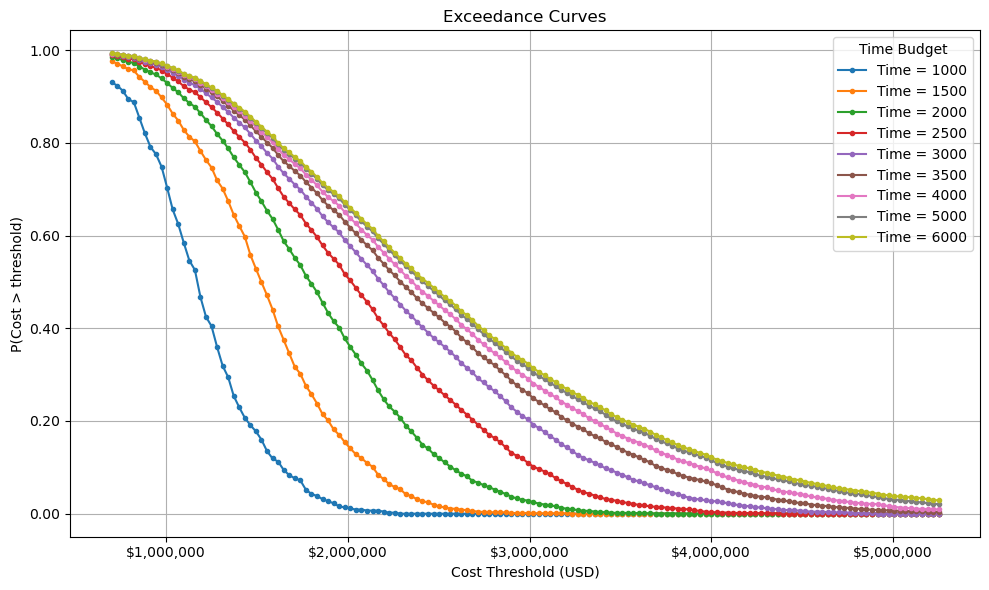

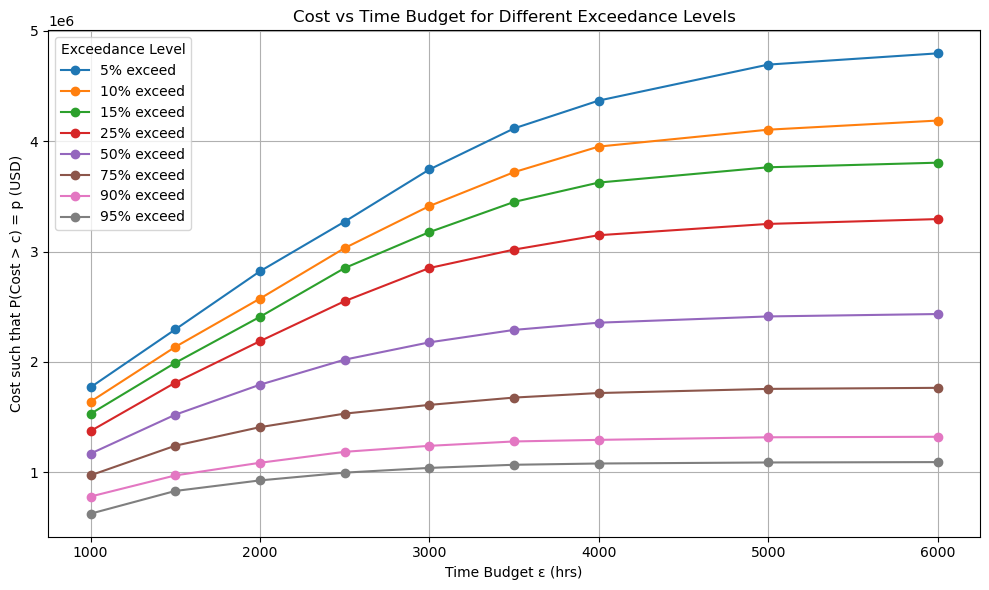

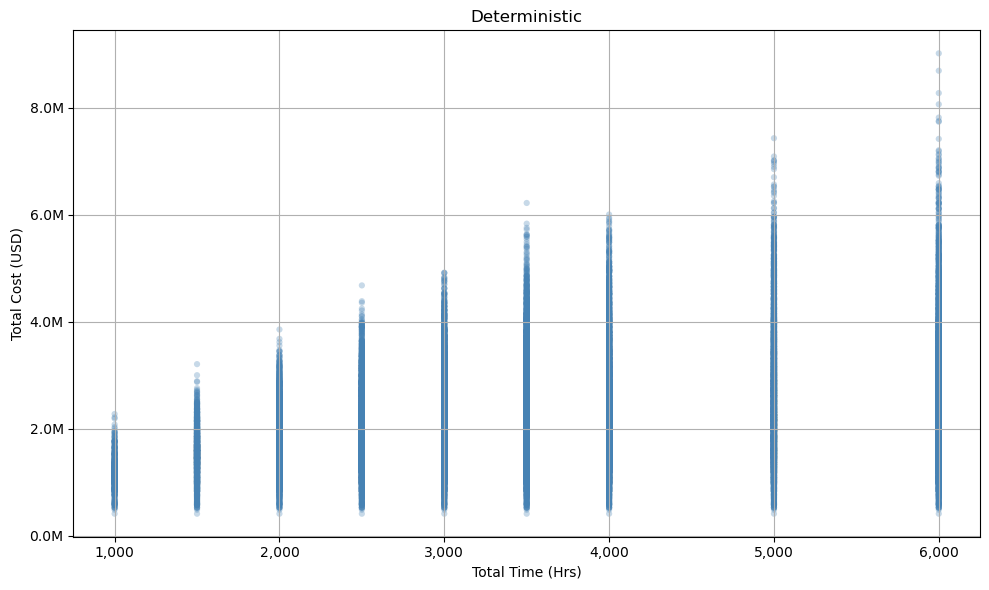

In [169]:
# ===============================================================
# Monte Carlo using economies-of-scale PWL cost curves
# ===============================================================

import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mt

# ----------------------------
# 0) Base data
# ----------------------------
machines = ['AM_hWAAM', 'AM_Binder', 'AM_slm', 'AM_PBF', 'TM_Casting']
parts    = ['part_1','part_2']

batch_size = {
    ('AM_hWAAM','part_1'):6, ('AM_hWAAM','part_2'):6,
    ('AM_Binder','part_1'):8,('AM_Binder','part_2'):8,
    ('AM_slm','part_1'):5,    ('AM_slm','part_2'):5,
    ('AM_PBF','part_1'):5,    ('AM_PBF','part_2'):5,
    ('TM_Casting','part_1'):1,('TM_Casting','part_2'):1,
}
base_time = {
    ('AM_hWAAM','part_1'):9.30,  ('AM_hWAAM','part_2'):9.30,
    ('AM_Binder','part_1'):8.74, ('AM_Binder','part_2'):7.74,
    ('AM_slm','part_1'):14.77,   ('AM_slm','part_2'):13.77,
    ('AM_PBF','part_1'):22.86,   ('AM_PBF','part_2'):21.86,
    ('TM_Casting','part_1'):4.5, ('TM_Casting','part_2'):24,
}
base_setup = {
    'AM_hWAAM':380000, 'AM_Binder':350000,'AM_slm':400000,
    'AM_PBF':500000,   'TM_Casting':430000
}
cap_hours = {'AM_hWAAM':440,'AM_Binder':460,'AM_slm':460,
             'AM_PBF':450,'TM_Casting':460}

# same x-breakpoints for all machines
pwl_breakpoints = {m:[0,25,50,100,200,400,800,1200,2200] for m in machines}

#pwl_breakpoints = { m: [0, 10, 20, 40, 80, 160, 320, 640, 1280] for m in machines}


FIXED_PWL_COSTVALS = {
    'AM_hWAAM': [
        0,
        25*1000,
        25*1000 + 25*950,
        25*1000 + 25*950 + 50*903,
        25*1000 + 25*950 + 50*903 + 100*879,
        25*1000 + 25*950 + 50*903 + 100*879 + 200*855,
        25*1000 + 25*950 + 50*903 + 100*879 + 200*855 + 400*831,
        25*1000 + 25*950 + 50*903 + 100*879 + 200*855 + 400*831 + 400*808,
        25*1000 + 25*950 + 50*903 + 100*879 + 200*855 + 400*831 + 400*808 + 1000*784
    ],
    'AM_Binder': [
        0,
        25*626,
        25*626 + 25*594,
        25*626 + 25*594 + 50*566,
        25*626 + 25*594 + 50*566 + 100*526,
        25*626 + 25*594 + 50*566 + 100*526 + 200*522,
        25*626 + 25*594 + 50*566 + 100*526 + 200*522 + 400*508,
        25*626 + 25*594 + 50*566 + 100*526 + 200*522 + 400*508 + 400*496,
        25*626 + 25*594 + 50*566 + 100*526 + 200*522 + 400*508 + 400*496 + 1000*506
    ],
    'AM_slm': [
        0,
        25*790,
        25*790 + 25*750,
        25*790 + 25*750 + 50*710,
        25*790 + 25*750 + 50*710 + 100*693,
        25*790 + 25*750 + 50*710 + 100*693 + 200*659,
        25*790 + 25*750 + 50*710 + 100*693 + 200*659 + 400*640,
        25*790 + 25*750 + 50*710 + 100*693 + 200*659 + 400*640 + 400*623,
        25*790 + 25*750 + 50*710 + 100*693 + 200*659 + 400*640 + 400*623 + 1000*603
    ],
    'AM_PBF': [
        0,
        25*960,
        25*960 + 25*912,
        25*960 + 25*912 + 50*922,
        25*960 + 25*912 + 50*922 + 100*902,
        25*960 + 25*912 + 50*922 + 100*902 + 200*814,
        25*960 + 25*912 + 50*922 + 100*902 + 200*814 + 400*796,
        25*960 + 25*912 + 50*922 + 100*902 + 200*814 + 400*796 + 400*774,
        25*960 + 25*912 + 50*922 + 100*902 + 200*814 + 400*796 + 400*774 + 1000*756
    ],
    'TM_Casting': [
        0,
        25*2500,
        25*2500 + 25*2375,
        25*2500 + 25*2375 + 50*1583,
        25*2500 + 25*2375 + 50*1583 + 100*1188,
        25*2500 + 25*2375 + 50*1583 + 100*1188 + 200*991,
        25*2500 + 25*2375 + 50*1583 + 100*1188 + 200*991 + 400*792,
        25*2500 + 25*2375 + 50*1583 + 100*1188 + 200*991 + 400*792 + 400*595,
        25*2500 + 25*2375 + 50*1583 + 100*1188 + 200*991 + 400*792 + 400*595 + 1000*396
    ]
}

# budget cap
B = 1e7

# --------------------------------------------
# 1) Uncertainty (simple, same as before)
# --------------------------------------------
r, mean = 5, 500
p = r/(r+mean)

def sample_trunc_normal(mu, sigma, low):
    v = np.random.normal(mu, sigma)
    return max(v, low)

# -------------------------------------------------------
# 2) Build ONE scenario (ω): D, times, setups, PWL costs
# -------------------------------------------------------
def sample_one_scenario():
    # demand draw
    D = np.random.negative_binomial(r, p)

    # setup costs (20% sd)
    setup_cost = {m: sample_trunc_normal(base_setup[m], 0.20*base_setup[m], 1)
                  for m in machines}

    # process times (15% sd)
    samp_time = {k: sample_trunc_normal(t, 0.15*t, 0.1)
                 for k, t in base_time.items()}

    # economies-of-scale cumulative cost curves
    samp_costvals = {m: FIXED_PWL_COSTVALS[m][:] for m in machines}

    return {
        'Demand': D,
        'setup_cost': setup_cost,
        'samp_time': samp_time,
        'samp_costvals': samp_costvals
    }

# ---------------------------------------------
# 3) Solve the model for a given (ω, ε)
# ---------------------------------------------
def solve_model_for(scn, epsilon):
    D = scn['Demand']
    setup_cost = scn['setup_cost']
    samp_time  = scn['samp_time']
    samp_costvals = scn['samp_costvals']

    model = gp.Model()
    model.Params.OutputFlag = 0

    x   = model.addVars(machines, parts, vtype=GRB.INTEGER, name='x')
    n   = model.addVars(machines, vtype=GRB.INTEGER, lb=0, name='n')
    vol = model.addVars(machines, vtype=GRB.CONTINUOUS, name='vol')
    vc  = model.addVars(machines, vtype=GRB.CONTINUOUS, name='vc')

    T = gp.quicksum(x[i,j]*batch_size[i,j]*samp_time[(i,j)]
                    for i in machines for j in parts)
    C = gp.quicksum(setup_cost[i]*n[i] + vc[i] for i in machines)

    # Objective: production cost + big penalty for time overage
    model.setObjective(C, GRB.MINIMIZE)

    model.addConstr(C <= B)
    model.addConstr(T <= epsilon)
    model.addConstr(gp.quicksum(x[i,j]*batch_size[i,j]
                                for i in machines for j in parts) >= D)

    for m in machines:
        model.addConstr(vol[m] == gp.quicksum(x[m,j]*batch_size[(m,j)] for j in parts))
        model.addConstr(
            gp.quicksum(x[m,j]*batch_size[(m,j)]*samp_time[(m,j)] for j in parts)
            <= cap_hours[m]*n[m]
        )
        model.addGenConstrPWL(vol[m], vc[m], pwl_breakpoints[m], samp_costvals[m])

    model.optimize()

    if model.status == GRB.OPTIMAL:
        volumes = {m: float(vol[m].X) for m in machines}
        copies  = {m: int(round(n[m].X)) for m in machines}
        return {
            'Cost': float(C.getValue()),
            'Time': float(T.getValue()), 
            'status': 'OPTIMAL',
            'volumes': volumes,
            'copies': copies
        }
    else:
        return {'Cost': np.nan, 'Time': np.nan,
                'status': str(model.status),
                'volumes': {m: 0.0 for m in machines},
                'copies':  {m: 0 for m in machines}}

# -----------------------
# 4) Monte Carlo
# -----------------------
S = 5000  # number of scenarios
epsilons = [1000, 1500, 2000, 2500 ,3000, 3500, 4000, 5000,6000]

records = []
for s in range(S):
    scn = sample_one_scenario()           # sample ω once
    for eps in epsilons:                  # reuse ω across ε (common random numbers)
        sol = solve_model_for(scn, eps)
        rec = {
            'scenario': s,
            'Epsilon': eps,
            'Demand': scn['Demand'],
            'Cost': sol['Cost'],
            #'CostWithPenalty': sol['CostWithPenalty'],
            'Time': sol['Time'],
            #'TimeSlack': sol['TimeSlack'],
            'Status': sol['status']
        }
        # add per-machine volumes and copies
        for m in machines:
            rec[f'vol_{m}'] = sol['volumes'].get(m, 0.0)
            rec[f'n_{m}']   = sol['copies'].get(m, 0)
        records.append(rec)


# =========================
# DIAGNOSTICS
# =========================

# --- Build dataframes & feasibility report ---
df_raw = pd.DataFrame(records)          # all runs, incl. infeasible
n_total = len(df_raw)
n_opt   = (df_raw['Status'] == 'OPTIMAL').sum()
n_infeas = n_total - n_opt

print("\n=== FEASIBILITY REPORT ===")
print(f"Total runs: {n_total}")
print(f"Optimal solutions: {n_opt}")
print(f"Infeasible runs: {n_infeas} ({n_infeas/n_total:.1%})")

# Keep OPTIMAL runs for analysis
df_crn = df_raw[df_raw['Status'] == 'OPTIMAL'].copy()
df_all = df_crn.copy()

# A) Segment usage per machine (at the largest epsilon)
eps_check = df_all['Epsilon'].max()
df_maxeps = df_all[df_all['Epsilon'] == eps_check].copy()

breaks = pwl_breakpoints[machines[0]]  # same for all machines

def segment_index(v, bps):
    # returns 0 for (0,25], 1 for (25,50], ... 7 for (1200,2200];  -1 for 0
    if v <= 0:
        return -1
    for k in range(len(bps)-1):
        if v <= bps[k+1]:
            return k
    return len(bps)-2

print("\n=== SEGMENT USAGE AT LARGEST EPSILON ===")
for m in machines:
    segs = df_maxeps[f'vol_{m}'].apply(lambda v: segment_index(v, breaks))
    counts = segs.value_counts().sort_index()
    total = counts.sum()
    pct_early = counts.get(0,0) + counts.get(1,0)  # segments 0-1
    print(f"{m:12s}  total={total:5d} | seg0-1={pct_early:5d} "
          f"({pct_early/max(1,total):.1%})  full dist={dict(counts)}")

# B) Volume shares: Casting vs AM, by epsilon
def vol_am(row):
    return sum(row[f'vol_{m}'] for m in machines if m != 'TM_Casting')
def vol_tm(row):
    return row['vol_TM_Casting'] if 'vol_TM_Casting' in row else row.get('vol_TM_Casting', 0.0)

df_all['vol_AM'] = df_all[[f'vol_{m}' for m in machines if m != 'TM_Casting']].sum(axis=1)
df_all['vol_TM'] = df_all['vol_TM_Casting'] if 'vol_TM_Casting' in df_all.columns else 0.0
df_all['vol_total'] = df_all['vol_AM'] + df_all['vol_TM']
df_all['share_TM']  = (df_all['vol_TM'] / df_all['vol_total']).replace([np.inf, -np.inf], 0.0).fillna(0.0)

print("\n=== AVERAGE CASTING SHARE BY EPSILON ===")
share_by_eps = df_all.groupby('Epsilon')['share_TM'].mean()
for eps, sh in share_by_eps.items():
    print(f"ε={eps:5d}  average Casting share = {sh:.2%}")

# C) Cost per unit vs epsilon (medians)
df_all['cpu'] = df_all['Cost'] / df_all['Demand']
cpu_med = df_all.groupby('Epsilon')['cpu'].median()
print("\n=== MEDIAN COST PER UNIT BY EPSILON ===")
for eps, v in cpu_med.items():
    print(f"ε={eps:5d}  median CPU = ${v:,.0f}")

# D) Average number of copies opened (setup effect)
print("\n=== AVERAGE COPIES OPENED BY EPSILON ===")
copy_cols = [f'n_{m}' for m in machines]
avg_copies = df_all.groupby('Epsilon')[copy_cols].mean()
print(avg_copies.round(2))

#=======================================================================
# Common-scenario filter across all eps
#=======================================================================

eps_list = sorted(df_crn['Epsilon'].unique())

# 1) scenarios that are optimal for every epsilon
ok_scenarios = (
    df_crn.groupby('scenario')['Epsilon']
          .nunique()
          .loc[lambda s: s == len(eps_list)]
          .index
)

df_common = df_crn[df_crn['scenario'].isin(ok_scenarios)].copy()

print(f"Scenarios in common across all eps: {df_common['scenario'].nunique()} "
      f"out of total {df_crn['scenario'].nunique()}")

# 2) Quantile-vs-time on the common set ONLY
exceed_levels = [0.05, 0.10, 0.15, 0.25, 0.50, 0.75, 0.9, 0.95]
exceed_data = {p: [] for p in exceed_levels}

for eps, grp in df_common.groupby("Epsilon"):
    costs = np.sort(grp["Cost"].to_numpy(float))
    if len(costs) == 0: 
        continue
    for p in exceed_levels:
        c_p = np.quantile(costs, 1 - p)  # (1-p) quantile
        exceed_data[p].append((eps, c_p))
# ===========================================================
# 5A) Plot 1: Exceedance curves (P(Cost > c) vs cost), all ε
# ===========================================================
selected = df_crn.copy()

all_costs = selected["Cost"].to_numpy(float)
p01 = float(np.percentile(all_costs, 1))
p99 = float(np.percentile(all_costs, 99))
x_thresholds = np.linspace(p01, p99, 150)

def fmt_prob(y, _): return f"{y:.2f}"
def fmt_dollar(x, _): return f"${x:,.0f}"

plt.figure(figsize=(10,6))
for eps in epsilons:
    costs_eps = selected[selected["Epsilon"] == eps]["Cost"].to_numpy(float)
    if len(costs_eps) == 0:
        continue
    probs = []
    N = len(costs_eps)
    for c in x_thresholds:
        probs.append((costs_eps > c).sum() / N)
    plt.plot(x_thresholds, probs, marker='o', ms=3, label=f"Time = {eps}")

plt.xlabel("Cost Threshold (USD)")
plt.ylabel("P(Cost > threshold)")
plt.title("Exceedance Curves")
plt.grid(True)
plt.legend(title="Time Budget")
plt.gca().yaxis.set_major_formatter(mt.FuncFormatter(fmt_prob))
plt.gca().xaxis.set_major_formatter(mt.FuncFormatter(fmt_dollar))
plt.tight_layout()
plt.show()

# ===================================================================
# 5B) Plot 2: Cost vs Time at fixed exceedance levels (group by ε)
# ===================================================================
exceed_levels = [0.05, 0.10, 0.15, 0.25, 0.50, 0.75, 0.9, 0.95]  # 5%, 10%, 15%, 25%, 50%
exceed_data = {p: [] for p in exceed_levels}

for eps, grp in df_crn.groupby("Epsilon"):
    costs = np.sort(grp["Cost"].to_numpy(float))
    if len(costs) == 0:
        continue
    for p_ex in exceed_levels:
        # c_p such that P(Cost > c_p) = p_ex  => (1 - p_ex) quantile
        c_p = np.quantile(costs, 1 - p_ex)  # drop 'method=' for broader NumPy compat
        exceed_data[p_ex].append((eps, c_p))

plt.figure(figsize=(10,6))
for p_ex in exceed_levels:
    pts = sorted(exceed_data[p_ex], key=lambda x: x[0])
    if not pts:
        continue
    xs = [t for t,_ in pts]
    ys = [c for _,c in pts]
    plt.plot(xs, ys, marker='o', linestyle='-', label=f"{int(p_ex*100)}% exceed")

plt.xlabel("Time Budget ε (hrs)")
plt.ylabel("Cost such that P(Cost > c) = p (USD)")
plt.title("Cost vs Time Budget for Different Exceedance Levels")
plt.grid(True)
plt.legend(title="Exceedance Level")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df_crn['Epsilon'], df_crn['Cost'],
           c='steelblue', alpha=0.3, s=20, edgecolor='none')
ax.set_xlabel("Total Time (Hrs)")
ax.set_ylabel("Total Cost (USD)")
ax.set_title("Deterministic")
ax.grid(True)
ax.xaxis.set_major_formatter(mt.FuncFormatter(lambda x,_:f"{int(x):,}"))
ax.yaxis.set_major_formatter(mt.FuncFormatter(lambda y,_:f"{y/1e6:.1f}M"))
plt.tight_layout()
plt.show()


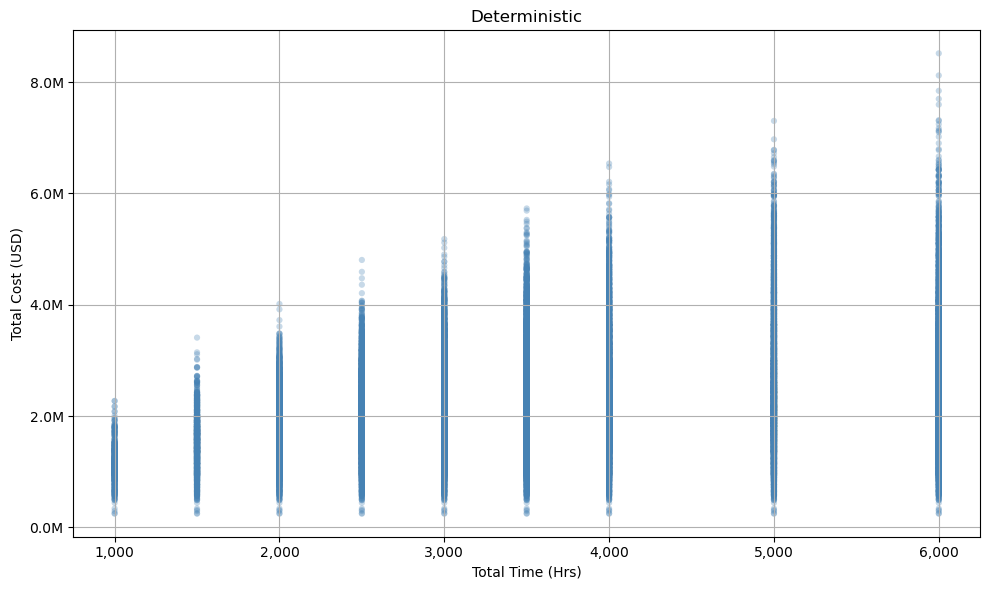

'fig, ax = plt.subplots(figsize=(10,6))\n\n# Blue: no slack (normal feasible runs)\nax.scatter(df_crn.loc[df_crn["TimeSlack"]==0, "Epsilon"],\n           df_crn.loc[df_crn["TimeSlack"]==0, "CostWithPenalty"],\n           c="steelblue", alpha=0.4, s=20, label="No Slack")\n\n# Red: slack used (penalty applied)\nax.scatter(df_crn.loc[df_crn["TimeSlack"]>0, "Epsilon"],\n           df_crn.loc[df_crn["TimeSlack"]>0, "CostWithPenalty"],\n           c="crimson", alpha=0.7, s=20, label="Slack Used")\n\nax.set_xlabel("Time Budget ε (hrs)")\nax.set_ylabel("Total Cost (USD)")\nax.set_title("Scatter of Runs (Slack vs No Slack)")\nax.grid(True)\nax.legend()\nax.xaxis.set_major_formatter(mt.FuncFormatter(lambda x,_:f"{int(x):,}"))\nax.yaxis.set_major_formatter(mt.FuncFormatter(lambda y,_:f"{y/1e6:.1f}M"))\nplt.tight_layout()\nplt.show()'

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df_crn['Epsilon'], df_crn['Cost'],
           c='steelblue', alpha=0.3, s=20, edgecolor='none')
ax.set_xlabel("Total Time (Hrs)")
ax.set_ylabel("Total Cost (USD)")
ax.set_title("Deterministic")
ax.grid(True)
ax.xaxis.set_major_formatter(mt.FuncFormatter(lambda x,_:f"{int(x):,}"))
ax.yaxis.set_major_formatter(mt.FuncFormatter(lambda y,_:f"{y/1e6:.1f}M"))
plt.tight_layout()
plt.show()



## Only Common Scenarios

Common scenarios: 445 out of 4982 feasible scenarios total
Counts per ε in df_common (should all match):
Epsilon
1000    445
1500    445
2000    445
2500    445
3000    445
3500    445
4000    445
5000    445
6000    445
Name: scenario, dtype: int64


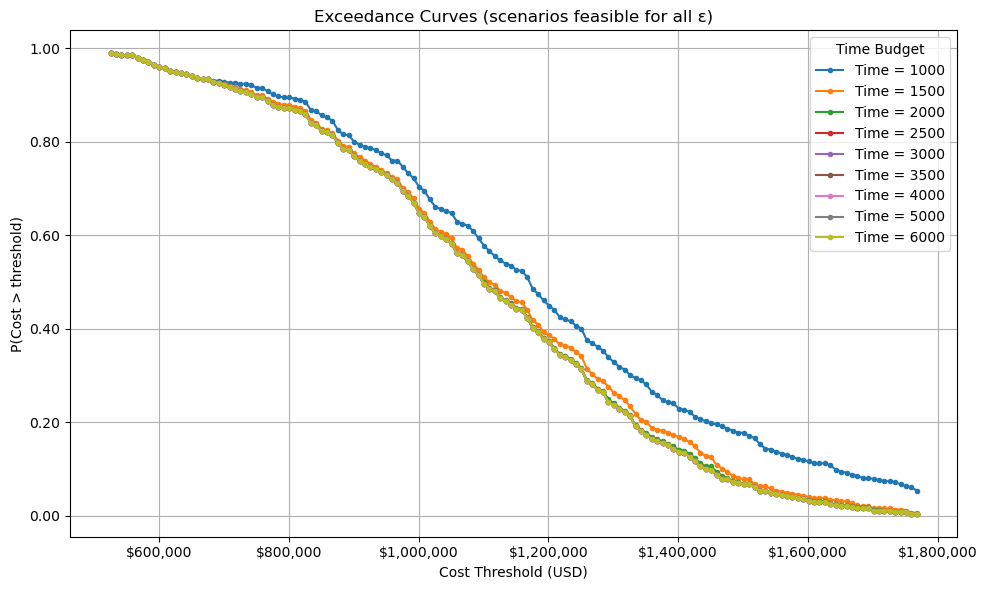

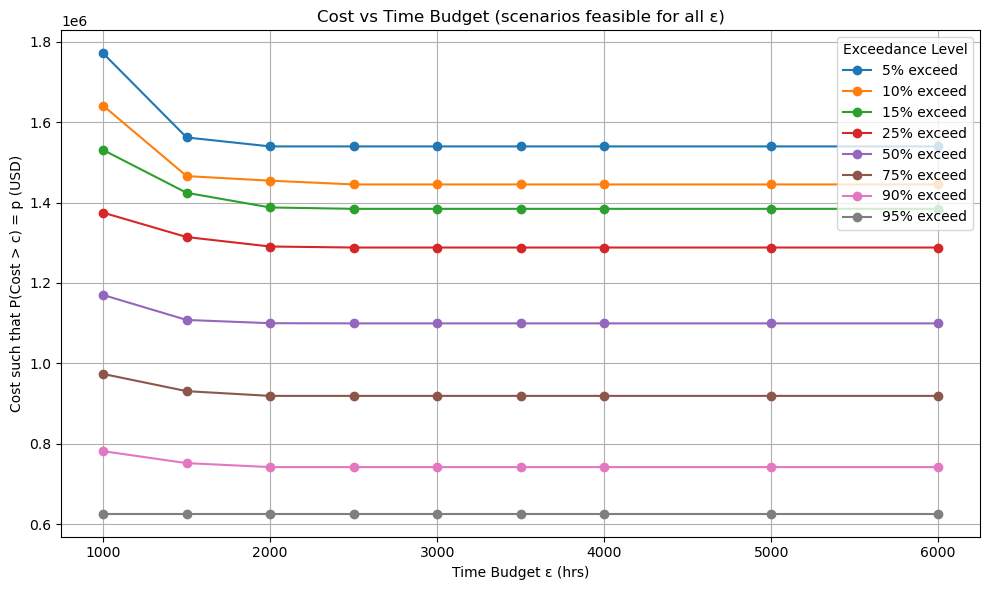

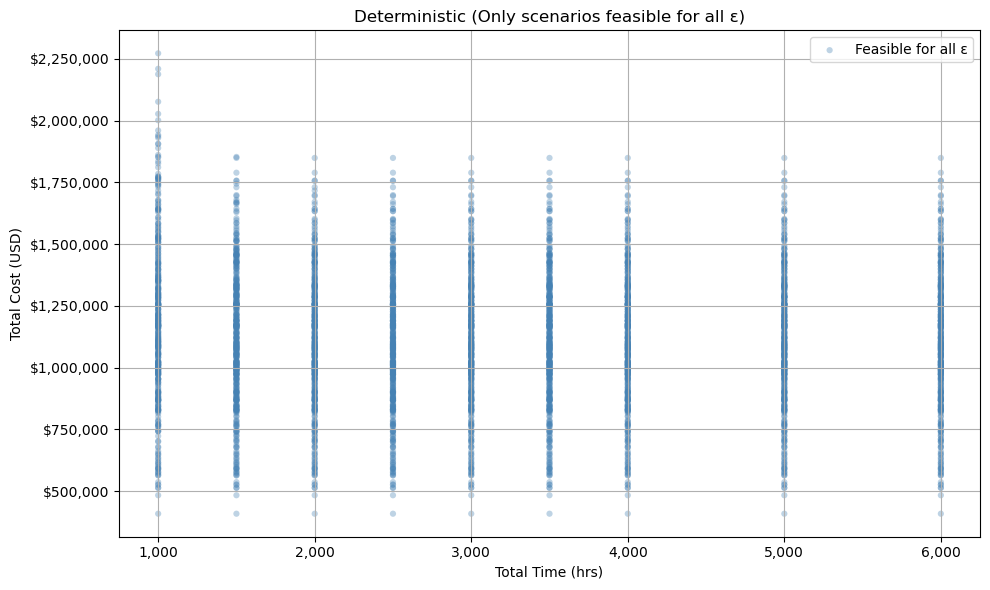

In [171]:
# ============================================
# Use only scenarios feasible for *all* epsilons
# (hard time model: no slack, no big-M penalty)
# ============================================

# 1) Find “common” scenarios (appear once at every epsilon in df_crn)
eps_list = sorted(df_crn['Epsilon'].unique())
ok_scenarios = (
    df_crn.groupby('scenario')['Epsilon']
          .nunique()
          .loc[lambda s: s == len(eps_list)]
          .index
)

df_common = df_crn[df_crn['scenario'].isin(ok_scenarios)].copy()

print(f"Common scenarios: {df_common['scenario'].nunique()} "
      f"out of {df_crn['scenario'].nunique()} feasible scenarios total")

# sanity check: same scenario count at each epsilon in df_common
print("Counts per ε in df_common (should all match):")
print(df_common.groupby('Epsilon')['scenario'].nunique())

# ============================================
# A) Exceedance curves on df_common
# ============================================
selected = df_common.copy()

all_costs = selected["Cost"].to_numpy(float)
p01 = float(np.percentile(all_costs, 1))
p99 = float(np.percentile(all_costs, 99))
x_thresholds = np.linspace(p01, p99, 150)

def fmt_prob(y, _): return f"{y:.2f}"
def fmt_dollar(x, _): return f"${x:,.0f}"

plt.figure(figsize=(10,6))
for eps in epsilons:
    costs_eps = selected.loc[selected["Epsilon"] == eps, "Cost"].to_numpy(float)
    if costs_eps.size == 0:
        continue
    N = len(costs_eps)
    probs = [(costs_eps > c).sum() / N for c in x_thresholds]
    plt.plot(x_thresholds, probs, marker='o', ms=3, label=f"Time = {eps}")

plt.xlabel("Cost Threshold (USD)")
plt.ylabel("P(Cost > threshold)")
plt.title("Exceedance Curves (scenarios feasible for all ε)")
plt.grid(True)
plt.legend(title="Time Budget")
plt.gca().yaxis.set_major_formatter(mt.FuncFormatter(fmt_prob))
plt.gca().xaxis.set_major_formatter(mt.FuncFormatter(fmt_dollar))
plt.tight_layout()
plt.show()

# ============================================
# B) Cost vs Time at fixed exceedance levels (df_common)
# ============================================
exceed_levels = [0.05, 0.10, 0.15, 0.25, 0.50, 0.75, 0.90, 0.95]
exceed_data = {p: [] for p in exceed_levels}

for eps, grp in df_common.groupby("Epsilon"):
    costs = np.sort(grp["Cost"].to_numpy(float))
    if costs.size == 0:
        continue
    for p_ex in exceed_levels:
        c_p = np.quantile(costs, 1 - p_ex)
        exceed_data[p_ex].append((eps, c_p))

plt.figure(figsize=(10,6))
for p_ex in exceed_levels:
    pts = sorted(exceed_data[p_ex], key=lambda x: x[0])
    if not pts:
        continue
    xs = [t for t,_ in pts]
    ys = [c for _,c in pts]
    plt.plot(xs, ys, marker='o', linestyle='-', label=f"{int(p_ex*100)}% exceed")

plt.xlabel("Time Budget ε (hrs)")
plt.ylabel("Cost such that P(Cost > c) = p (USD)")
plt.title("Cost vs Time Budget (scenarios feasible for all ε)")
plt.grid(True)
plt.legend(title="Exceedance Level")
plt.tight_layout()
plt.show()

# ============================================
# C) Scatter: Cost vs ε (df_common only)
# ============================================
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df_common['Epsilon'], df_common['Cost'],
           c='steelblue', alpha=0.35, s=20, edgecolor='none', label="Feasible for all ε")
ax.set_xlabel("Total Time (hrs)")
ax.set_ylabel("Total Cost (USD)")
ax.set_title("Deterministic (Only scenarios feasible for all ε)")
ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mt.FuncFormatter(lambda x,_: f"{int(x):,}"))
ax.yaxis.set_major_formatter(mt.FuncFormatter(lambda y,_: f"${y:,.0f}"))
plt.tight_layout()
plt.show()

## With Big- M Penalty

In [207]:
# ===============================================================
# Monte Carlo using economies-of-scale PWL cost curves
# ===============================================================

import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mt

# ----------------------------
# 0) Base data
# ----------------------------
machines = ['AM_hWAAM', 'AM_Binder', 'AM_slm', 'AM_PBF', 'TM_Casting']
parts    = ['part_1','part_2']

batch_size = {
    ('AM_hWAAM','part_1'):6, ('AM_hWAAM','part_2'):6,
    ('AM_Binder','part_1'):8,('AM_Binder','part_2'):8,
    ('AM_slm','part_1'):5,    ('AM_slm','part_2'):5,
    ('AM_PBF','part_1'):5,    ('AM_PBF','part_2'):5,
    ('TM_Casting','part_1'):1,('TM_Casting','part_2'):1,
}
base_time = {
    ('AM_hWAAM','part_1'):9.30,  ('AM_hWAAM','part_2'):9.30,
    ('AM_Binder','part_1'):8.74, ('AM_Binder','part_2'):7.74,
    ('AM_slm','part_1'):14.77,   ('AM_slm','part_2'):13.77,
    ('AM_PBF','part_1'):22.86,   ('AM_PBF','part_2'):21.86,
    ('TM_Casting','part_1'):4.5, ('TM_Casting','part_2'):24,
}
base_setup = {
    'AM_hWAAM':380000, 'AM_Binder':350000,'AM_slm':400000,
    'AM_PBF':500000,   'TM_Casting':430000
}
cap_hours = {'AM_hWAAM':440,'AM_Binder':460,'AM_slm':460,
             'AM_PBF':450,'TM_Casting':460}

# same x-breakpoints for all machines
pwl_breakpoints = {m:[0,25,50,100,200,400,800,1200,2200] for m in machines}

#pwl_breakpoints = { m: [0, 10, 20, 40, 80, 160, 320, 640, 1280] for m in machines}


FIXED_PWL_COSTVALS = {
    'AM_hWAAM': [
        0,
        25*1000,
        25*1000 + 25*950,
        25*1000 + 25*950 + 50*903,
        25*1000 + 25*950 + 50*903 + 100*879,
        25*1000 + 25*950 + 50*903 + 100*879 + 200*855,
        25*1000 + 25*950 + 50*903 + 100*879 + 200*855 + 400*831,
        25*1000 + 25*950 + 50*903 + 100*879 + 200*855 + 400*831 + 400*808,
        25*1000 + 25*950 + 50*903 + 100*879 + 200*855 + 400*831 + 400*808 + 1000*784
    ],
    'AM_Binder': [
        0,
        25*626,
        25*626 + 25*594,
        25*626 + 25*594 + 50*566,
        25*626 + 25*594 + 50*566 + 100*526,
        25*626 + 25*594 + 50*566 + 100*526 + 200*522,
        25*626 + 25*594 + 50*566 + 100*526 + 200*522 + 400*508,
        25*626 + 25*594 + 50*566 + 100*526 + 200*522 + 400*508 + 400*496,
        25*626 + 25*594 + 50*566 + 100*526 + 200*522 + 400*508 + 400*496 + 1000*506
    ],
    'AM_slm': [
        0,
        25*790,
        25*790 + 25*750,
        25*790 + 25*750 + 50*710,
        25*790 + 25*750 + 50*710 + 100*693,
        25*790 + 25*750 + 50*710 + 100*693 + 200*659,
        25*790 + 25*750 + 50*710 + 100*693 + 200*659 + 400*640,
        25*790 + 25*750 + 50*710 + 100*693 + 200*659 + 400*640 + 400*623,
        25*790 + 25*750 + 50*710 + 100*693 + 200*659 + 400*640 + 400*623 + 1000*603
    ],
    'AM_PBF': [
        0,
        25*960,
        25*960 + 25*912,
        25*960 + 25*912 + 50*922,
        25*960 + 25*912 + 50*922 + 100*902,
        25*960 + 25*912 + 50*922 + 100*902 + 200*814,
        25*960 + 25*912 + 50*922 + 100*902 + 200*814 + 400*796,
        25*960 + 25*912 + 50*922 + 100*902 + 200*814 + 400*796 + 400*774,
        25*960 + 25*912 + 50*922 + 100*902 + 200*814 + 400*796 + 400*774 + 1000*756
    ],
    'TM_Casting': [
        0,
        25*2500,
        25*2500 + 25*2375,
        25*2500 + 25*2375 + 50*1583,
        25*2500 + 25*2375 + 50*1583 + 100*1188,
        25*2500 + 25*2375 + 50*1583 + 100*1188 + 200*991,
        25*2500 + 25*2375 + 50*1583 + 100*1188 + 200*991 + 400*792,
        25*2500 + 25*2375 + 50*1583 + 100*1188 + 200*991 + 400*792 + 400*595,
        25*2500 + 25*2375 + 50*1583 + 100*1188 + 200*991 + 400*792 + 400*595 + 1000*396
    ]
}

# budget cap
B = 10e8

# --------------------------------------------
# 1) Uncertainty (simple, same as before)
# --------------------------------------------
r, mean = 5, 500
p = r/(r+mean)

def sample_trunc_normal(mu, sigma, low):
    v = np.random.normal(mu, sigma)
    return max(v, low)

# -------------------------------------------------------
# 2) Build ONE scenario (ω): D, times, setups, PWL costs
# -------------------------------------------------------
def sample_one_scenario():
    # demand draw
    D = np.random.negative_binomial(r, p)

    # setup costs (20% sd)
    setup_cost = {m: sample_trunc_normal(base_setup[m], 0.20*base_setup[m], 1)
                  for m in machines}

    # process times (15% sd)
    samp_time = {k: sample_trunc_normal(t, 0.15*t, 0.1)
                 for k, t in base_time.items()}

    # economies-of-scale cumulative cost curves
    samp_costvals = {m: FIXED_PWL_COSTVALS[m][:] for m in machines}

    return {
        'Demand': D,
        'setup_cost': setup_cost,
        'samp_time': samp_time,
        'samp_costvals': samp_costvals
    }

# ---------------------------------------------
# 3) Solve the model for a given (ω, ε)
# ---------------------------------------------
def solve_model_for(scn, epsilon):
    D = scn['Demand']
    setup_cost = scn['setup_cost']
    samp_time  = scn['samp_time']
    samp_costvals = scn['samp_costvals']

    model = gp.Model()
    model.Params.OutputFlag = 0

    x   = model.addVars(machines, parts, vtype=GRB.INTEGER, name='x')
    n   = model.addVars(machines, vtype=GRB.INTEGER, lb=0, name='n')
    vol = model.addVars(machines, vtype=GRB.CONTINUOUS, name='vol')
    vc  = model.addVars(machines, vtype=GRB.CONTINUOUS, name='vc')

    T = gp.quicksum(x[i,j]*batch_size[i,j]*samp_time[(i,j)]
                    for i in machines for j in parts)
    C = gp.quicksum(setup_cost[i]*n[i] + vc[i] for i in machines)

    # >>> NEW: soft time slack (hours) with big penalty <<<
    s = model.addVar(lb=0.0, vtype=GRB.INTEGER, name='time_slack')  # hours over epsilon
    BIG_M = 10e7  # USD per hour

    # Objective: production cost + big penalty for time overage
    model.setObjective(C + BIG_M * s, GRB.MINIMIZE)

    model.addConstr(C <= B)
    model.addConstr(T <= epsilon + s)
    model.addConstr(gp.quicksum(x[i,j]*batch_size[i,j]
                                for i in machines for j in parts) >= D)

    for m in machines:
        model.addConstr(vol[m] == gp.quicksum(x[m,j]*batch_size[(m,j)] for j in parts))
        model.addConstr(
            gp.quicksum(x[m,j]*batch_size[(m,j)]*samp_time[(m,j)] for j in parts)
            <= cap_hours[m]*n[m]
        )
        model.addGenConstrPWL(vol[m], vc[m], pwl_breakpoints[m], samp_costvals[m])

    model.optimize()

    if model.status == GRB.OPTIMAL:
        volumes = {m: float(vol[m].X) for m in machines}
        copies  = {m: int(round(n[m].X)) for m in machines}
        return {
            'Cost': float(C.getValue()),
            'CostWithPenalty': float(C.getValue() + BIG_M * s.X),
            'Time': float(T.getValue()),
            'TimeSlack': float(s.X), 
            'status': 'OPTIMAL',
            'volumes': volumes,
            'copies': copies
        }
    else:
        return {'Cost': np.nan, 'CostWithPenalty': np.nan, 'Time': np.nan,
                'TimeSlack': np.nan, 'status': str(model.status),
                'volumes': {m: 0.0 for m in machines},
                'copies':  {m: 0 for m in machines}}

# -----------------------
# 4) Monte Carlo (CRN)
# -----------------------
S = 5000  # number of scenarios
epsilons = [1000, 1500, 2000, 2500 ,3000, 3500, 4000, 5000,6000]

records = []
for s in range(S):
    scn = sample_one_scenario()           # sample ω once
    for eps in epsilons:                  # reuse ω across ε (common random numbers)
        sol = solve_model_for(scn, eps)
        rec = {
            'scenario': s,
            'Epsilon': eps,
            'Demand': scn['Demand'],
            'Cost': sol['Cost'],
            'CostWithPenalty': sol['CostWithPenalty'],
            'Time': sol['Time'],
            'TimeSlack': sol['TimeSlack'],
            'Status': sol['status']
        }
        # add per-machine volumes and copies
        for m in machines:
            rec[f'vol_{m}'] = sol['volumes'].get(m, 0.0)
            rec[f'n_{m}']   = sol['copies'].get(m, 0)
        records.append(rec)


df_raw = pd.DataFrame(records)

# === FEASIBILITY REPORT (HARD TIME) ===
n_total = len(df_raw)
n_opt   = (df_raw['Status'] == 'OPTIMAL').sum()
n_infeas = n_total - n_opt
print("\n=== FEASIBILITY REPORT (HARD TIME) ===")
print(f"Total runs: {n_total}")
print(f"Optimal solutions: {n_opt}")
print(f"Infeasible runs: {n_infeas} ({n_infeas/n_total:.1%})")

# Now continue as before, working only with OPTIMAL runs
df_crn = df_raw[df_raw['Status'] == 'OPTIMAL'].copy()

# =========================
# DIAGNOSTICS
# =========================

df_all = df_crn.copy()

print(f"\n=== FEASIBILITY REPORT ===")
print(f"Total runs: {n_total}")
print(f"Optimal solutions: {n_opt}")
print(f"Infeasible runs: {n_infeas} ({n_infeas/n_total:.1%})")

# A) Segment usage per machine (at the largest epsilon)
eps_check = df_all['Epsilon'].max()
df_maxeps = df_all[df_all['Epsilon'] == eps_check].copy()

breaks = pwl_breakpoints[machines[0]]  # same for all machines

def segment_index(v, bps):
    # returns 0 for (0,25], 1 for (25,50], ... 7 for (1200,2200];  -1 for 0
    if v <= 0:
        return -1
    for k in range(len(bps)-1):
        if v <= bps[k+1]:
            return k
    return len(bps)-2

print("\n=== SEGMENT USAGE AT LARGEST EPSILON ===")
for m in machines:
    segs = df_maxeps[f'vol_{m}'].apply(lambda v: segment_index(v, breaks))
    counts = segs.value_counts().sort_index()
    total = counts.sum()
    pct_early = counts.get(0,0) + counts.get(1,0)  # segments 0-1
    print(f"{m:12s}  total={total:5d} | seg0-1={pct_early:5d} ({pct_early/max(1,total):.1%})  full dist={dict(counts)}")

# B) Volume shares: Casting vs AM, by epsilon
def vol_am(row):
    return sum(row[f'vol_{m}'] for m in machines if m != 'TM_Casting')
def vol_tm(row):
    return row['vol_TM_Casting'] if 'vol_TM_Casting' in row else row.get('vol_TM_Casting', row.get('vol_TM_Casting', 0.0))

# Build columns for convenience
df_all['vol_AM'] = df_all[[f'vol_{m}' for m in machines if m != 'TM_Casting']].sum(axis=1)
df_all['vol_TM'] = df_all['vol_TM_Casting'] if 'vol_TM_Casting' in df_all.columns else df_all.get('vol_TM_Casting', 0.0)
# If the above didn't create vol_TM because of column name quirks, do:
if 'vol_TM' not in df_all.columns:
    df_all['vol_TM'] = df_all['vol_TM_Casting'] if 'vol_TM_Casting' in df_all.columns else 0.0

df_all['vol_total'] = df_all['vol_AM'] + df_all['vol_TM']
df_all['share_TM']  = (df_all['vol_TM'] / df_all['vol_total']).replace([np.inf, -np.inf], 0.0).fillna(0.0)

print("\n=== AVERAGE CASTING SHARE BY EPSILON ===")
share_by_eps = df_all.groupby('Epsilon')['share_TM'].mean()
for eps, sh in share_by_eps.items():
    print(f"ε={eps:5d}  average Casting share = {sh:.2%}")

# C) Cost per unit vs epsilon (medians)
df_all['cpu'] = df_all['Cost'] / df_all['Demand']
cpu_med = df_all.groupby('Epsilon')['cpu'].median()
print("\n=== MEDIAN COST PER UNIT BY EPSILON ===")
for eps, v in cpu_med.items():
    print(f"ε={eps:5d}  median CPU = ${v:,.0f}")

# D) Average number of copies opened (setup effect)
print("\n=== AVERAGE COPIES OPENED BY EPSILON ===")
copy_cols = [f'n_{m}' for m in machines]
avg_copies = df_all.groupby('Epsilon')[copy_cols].mean()
print(avg_copies.round(2))

#=======================================================================

# After you build df_crn (already filtered to OPTIMAL), add this:

eps_list = sorted(df_crn['Epsilon'].unique())

# 1) scenarios that are optimal for every epsilon
ok_scenarios = (
    df_crn.groupby('scenario')['Epsilon']
          .nunique()
          .loc[lambda s: s == len(eps_list)]
          .index
)

df_common = df_crn[df_crn['scenario'].isin(ok_scenarios)].copy()

print(f"Scenarios in common across all eps: {df_common['scenario'].nunique()} "
      f"out of total {df_crn['scenario'].nunique()}")

# 2) Quantile-vs-time on the common set ONLY
exceed_levels = [0.05, 0.10, 0.15, 0.25, 0.50, 0.75, 0.9, 0.95]
exceed_data = {p: [] for p in exceed_levels}

for eps, grp in df_common.groupby("Epsilon"):
    costs = np.sort(grp["Cost"].to_numpy(float))
    if len(costs) == 0: 
        continue
    for p in exceed_levels:
        c_p = np.quantile(costs, 1 - p)  # (1-p) quantile
        exceed_data[p].append((eps, c_p))





=== FEASIBILITY REPORT (HARD TIME) ===
Total runs: 45000
Optimal solutions: 45000
Infeasible runs: 0 (0.0%)

=== FEASIBILITY REPORT ===
Total runs: 45000
Optimal solutions: 45000
Infeasible runs: 0 (0.0%)

=== SEGMENT USAGE AT LARGEST EPSILON ===
AM_hWAAM      total= 5000 | seg0-1=  317 (6.3%)  full dist={-1: 4236, 0: 83, 1: 234, 2: 114, 3: 106, 4: 121, 5: 101, 6: 5}
AM_Binder     total= 5000 | seg0-1=  189 (3.8%)  full dist={-1: 2594, 0: 5, 1: 184, 2: 450, 3: 342, 4: 632, 5: 740, 6: 53}
AM_slm        total= 5000 | seg0-1=  239 (4.8%)  full dist={-1: 4726, 0: 59, 1: 180, 2: 13, 3: 8, 4: 6, 5: 8}
AM_PBF        total= 5000 | seg0-1=   16 (0.3%)  full dist={-1: 4982, 0: 16, 2: 1, 4: 1}
TM_Casting    total= 5000 | seg0-1=    1 (0.0%)  full dist={-1: 1513, 0: 1, 2: 226, 3: 272, 4: 1062, 5: 1594, 6: 289, 7: 43}

=== AVERAGE CASTING SHARE BY EPSILON ===
ε= 1000  average Casting share = 97.40%
ε= 1500  average Casting share = 93.50%
ε= 2000  average Casting share = 87.05%
ε= 2500  average Cas

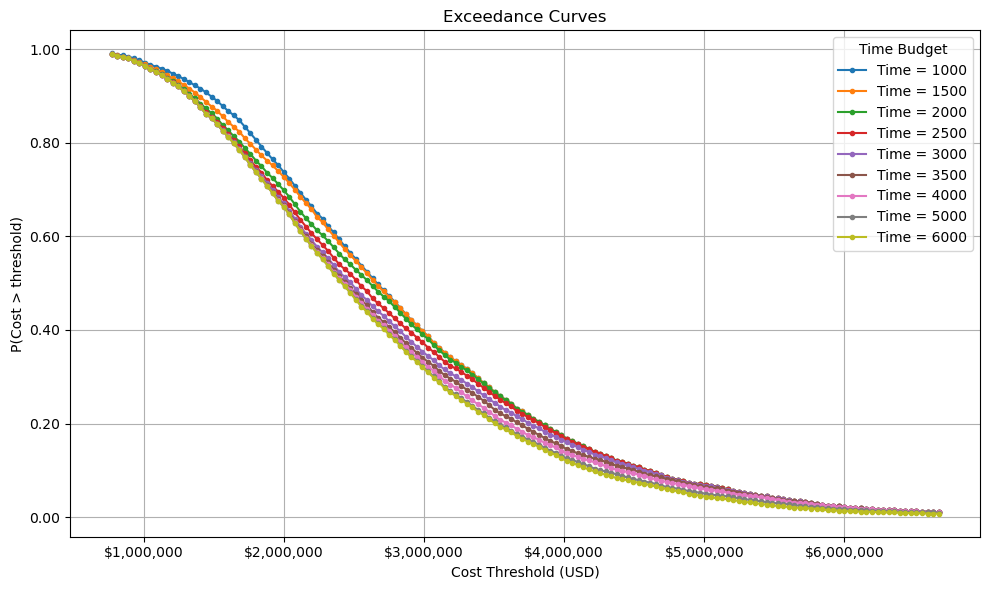

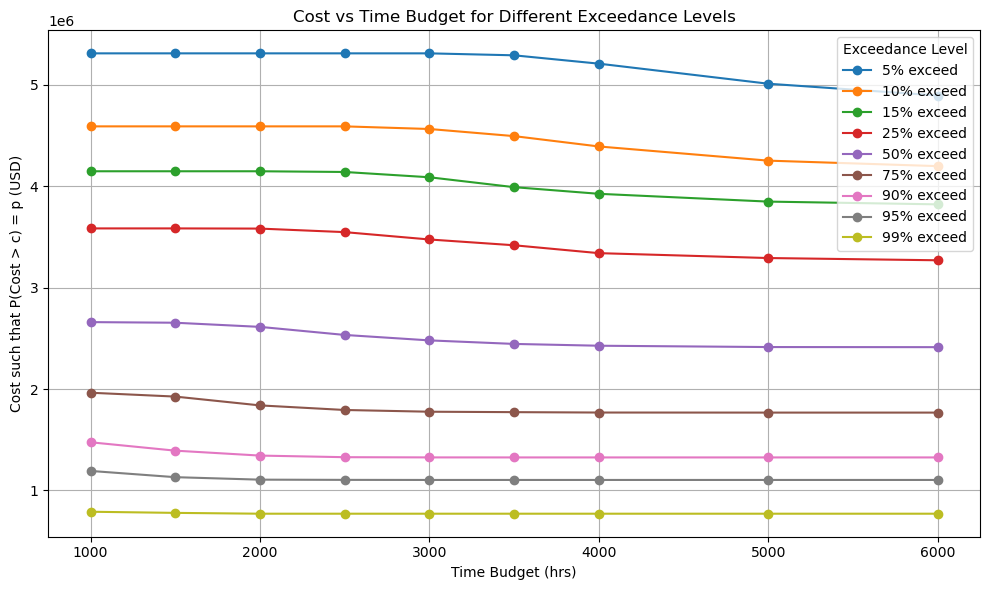

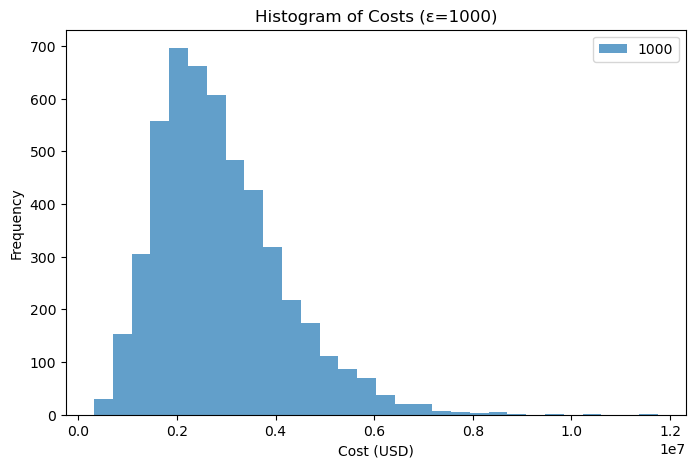

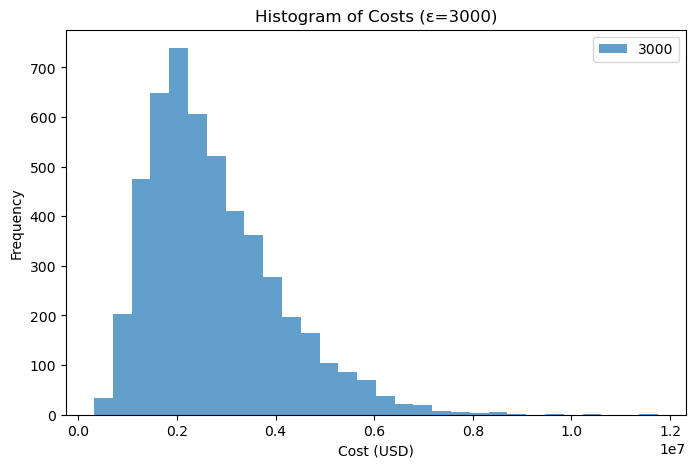

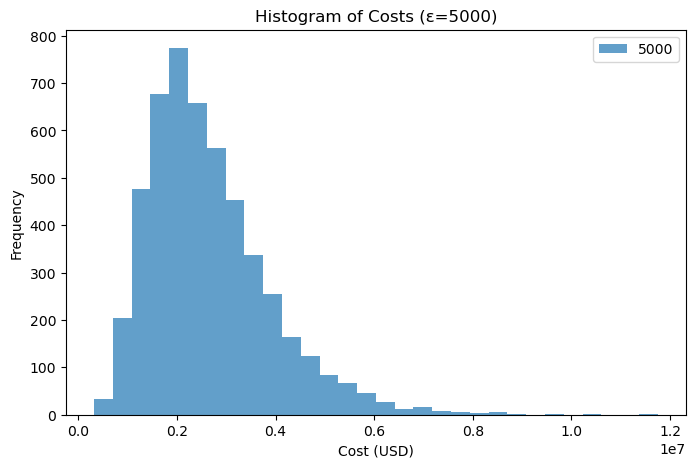

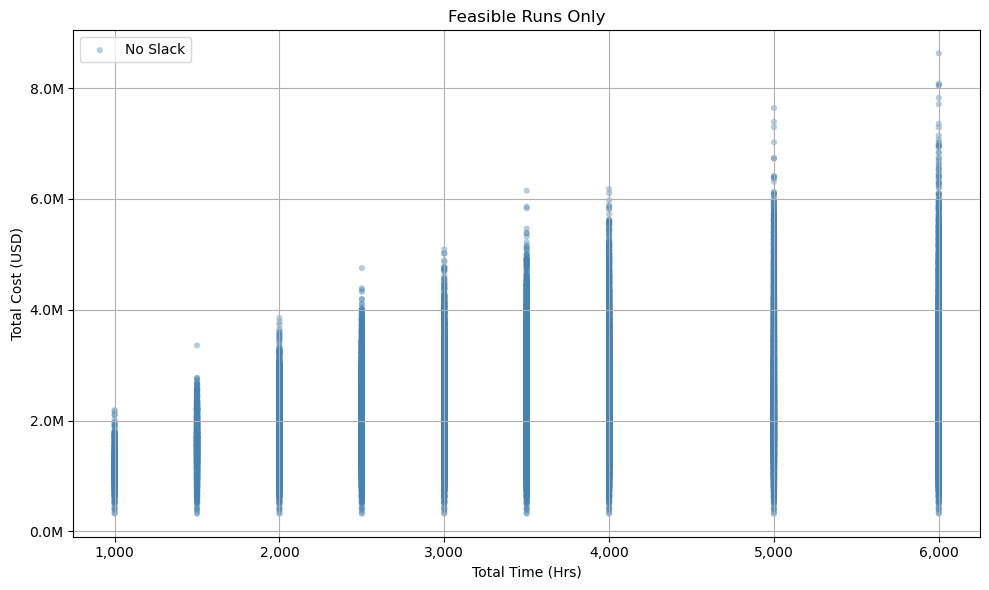

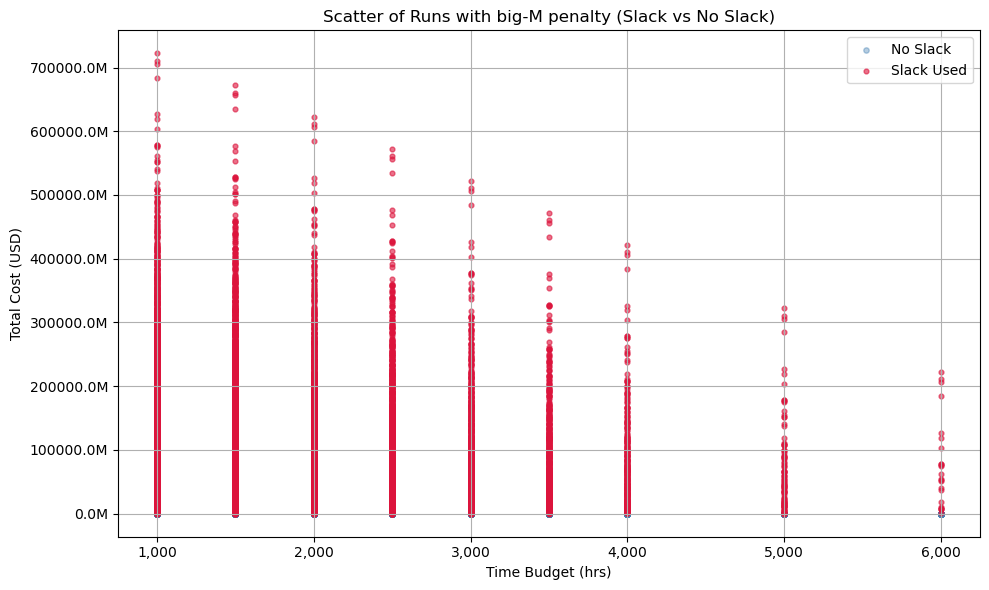


Unique scenarios per epsilon:
 Epsilon
1000    5000
1500    5000
2000    5000
2500    5000
3000    5000
3500    5000
4000    5000
5000    5000
6000    5000
Name: scenario, dtype: int64
1000 ⊆ 1500? -> True
1500 ⊆ 2000? -> True
2000 ⊆ 2500? -> True
2500 ⊆ 3000? -> True
3000 ⊆ 3500? -> True
3500 ⊆ 4000? -> True
4000 ⊆ 5000? -> True
5000 ⊆ 6000? -> True


In [209]:
# ===========================================================
# 5A) Plot 1: Exceedance curves (P(Cost > c) vs cost), all ε
# ===========================================================
selected = df_crn.copy()

all_costs = selected["Cost"].to_numpy(float)
p01 = float(np.percentile(all_costs, 1))
p99 = float(np.percentile(all_costs, 99))
x_thresholds = np.linspace(p01, p99, 150)

def fmt_prob(y, _): return f"{y:.2f}"
def fmt_dollar(x, _): return f"${x:,.0f}"

plt.figure(figsize=(10,6))
for eps in epsilons:
    costs_eps = selected[selected["Epsilon"] == eps]["Cost"].to_numpy(float)
    if len(costs_eps) == 0:
        continue
    probs = [(costs_eps > c).sum() / len(costs_eps) for c in x_thresholds]
    plt.plot(x_thresholds, probs, marker='o', ms=3, label=f"Time = {eps}")

plt.xlabel("Cost Threshold (USD)")
plt.ylabel("P(Cost > threshold)")
plt.title("Exceedance Curves")
plt.grid(True)
plt.legend(title="Time Budget")
plt.gca().yaxis.set_major_formatter(mt.FuncFormatter(fmt_prob))
plt.gca().xaxis.set_major_formatter(mt.FuncFormatter(fmt_dollar))
plt.tight_layout()
plt.show()

# ===================================================================
# 5B) Plot 2: Cost vs Time at fixed exceedance levels (group by ε)
# ===================================================================
exceed_levels = [0.05, 0.10, 0.15, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]
exceed_data = {p: [] for p in exceed_levels}

for eps, grp in df_crn.groupby("Epsilon"):
    costs = np.sort(grp["Cost"].to_numpy(float))
    if len(costs) == 0:
        continue
    for p_ex in exceed_levels:
        c_p = np.quantile(costs, 1 - p_ex)  # (1 - p_ex) quantile
        exceed_data[p_ex].append((eps, c_p))

plt.figure(figsize=(10,6))
for p_ex in exceed_levels:
    pts = sorted(exceed_data[p_ex], key=lambda x: x[0])
    if not pts: 
        continue
    xs = [t for t,_ in pts]
    ys = [c for _,c in pts]
    plt.plot(xs, ys, marker='o', linestyle='-', label=f"{int(p_ex*100)}% exceed")

plt.xlabel("Time Budget (hrs)")
plt.ylabel("Cost such that P(Cost > c) = p (USD)")
plt.title("Cost vs Time Budget for Different Exceedance Levels")
plt.grid(True)
plt.legend(title="Exceedance Level")
plt.tight_layout()
plt.show()

# ===================================================================
# 5C) Histograms at specific time budgets
# ===================================================================
for eps in [1000, 3000, 5000]:
    df_crn[df_crn["Epsilon"]==eps]["Cost"].plot(
        kind="hist", bins=30, alpha=0.7, label=str(eps), figsize=(8,5)
    )
    plt.xlabel("Cost (USD)")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Costs (ε={eps})")
    plt.legend()
    plt.show()

# ===================================================================
# 5D) Scatter of Cost vs Time Budget (only no-slack runs)
# ===================================================================
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(df_crn.loc[df_crn["TimeSlack"]==0, "Epsilon"],
           df_crn.loc[df_crn["TimeSlack"]==0, "Cost"],
           c='steelblue', alpha=0.4, s=20, edgecolor='none', label="No Slack")

ax.set_xlabel("Total Time (Hrs)")
ax.set_ylabel("Total Cost (USD)")
ax.set_title("Feasible Runs Only")
ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mt.FuncFormatter(lambda x,_:f"{int(x):,}"))
ax.yaxis.set_major_formatter(mt.FuncFormatter(lambda y,_:f"{y/1e6:.1f}M"))
plt.tight_layout()
plt.show()

# ===================================================================
# 5E) Scatter of Cost with slack penalty (blue = no slack, red = slack used)
# ===================================================================
fig, ax = plt.subplots(figsize=(10,6))

# Blue: no slack (normal feasible runs)
ax.scatter(df_crn.loc[df_crn["TimeSlack"]==0, "Epsilon"],
           df_crn.loc[df_crn["TimeSlack"]==0, "CostWithPenalty"],
           c="steelblue", alpha=0.4, s=15, label="No Slack")

# Red: slack used (penalty applied)
ax.scatter(df_crn.loc[df_crn["TimeSlack"]>0, "Epsilon"],
           df_crn.loc[df_crn["TimeSlack"]>0, "CostWithPenalty"],
           c="crimson", alpha=0.6, s=12, label="Slack Used")

ax.set_xlabel("Time Budget (hrs)")
ax.set_ylabel("Total Cost (USD)")
ax.set_title("Scatter of Runs with big-M penalty (Slack vs No Slack)")
ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mt.FuncFormatter(lambda x,_:f"{int(x):,}"))
ax.yaxis.set_major_formatter(mt.FuncFormatter(lambda y,_:f"{y/1e6:.1f}M"))
plt.tight_layout()
plt.show()

# ===================================================================
# 5F) Consistency checks
# ===================================================================
# Number of unique scenarios per epsilon
counts = df_crn.groupby("Epsilon")["scenario"].nunique()
print("\nUnique scenarios per epsilon:\n", counts)

# Check nesting of feasible sets across epsilons
feasible_by_eps = {
    eps: set(df_crn.loc[df_crn["Epsilon"]==eps, "scenario"])
    for eps in df_crn["Epsilon"].unique()
}
epsilons_sorted = sorted(feasible_by_eps.keys())

for i in range(len(epsilons_sorted)-1):
    e_small = epsilons_sorted[i]
    e_big   = epsilons_sorted[i+1]
    ok = feasible_by_eps[e_small].issubset(feasible_by_eps[e_big])
    print(f"{e_small} ⊆ {e_big}? -> {ok}")

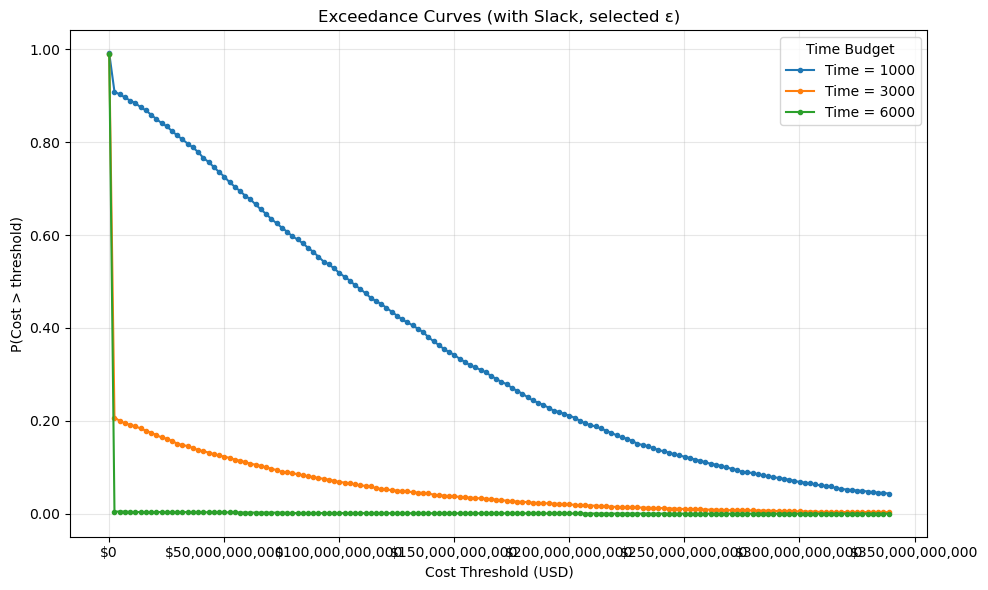

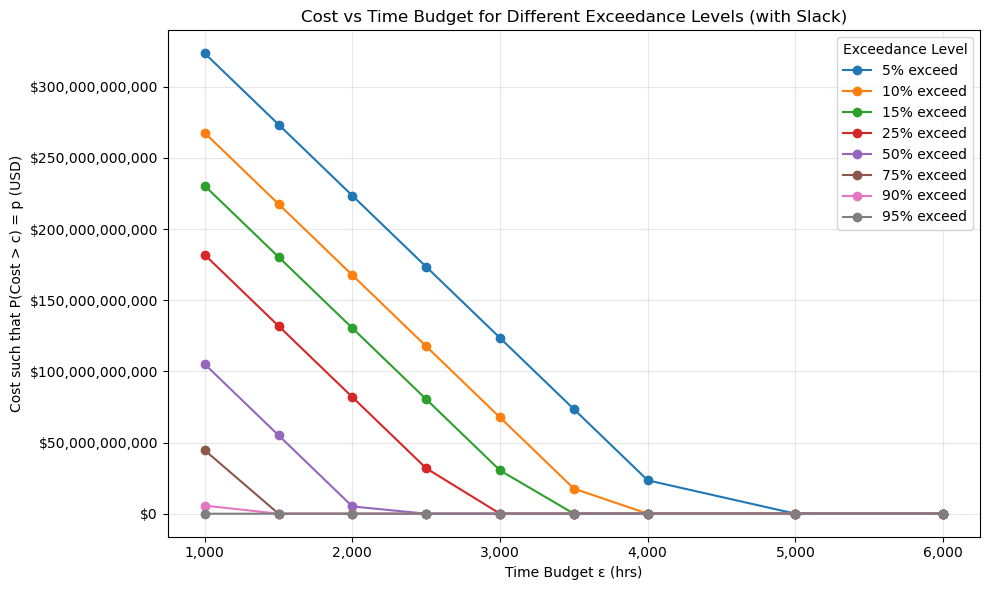

In [211]:
# === Exceedance curves WITH SLACK (selected eps only) ===
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mt

# --- settings ---
BIGM_PER_HOUR = 1000000
ROUND_UP_HOURS = True
eps_to_plot = [1000, 3000, 6000]

df_soft = df_crn.copy()

# compute slack & penalized cost if missing
if 'TimeSlack' not in df_soft.columns or 'CostWithPenalty' not in df_soft.columns:
    slack = np.maximum(0.0, df_soft['Time'].to_numpy(float) - df_soft['Epsilon'].to_numpy(float))
    if ROUND_UP_HOURS:
        slack = np.ceil(slack)
    df_soft['TimeSlack'] = slack
    df_soft['CostWithPenalty'] = df_soft['Cost'].to_numpy(float) + BIGM_PER_HOUR * slack

cost_col = 'CostWithPenalty'
selected = df_soft[np.isfinite(df_soft[cost_col])].copy()

# thresholds
all_costs = selected[cost_col].to_numpy(float)
p01, p99 = np.percentile(all_costs, [1, 99])
x_thresholds = np.linspace(p01, p99, 150)

def fmt_prob(y, _): return f"{y:.2f}"
def fmt_dollar(x, _): return f"${x:,.0f}"

plt.figure(figsize=(10,6))
for eps in eps_to_plot:
    costs_eps = selected.loc[selected["Epsilon"] == eps, cost_col].to_numpy(float)
    if costs_eps.size == 0:
        continue
    N = costs_eps.size
    probs = [(costs_eps > c).sum() / N for c in x_thresholds]
    plt.plot(x_thresholds, probs, marker='o', ms=3, label=f"Time = {eps}")

plt.xlabel("Cost Threshold (USD)")
plt.ylabel("P(Cost > threshold)")
plt.title("Exceedance Curves (with Slack, selected ε)")
plt.grid(True, alpha=0.3)
plt.legend(title="Time Budget", ncol=1)
plt.gca().yaxis.set_major_formatter(mt.FuncFormatter(fmt_prob))
plt.gca().xaxis.set_major_formatter(mt.FuncFormatter(fmt_dollar))
plt.tight_layout()
plt.show()


# === Cost vs Time at fixed exceedance levels (WITH SLACK) ===
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mt

BIGM_PER_HOUR = 200.0          # penalty per hour of time overage
ROUND_UP_HOURS = True          # ceil the slack in hours
eps_to_plot = None             # e.g., [1000, 2000, 3000, 4000, 5000] to subset; or None for all

df_soft = df_crn.copy()

# Compute slack & penalized cost if missing
if 'TimeSlack' not in df_soft.columns or 'CostWithPenalty' not in df_soft.columns:
    slack = np.maximum(0.0, df_soft['Time'].to_numpy(float) - df_soft['Epsilon'].to_numpy(float))
    if ROUND_UP_HOURS:
        slack = np.ceil(slack)
    df_soft['TimeSlack'] = slack
    df_soft['CostWithPenalty'] = df_soft['Cost'].to_numpy(float) + BIGM_PER_HOUR * slack

# Optionally restrict to selected epsilons
if eps_to_plot is not None:
    df_soft = df_soft[df_soft['Epsilon'].isin(eps_to_plot)]

# Build quantiles of penalized costs per epsilon
exceed_levels = [0.05, 0.10, 0.15, 0.25, 0.50, 0.75, 0.90, 0.95]
exceed_data = {p: [] for p in exceed_levels}

for eps, grp in df_soft.groupby("Epsilon"):
    costs = np.sort(grp["CostWithPenalty"].to_numpy(float))
    if costs.size == 0:
        continue
    for p_ex in exceed_levels:
        # c_p such that P(Cost > c_p) = p_ex  => (1 - p_ex) quantile of costs
        c_p = np.quantile(costs, 1 - p_ex)
        exceed_data[p_ex].append((eps, c_p))

# Plot
plt.figure(figsize=(10,6))
for p_ex in exceed_levels:
    pts = sorted(exceed_data[p_ex], key=lambda x: x[0])
    if not pts:
        continue
    xs = [t for t,_ in pts]
    ys = [c for _,c in pts]
    plt.plot(xs, ys, marker='o', linestyle='-', label=f"{int(p_ex*100)}% exceed")

plt.xlabel("Time Budget ε (hrs)")
plt.ylabel("Cost such that P(Cost > c) = p (USD)")
plt.title("Cost vs Time Budget for Different Exceedance Levels (with Slack)")
plt.grid(True, alpha=0.3)
plt.legend(title="Exceedance Level")
plt.gca().xaxis.set_major_formatter(mt.FuncFormatter(lambda x,_: f"{int(x):,}"))
plt.gca().yaxis.set_major_formatter(mt.FuncFormatter(lambda y,_: f"${y:,.0f}"))
plt.tight_layout()
plt.show()

   Epsilon  count_below_1M  total  percent_below_1M
0     1000             135   5000              2.70
1     1500             155   5000              3.10
2     2000             167   5000              3.34
3     2500             168   5000              3.36
4     3000             168   5000              3.36
5     3500             169   5000              3.38
6     4000             169   5000              3.38
7     5000             169   5000              3.38
8     6000             169   5000              3.38


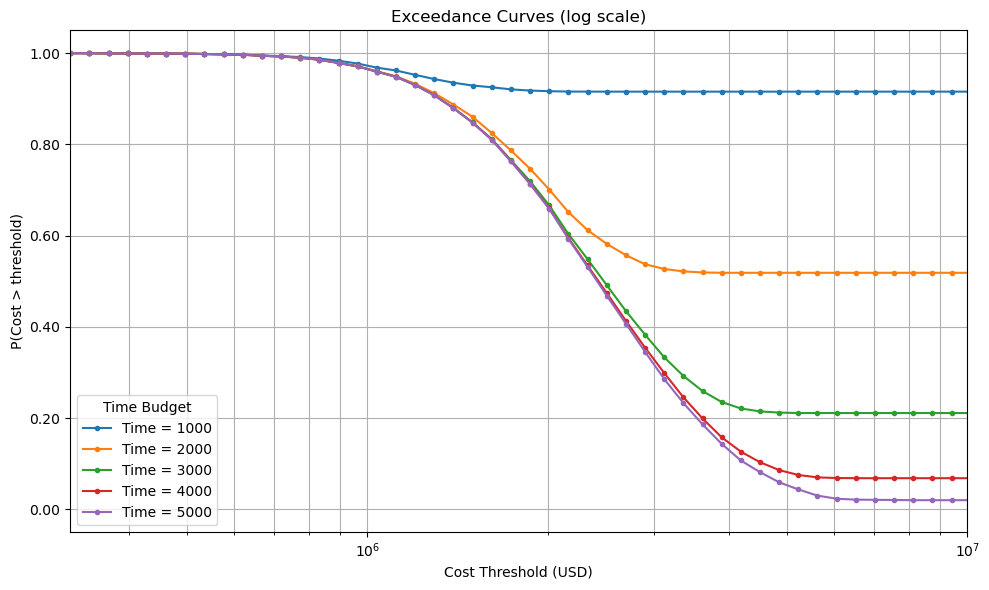

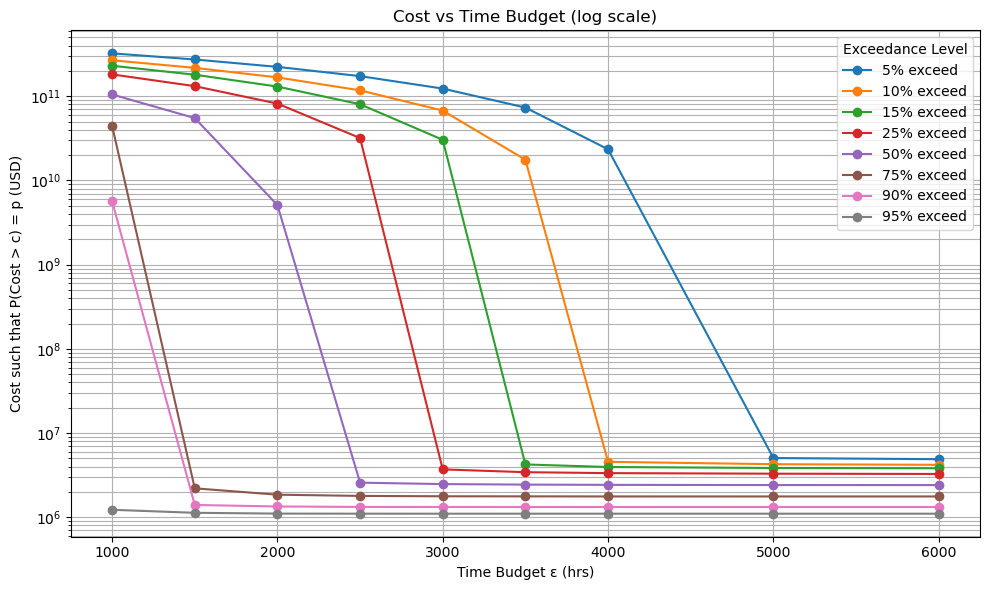

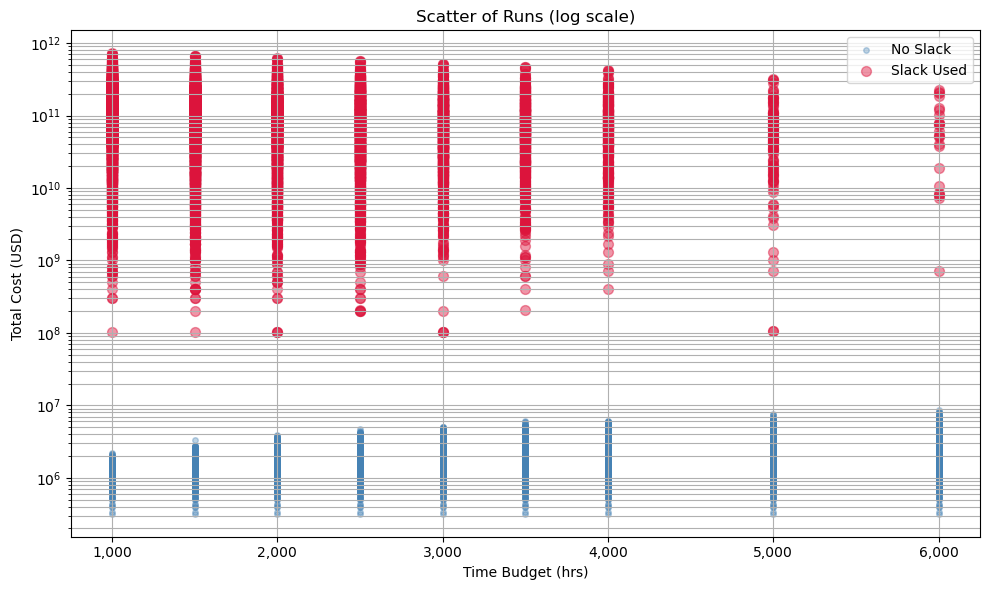

In [231]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mt

threshold = 1_000_000  # 1 million

summary = (
    df_crn.groupby("Epsilon")
    .agg(
        count_below_1M = ("CostWithPenalty", lambda x: (x < threshold).sum()),
        total          = ("CostWithPenalty", "size")
    )
    .reset_index()
)

summary["percent_below_1M"] = 100 * summary["count_below_1M"] / summary["total"]
print(summary)
eps_to_plot = [1000, 2000, 3000, 4000, 5000]   # pick any subset

selected = df_crn[df_crn["Epsilon"].isin(eps_to_plot)].copy()

all_costs = selected["CostWithPenalty"].to_numpy(float)
p01 = float(np.percentile(all_costs, 1))
p99 = float(np.percentile(all_costs, 99))
#x_thresholds = np.linspace(p01, p99, 120)
#x_thresholds = np.logspace(np.log10(p01), np.log10(p99), 120)
pmin = float(all_costs.min())
pmax = float(all_costs.max())
x_thresholds = np.logspace(np.log10(pmin), np.log10(pmax), 200)

def fmt_prob(y, _): return f"{y:.2f}"
def fmt_dollar(x, _): return f"${x:,.0f}"

# ============================================================
# 1) Exceedance curves
# ============================================================

cutoff=10e6
plt.figure(figsize=(10,6))
for eps in sorted(eps_to_plot):
    costs_eps = selected.loc[selected["Epsilon"]==eps, "CostWithPenalty"].to_numpy(float)
    if costs_eps.size == 0:
        continue
    N = len(costs_eps)
    probs = [(costs_eps > c).sum()/N for c in x_thresholds]
    plt.plot(x_thresholds, probs, marker='o', ms=3, label=f"Time = {eps}")

plt.xlabel("Cost Threshold (USD)")
plt.ylabel("P(Cost > threshold)")
plt.title("Exceedance Curves (log scale)")
plt.grid(True, which="both")
plt.legend(title="Time Budget")

plt.gca().yaxis.set_major_formatter(mt.FuncFormatter(fmt_prob))
plt.gca().xaxis.set_major_formatter(mt.FuncFormatter(fmt_dollar))
plt.xscale("log")   # <<< log scale for cost
plt.xlim(pmin, cutoff) 
plt.tight_layout()
plt.show()

# ============================================================
# 2) Cost vs Time Budget at exceedance levels
# ============================================================
exceed_levels = [0.05, 0.10, 0.15, 0.25, 0.50, 0.75, 0.90, 0.95]
exceed_data = {p: [] for p in exceed_levels}

for eps, grp in df_crn.groupby("Epsilon"):
    costs = np.sort(grp["CostWithPenalty"].to_numpy(float))
    if costs.size == 0:
        continue
    for p in exceed_levels:
        c_p = np.quantile(costs, 1 - p)      # cost where P(Cost > c)=p
        exceed_data[p].append((eps, c_p))

plt.figure(figsize=(10,6))
for p in exceed_levels:
    pts = sorted(exceed_data[p], key=lambda x: x[0])
    if not pts: 
        continue
    xs = [t for t,_ in pts]
    ys = [c for _,c in pts]
    plt.plot(xs, ys, marker='o', label=f"{int(p*100)}% exceed")

plt.xlabel("Time Budget ε (hrs)")
plt.ylabel("Cost such that P(Cost > c) = p (USD)")
plt.title("Cost vs Time Budget (log scale)")
plt.grid(True, which="both")
plt.legend(title="Exceedance Level")
#plt.xlim(0,10e7)
plt.gca().yaxis.set_major_formatter(mt.FuncFormatter(lambda y,_: f"${y:,.0f}"))
plt.yscale("log")   # <<< log scale for cost
plt.tight_layout()
plt.show()

# ============================================================
# 3) Scatter (Slack vs No Slack)
# ============================================================
fig, ax = plt.subplots(figsize=(10,6))

# blue = no slack; red = slack used
mask_no  = (df_crn["TimeSlack"]==0)
mask_yes = (df_crn["TimeSlack"]>0)

ax.scatter(df_crn.loc[mask_no,  "Epsilon"],
           df_crn.loc[mask_no,  "CostWithPenalty"],
           c="steelblue", alpha=0.35, s=16, label="No Slack")

ax.scatter(df_crn.loc[mask_yes, "Epsilon"],
           df_crn.loc[mask_yes, "CostWithPenalty"],
           c="crimson",   alpha=0.45, s=50, label="Slack Used")

ax.set_xlabel("Time Budget (hrs)")
ax.set_ylabel("Total Cost (USD)")
#ax.set_ylim(0,10e7)
ax.set_title("Scatter of Runs (log scale)")
ax.grid(True, which="both")
ax.legend()
ax.xaxis.set_major_formatter(mt.FuncFormatter(lambda x,_: f"{int(x):,}"))
ax.yaxis.set_major_formatter(mt.FuncFormatter(lambda y,_: f"${y:,.0f}"))

ax.set_yscale("log")   # <<< log scale for cost
plt.tight_layout()
plt.show()

## Only feasible

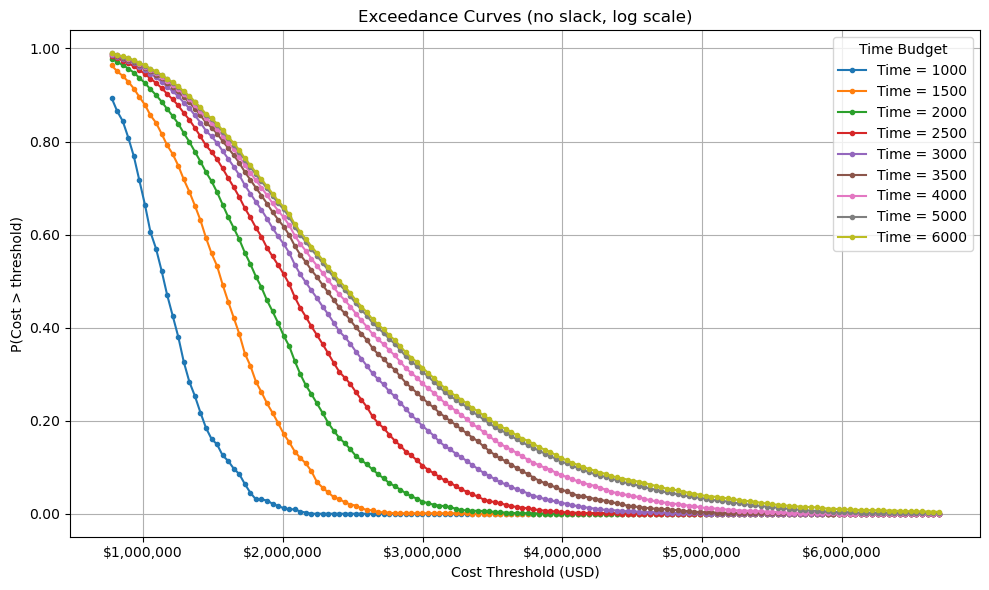

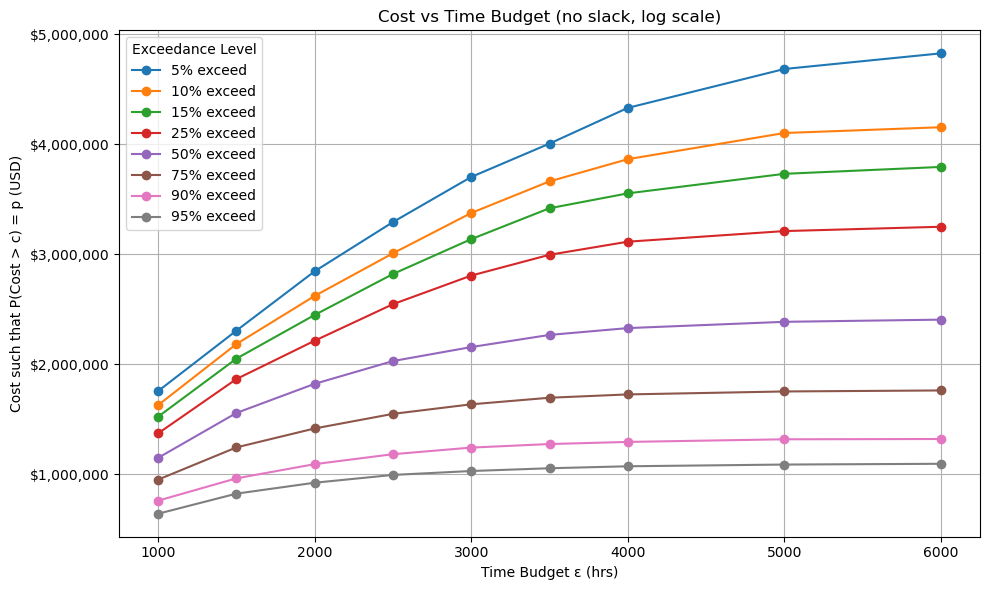

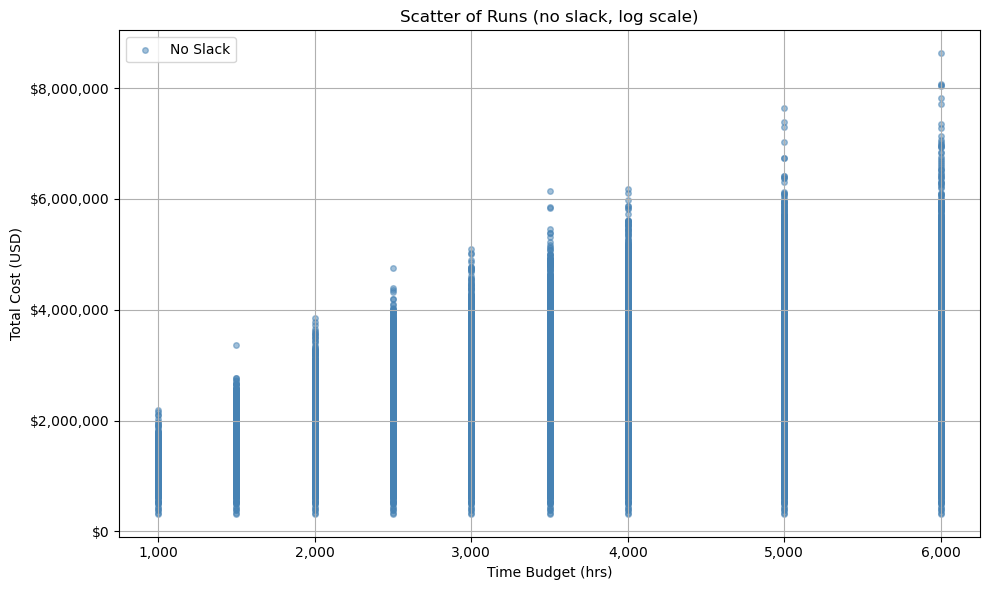

In [239]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mt

# ---------- filter: NO SLACK ONLY ----------
if "TimeSlack" in df_crn.columns:
    df_no = df_crn[df_crn["TimeSlack"] == 0].copy()
else:
    # if you're on the hard-constraint run, everything is no-slack already
    df_no = df_crn.copy()

# we'll use the unpenalized cost
cost_col = "Cost"

# quick sanity: drop epsilons that have no no-slack points
eps_available = sorted(df_no["Epsilon"].unique().tolist())

# ---------- 1) Exceedance curves (log x) ----------
'''all_costs = df_no[cost_col].to_numpy(float)
pmin = float(all_costs.min())
pmax = float(all_costs.max())
x_thresholds = np.logspace(np.log10(pmin), np.log10(pmax), 200)'''

all_costs = selected[cost_col].to_numpy(float)
pmin, pmax = np.percentile(all_costs, [1, 99])
x_thresholds = np.linspace(p01, p99, 150)

def fmt_prob(y, _): return f"{y:.2f}"
def fmt_dollar(x, _): return f"${x:,.0f}"

plt.figure(figsize=(10,6))
for eps in eps_available:
    costs_eps = df_no.loc[df_no["Epsilon"]==eps, cost_col].to_numpy(float)
    if costs_eps.size == 0: 
        continue
    N = len(costs_eps)
    probs = [(costs_eps > c).sum()/N for c in x_thresholds]
    plt.plot(x_thresholds, probs, marker='o', ms=3, label=f"Time = {eps}")

plt.xlabel("Cost Threshold (USD)")
plt.ylabel("P(Cost > threshold)")
plt.title("Exceedance Curves (no slack, log scale)")
plt.grid(True, which="both")
plt.legend(title="Time Budget")
plt.gca().yaxis.set_major_formatter(mt.FuncFormatter(fmt_prob))
plt.gca().xaxis.set_major_formatter(mt.FuncFormatter(fmt_dollar))
#plt.xscale("log")
plt.tight_layout()
plt.show()

# ---------- 2) Cost vs Time at fixed exceedance levels (log y) ----------
exceed_levels = [0.05, 0.10, 0.15, 0.25, 0.50, 0.75, 0.90, 0.95]
exceed_data = {p: [] for p in exceed_levels}

for eps, grp in df_no.groupby("Epsilon"):
    costs = np.sort(grp[cost_col].to_numpy(float))
    if costs.size == 0:
        continue
    for p in exceed_levels:
        c_p = np.quantile(costs, 1 - p)  # cost where P(Cost > c) = p
        exceed_data[p].append((eps, c_p))

plt.figure(figsize=(10,6))
for p in exceed_levels:
    pts = sorted(exceed_data[p], key=lambda x: x[0])
    if not pts:
        continue
    xs = [t for t,_ in pts]
    ys = [c for _,c in pts]
    plt.plot(xs, ys, marker='o', label=f"{int(p*100)}% exceed")

plt.xlabel("Time Budget ε (hrs)")
plt.ylabel("Cost such that P(Cost > c) = p (USD)")
plt.title("Cost vs Time Budget (no slack, log scale)")
plt.grid(True, which="both")
plt.legend(title="Exceedance Level")
plt.gca().yaxis.set_major_formatter(mt.FuncFormatter(lambda y,_: f"${y:,.0f}"))
#plt.yscale("log")
plt.tight_layout()
plt.show()

# ---------- 3) Scatter (no slack only, log y) ----------
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df_no["Epsilon"], df_no[cost_col],
           c="steelblue", alpha=0.5, s=16, label="No Slack")

ax.set_xlabel("Time Budget (hrs)")
ax.set_ylabel("Total Cost (USD)")
ax.set_title("Scatter of Runs (no slack, log scale)")
ax.grid(True, which="both")
ax.legend()
ax.xaxis.set_major_formatter(mt.FuncFormatter(lambda x,_: f"{int(x):,}"))
ax.yaxis.set_major_formatter(mt.FuncFormatter(lambda y,_: f"${y:,.0f}"))
#ax.set_yscale("log")
plt.tight_layout()
plt.show()

# Deterministic

In [ ]:
# ===============================================================
# Deterministic (10-scenario) sweep using economies-of-scale PWL
# ===============================================================

import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mt

# ----------------------------
# Base data
# ----------------------------
machines = ['AM_hWAAM', 'AM_Binder', 'AM_slm', 'AM_PBF', 'TM_Casting']
parts    = ['part_1','part_2']

batch_size = {
    ('AM_hWAAM','part_1'):6, ('AM_hWAAM','part_2'):6,
    ('AM_Binder','part_1'):8,('AM_Binder','part_2'):8,
    ('AM_slm','part_1'):5,  ('AM_slm','part_2'):5,
    ('AM_PBF','part_1'):5,  ('AM_PBF','part_2'):5,
    ('TM_Casting','part_1'):1,('TM_Casting','part_2'):1,
}
base_time = {
    ('AM_hWAAM','part_1'):9.30,  ('AM_hWAAM','part_2'):9.30,
    ('AM_Binder','part_1'):8.74, ('AM_Binder','part_2'):7.74,
    ('AM_slm','part_1'):14.77,   ('AM_slm','part_2'):13.77,
    ('AM_PBF','part_1'):22.86,   ('AM_PBF','part_2'):21.86,
    ('TM_Casting','part_1'):4.5, ('TM_Casting','part_2'):24,
}
base_setup = {
    'AM_hWAAM':380000, 'AM_Binder':350000,'AM_slm':400000,
    'AM_PBF':500000,   'TM_Casting':430000
}
cap_hours = {'AM_hWAAM':440,'AM_Binder':460,'AM_slm':460,
             'AM_PBF':450,'TM_Casting':460}

# same x-breakpoints for all machines
pwl_breakpoints = {m:[0,25,50,100,200,400,800,1200,2200] for m in machines}

FIXED_PWL_COSTVALS = {
    'AM_hWAAM': [
        0,
        25*1000,
        25*1000 + 25*950,
        25*1000 + 25*950 + 50*903,
        25*1000 + 25*950 + 50*903 + 100*879,
        25*1000 + 25*950 + 50*903 + 100*879 + 200*855,
        25*1000 + 25*950 + 50*903 + 100*879 + 200*855 + 400*831,
        25*1000 + 25*950 + 50*903 + 100*879 + 200*855 + 400*831 + 400*808,
        25*1000 + 25*950 + 50*903 + 100*879 + 200*855 + 400*831 + 400*808 + 1000*784
    ],
    'AM_Binder': [
        0,
        25*626,
        25*626 + 25*594,
        25*626 + 25*594 + 50*566,
        25*626 + 25*594 + 50*566 + 100*526,
        25*626 + 25*594 + 50*566 + 100*526 + 200*522,
        25*626 + 25*594 + 50*566 + 100*526 + 200*522 + 400*508,
        25*626 + 25*594 + 50*566 + 100*526 + 200*522 + 400*508 + 400*496,
        25*626 + 25*594 + 50*566 + 100*526 + 200*522 + 400*508 + 400*496 + 1000*506
    ],
    'AM_slm': [
        0,
        25*790,
        25*790 + 25*750,
        25*790 + 25*750 + 50*710,
        25*790 + 25*750 + 50*710 + 100*693,
        25*790 + 25*750 + 50*710 + 100*693 + 200*659,
        25*790 + 25*750 + 50*710 + 100*693 + 200*659 + 400*640,
        25*790 + 25*750 + 50*710 + 100*693 + 200*659 + 400*640 + 400*623,
        25*790 + 25*750 + 50*710 + 100*693 + 200*659 + 400*640 + 400*623 + 1000*603
    ],
    'AM_PBF': [
        0,
        25*960,
        25*960 + 25*912,
        25*960 + 25*912 + 50*922,
        25*960 + 25*912 + 50*922 + 100*902,
        25*960 + 25*912 + 50*922 + 100*902 + 200*814,
        25*960 + 25*912 + 50*922 + 100*902 + 200*814 + 400*796,
        25*960 + 25*912 + 50*922 + 100*902 + 200*814 + 400*796 + 400*774,
        25*960 + 25*912 + 50*922 + 100*902 + 200*814 + 400*796 + 400*774 + 1000*756
    ],
    'TM_Casting': [
        0,
        25*2500,
        25*2500 + 25*2375,
        25*2500 + 25*2375 + 50*1583,
        25*2500 + 25*2375 + 50*1583 + 100*1188,
        25*2500 + 25*2375 + 50*1583 + 100*1188 + 200*991,
        25*2500 + 25*2375 + 50*1583 + 100*1188 + 200*991 + 400*792,
        25*2500 + 25*2375 + 50*1583 + 100*1188 + 200*991 + 400*792 + 400*595,
        25*2500 + 25*2375 + 50*1583 + 100*1188 + 200*991 + 400*792 + 400*595 + 1000*396
    ]
}

# budget cap
B = 1e7

# ----------------------------
# Deterministic grids (10 scenarios)
# ----------------------------
DEMAND_LIST = [200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200]
SETUP_MULT  = [0.70, 0.76, 0.82, 0.88, 0.94, 1.06, 1.12, 1.18, 1.24, 1.30]
TIME_MULT   = [0.85, 0.88, 0.91, 0.94, 0.97, 1.03, 1.06, 1.09, 1.12, 1.15]

# Optional: vary cumulative PWL cost levels (off by default)
USE_COST_MULT = False
COST_MULT = [1]
#COST_MULT = [0.90, 0.92, 0.94, 0.96, 0.98, 1.02, 1.04, 1.06, 1.08, 1.10]

# ----------------------------
# Build one deterministic scenario by index k ∈ {0..9}
# ----------------------------
def build_det_scenario(k):
    D = DEMAND_LIST[k]
    setup_cost = {m: base_setup[m] * SETUP_MULT[k] for m in machines}
    samp_time  = {key: base_time[key] * TIME_MULT[k] for key in base_time}

    if USE_COST_MULT:
        samp_costvals = {m: [v * COST_MULT[k] for v in FIXED_PWL_COSTVALS[m]] for m in machines}
    else:
        samp_costvals = {m: FIXED_PWL_COSTVALS[m][:] for m in machines}

    return {
        'Demand': D,
        'setup_cost': setup_cost,
        'samp_time': samp_time,
        'samp_costvals': samp_costvals
    }

# ---------------------------------------------
# Solve the model for a given (scenario, epsilon)
# ---------------------------------------------
def solve_model_for(scn, epsilon):
    D = scn['Demand']
    setup_cost = scn['setup_cost']
    samp_time  = scn['samp_time']
    samp_costvals = scn['samp_costvals']

    model = gp.Model()
    model.Params.OutputFlag = 0

    x   = model.addVars(machines, parts, vtype=GRB.INTEGER, name='x')
    n   = model.addVars(machines, vtype=GRB.INTEGER, lb=0, name='n')
    vol = model.addVars(machines, vtype=GRB.CONTINUOUS, name='vol')
    vc  = model.addVars(machines, vtype=GRB.CONTINUOUS, name='vc')

    T = gp.quicksum(x[i,j]*batch_size[i,j]*samp_time[(i,j)]
                    for i in machines for j in parts)
    C = gp.quicksum(setup_cost[i]*n[i] + vc[i] for i in machines)

    model.setObjective(C, GRB.MINIMIZE)

    model.addConstr(C <= B)
    model.addConstr(T <= epsilon)
    model.addConstr(gp.quicksum(x[i,j]*batch_size[i,j]
                                for i in machines for j in parts) >= D)

    for m in machines:
        model.addConstr(vol[m] == gp.quicksum(x[m,j]*batch_size[(m,j)] for j in parts))
        model.addConstr(
            gp.quicksum(x[m,j]*batch_size[(m,j)]*samp_time[(m,j)] for j in parts)
            <= cap_hours[m]*n[m]
        )
        model.addGenConstrPWL(vol[m], vc[m], pwl_breakpoints[m], samp_costvals[m])

    model.optimize()

    if model.status == GRB.OPTIMAL:
        volumes = {m: float(vol[m].X) for m in machines}
        copies  = {m: int(round(n[m].X)) for m in machines}
        return {
            'Cost': float(C.getValue()),
            'Time': float(T.getValue()),
            'status': 'OPTIMAL',
            'volumes': volumes,
            'copies': copies
        }
    else:
        return {'Cost': np.nan, 'Time': np.nan, 'status': str(model.status),
                'volumes': {m: 0.0 for m in machines},
                'copies':  {m: 0 for m in machines}}

# -----------------------
# 4) Deterministic grid: 10^4 scenarios (cartesian product)
# -----------------------
from itertools import product

# 10 values for each variable (tweak as you like)
DEMAND_LIST      = [200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200]     # Demand
SETUP_MULT_LIST  = [0.70, 0.76, 0.82, 0.88, 0.94, 1.06, 1.12, 1.18, 1.24, 1.30]  # setup $
TIME_MULT_LIST   = [0.85, 0.88, 0.91, 0.94, 0.97, 1.03, 1.06, 1.09, 1.12, 1.15]  # process time
COST_MULT_LIST   = [0.90, 0.92, 0.94, 0.96, 0.98, 1.02, 1.04, 1.06, 1.08, 1.10]  # PWL cumulative cost

def build_scenario(D, setup_mult, time_mult, cost_mult):
    setup_cost = {m: base_setup[m] * setup_mult for m in machines}
    samp_time  = {k: base_time[k] * time_mult   for k in base_time}
    samp_costvals = {m: [v * cost_mult for v in FIXED_PWL_COSTVALS[m]] for m in machines}
    return {
        'Demand': D,
        'setup_cost': setup_cost,
        'samp_time': samp_time,
        'samp_costvals': samp_costvals
    }

epsilons = [1000, 1500, 2000, 2500 ,3000, 3500, 4000, 5000, 6000]

records = []
scn_id = 0
for D, sm, tm, cm in product(DEMAND_LIST, SETUP_MULT_LIST, TIME_MULT_LIST, COST_MULT_LIST):
    scn = build_scenario(D, sm, tm, cm)
    for eps in epsilons:
        sol = solve_model_for(scn, eps)
        rec = {
            'scenario': scn_id,
            'Epsilon': eps,
            'Demand': D,
            'Cost': sol['Cost'],
            'Time': sol['Time'],
            'Status': sol['status']
        }
        for m in machines:
            rec[f'vol_{m}'] = sol['volumes'].get(m, 0.0)
            rec[f'n_{m}']   = sol['copies'].get(m, 0)
        records.append(rec)
    scn_id += 1

df_crn = pd.DataFrame(records)
df_crn = df_crn[df_crn['Status'] == 'OPTIMAL'].copy()

# ===========================================================
# 5A) Plot 1: Exceedance curves (P(Cost > c) vs cost), all ε
# ===========================================================
selected = df_crn.copy()

all_costs = selected["Cost"].to_numpy(float)
p01 = float(np.percentile(all_costs, 1))
p99 = float(np.percentile(all_costs, 99))
x_thresholds = np.linspace(p01, p99, 150)

def fmt_prob(y, _): return f"{y:.2f}"
def fmt_dollar(x, _): return f"${x:,.0f}"

plt.figure(figsize=(10,6))
for eps in epsilons:
    costs_eps = selected[selected["Epsilon"] == eps]["Cost"].to_numpy(float)
    if len(costs_eps) == 0:
        continue
    probs = []
    N = len(costs_eps)
    for c in x_thresholds:
        probs.append((costs_eps > c).sum() / N)
    plt.plot(x_thresholds, probs, marker='o', ms=3, label=f"Time = {eps}")

plt.xlabel("Cost Threshold (USD)")
plt.ylabel("P(Cost > threshold)")
plt.title("Exceedance Curves (Deterministic Scenarios)")
plt.grid(True)
plt.legend(title="Time Budget")
plt.gca().yaxis.set_major_formatter(mt.FuncFormatter(fmt_prob))
plt.gca().xaxis.set_major_formatter(mt.FuncFormatter(fmt_dollar))
plt.tight_layout()
plt.show()

# ===================================================================
# 5B) Plot 2: Cost vs Time at fixed exceedance levels (group by ε)
# ===================================================================
exceed_levels = [0.05, 0.10, 0.15, 0.25, 0.50]  # 5%, 10%, 15%, 25%, 50%
exceed_data = {p: [] for p in exceed_levels}

for eps in epsilons:
    costs = df_crn[df_crn["Epsilon"] == eps]["Cost"].to_numpy(float)
    costs.sort()
    if len(costs) == 0:
        continue
    for p_ex in exceed_levels:
        # c_p such that P(Cost > c_p) = p_ex  => (1 - p_ex) quantile
        c_p = np.quantile(costs, 1 - p_ex)
        exceed_data[p_ex].append((eps, c_p))

plt.figure(figsize=(10,6))
for p_ex in exceed_levels:
    pts = sorted(exceed_data[p_ex], key=lambda x: x[0])
    if not pts:
        continue
    xs = [t for t,_ in pts]
    ys = [c for _,c in pts]
    plt.plot(xs, ys, marker='o', linestyle='-', label=f"{int(p_ex*100)}% exceed")

plt.xlabel("Time Budget (hrs)")
plt.ylabel("Cost such that P(Cost > c) = p (USD)")
plt.title("Cost vs Time Budget at Exceedance Levels (Deterministic Scenarios)")
plt.grid(True)
plt.legend(title="Exceedance Level")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Exceedance levels (probability that cost is higher)
p_levels = [0.05, 0.10, 0.15, 0.25, 0.50]   # 5%, 10%, 15%, 25%, 50%

results = {p: [] for p in p_levels}

# Loop over unique time budgets
for eps in np.unique(df_crn["Epsilon"]):
    costs = df_crn[df_crn["Epsilon"] == eps]["Cost"].values
    if len(costs) > 0:
        for p in p_levels:
            c_p = np.quantile(costs, 1 - p)   # (1 - p) quantile
            results[p].append((eps, c_p))

# Plot all curves
plt.figure(figsize=(8,5))
for p in p_levels:
    epsilons = [t for t,_ in results[p]]
    costs_p  = [c for _,c in results[p]]
    plt.plot(epsilons, costs_p, marker='o', label=f"{int(p*100)}% exceed")

plt.xlabel("Time Budget (hrs)")
plt.ylabel("Cost (USD)")
plt.title("Cost vs Time at Different Exceedance Levels")
plt.grid(True)
plt.legend(title="Exceedance Level")
plt.show()

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mt

# ───────────────────────────────────────────────────────────────
# 0) Base data
machines = ['AM_hWAAM', 'AM_Binder', 'AM_slm', 'AM_PBF', 'TM_Casting']

parts    = ['part_1','part_2']

batch_size = {
    ('AM_hWAAM','part_1'):6, ('AM_hWAAM','part_2'):6,
    ('AM_Binder','part_1'):8,('AM_Binder','part_2'):8,
    ('AM_slm','part_1'):5,    ('AM_slm','part_2'):5,
    ('AM_PBF','part_1'):5,    ('AM_PBF','part_2'):5,
    ('TM_Casting','part_1'):1,('TM_Casting','part_2'):1,
}
base_time = {
    ('AM_hWAAM','part_1'):9.30,  ('AM_hWAAM','part_2'):9.30,
    ('AM_Binder','part_1'):8.74, ('AM_Binder','part_2'):7.74,
    ('AM_slm','part_1'):14.77,   ('AM_slm','part_2'):13.77,
    ('AM_PBF','part_1'):22.86,   ('AM_PBF','part_2'):21.86,
    ('TM_Casting','part_1'):4.5, ('TM_Casting','part_2'):24,
}
base_setup = {
    'AM_hWAAM':380000, 'AM_Binder':350000,'AM_slm':400000,
    'AM_PBF':500000,   'TM_Casting':430000
}
cap_hours = {'AM_hWAAM':440,'AM_Binder':460,'AM_slm':460,
             'AM_PBF':450,'TM_Casting':260}

pwl_breakpoints = {m:[0,25,50,100,200,400,800,1200,2200] for m in machines}

base_unit_rates = {
    'AM_hWAAM':1000, 'AM_Binder':626, 'AM_slm':790,
    'AM_PBF':960,  'TM_Casting':2500
}

B = 1e7 

# ───────────────────────────────────────────────────────────────
# 1) Uncertainty settings
r, mean = 5, 1000
p = r/(r+mean)

def sample_trunc_normal(mu, sigma, low):
    v = np.random.normal(mu, sigma)
    return max(v, low)

def sample_one_scenario():
    
    D = np.random.negative_binomial(r, p)

    # setup costs
    setup_cost = {m: sample_trunc_normal(base_setup[m], 0.20*base_setup[m], 1)
                  for m in machines}

    # process times
    samp_time = {k: sample_trunc_normal(t, 0.15*t, 0.1)
                 for k, t in base_time.items()}

    # PWL cost (integral) values: cumulative integral at breakpoints
    samp_costvals = {}
    for m in machines:
        rate = sample_trunc_normal(base_unit_rates[m], 0.20*base_unit_rates[m], 0.1)
        bp   = pwl_breakpoints[m]
        widths = [bp[i+1]-bp[i] for i in range(len(bp)-1)]
        cum = [0]
        for w in widths:
            cum.append(cum[-1] + w*rate)
        samp_costvals[m] = cum

    return {
        'Demand': D,
        'setup_cost': setup_cost,
        'samp_time': samp_time,
        'samp_costvals': samp_costvals
    }

def solve_model_for(scn, epsilon):
    
    D = scn['Demand']
    setup_cost = scn['setup_cost']
    samp_time  = scn['samp_time']
    samp_costvals = scn['samp_costvals']

    model = gp.Model()
    model.Params.OutputFlag = 0

    x   = model.addVars(machines, parts, vtype=GRB.INTEGER, name='x')
    n   = model.addVars(machines, vtype=GRB.INTEGER, lb=0, name='n')
    vol = model.addVars(machines, vtype=GRB.CONTINUOUS, name='vol')
    vc  = model.addVars(machines, vtype=GRB.CONTINUOUS, name='vc')

    T = gp.quicksum(x[i,j]*batch_size[i,j]*samp_time[(i,j)]
                    for i in machines for j in parts)
    C = gp.quicksum(setup_cost[i]*n[i] + vc[i] for i in machines)
    model.setObjective(C, GRB.MINIMIZE)

    # constraints
    model.addConstr(C <= B)
    model.addConstr(T <= epsilon)
    model.addConstr(gp.quicksum(x[i,j]*batch_size[i,j]
                    for i in machines for j in parts) >= D)

    for m in machines:
        model.addConstr(vol[m] == gp.quicksum(x[m,j]*batch_size[(m,j)] for j in parts))
        model.addConstr(
            gp.quicksum(x[m,j]*batch_size[(m,j)]*samp_time[(m,j)] for j in parts)
            <= cap_hours[m]*n[m]
        )
        model.addGenConstrPWL(vol[m], vc[m],
                              pwl_breakpoints[m],
                              samp_costvals[m])

    model.optimize()
    if model.status == GRB.OPTIMAL:
        return {
            'Cost': float(C.getValue()),
            'Time': float(T.getValue()),
            'status': 'OPTIMAL'
        }
    else:
        return {'Cost': np.nan, 'Time': np.nan, 'status': str(model.status)}

# =========================
# EXCEEDANCE CURVES
# =========================

# 2) CRN Monte Carlo: same scenarios across all epsilons
S = 50000  # number of scenarios (adjust as needed)
epsilons = [1000, 1500, 2000, 2500 ,3000, 3500, 4000]  # time budgets to compare

records = []
for s in range(S):
    scn = sample_one_scenario()            # sample ω once
    for eps in epsilons:                   # reuse ω for each epsilon
        sol = solve_model_for(scn, eps)
        records.append({
            'scenario': s,
            'Epsilon': eps,
            'Demand': scn['Demand'],
            'Cost': sol['Cost'],
            'Time': sol['Time'],
            'Status': sol['status']
        })

df_crn = pd.DataFrame(records)
df_crn = df_crn[df_crn['Status'] == 'OPTIMAL'].copy()


# --- 1) Filter to optimal runs only (so I don't plot failed solves)


# --- Use ALL optimal scenarios (no demand filter)
selected_data = df_crn[df_crn["Status"] == "OPTIMAL"].copy()

# --- Build thresholds from the central cost range (1st–99th pct) so outliers don't dominate
all_cost_values = selected_data["Cost"].to_numpy(dtype=float)
if len(all_cost_values) == 0:
    raise ValueError("No cost data available to plot exceedance curves.")

p01 = float(np.percentile(all_cost_values, 1))   # 1st percentile
p99 = float(np.percentile(all_cost_values, 99))  # 99th percentile

number_of_threshold_points = 150
cost_threshold_values = np.linspace(p01, p99, number_of_threshold_points)

# --- Pretty formatters
def format_probability(y_value, _pos):
    return f"{y_value:.2f}"

def format_dollar(x_value, _pos):
    return f"${x_value:,.0f}"

# --- Exceedance curves over ALL demand scenarios
plt.figure(figsize=(10, 6))

for epsilon_value in epsilons:
    rows_this_epsilon = selected_data[selected_data["Epsilon"] == epsilon_value]
    costs_this_epsilon = rows_this_epsilon["Cost"].to_numpy(dtype=float)

    if len(costs_this_epsilon) == 0:
        continue

    exceedance_probabilities = []
    for threshold in cost_threshold_values:
        count_above = 0
        total_runs = len(costs_this_epsilon)
        for one_cost in costs_this_epsilon:
            if one_cost > threshold:
                count_above += 1
        probability_value = float(count_above) / float(total_runs)
        exceedance_probabilities.append(probability_value)

    plt.plot(
        cost_threshold_values,
        exceedance_probabilities,
        marker="o",
        ms=3,
        label=f"Time = {epsilon_value}"
    )

plt.xlabel("Cost Threshold (USD)")
plt.ylabel("P(Cost > threshold)")
plt.title("Exceedance Curve")
plt.grid(True)
plt.legend(title="Time Budget")
plt.gca().yaxis.set_major_formatter(mt.FuncFormatter(format_probability))
plt.gca().xaxis.set_major_formatter(mt.FuncFormatter(format_dollar))
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume df_mc is your Monte Carlo simulation DataFrame with columns:
# 'Demand', 'Epsilon', 'Total_Cost', 'Total_Time', etc.

# Set the target demand (if needed, you can further filter by demand too)
target_demand = 1000
demand_tol = 100

# Define a tolerance for the Total_Time filtering (± value)
tol = 100

# Define a list (or array) of target time values from 400 to 4000.
target_times = [2000, 2500, 3000, 3500, 4000]  # for example, 8 target time values

plt.figure(figsize=(10, 6))

# Loop over each target time and compute the exceedance curve
for t_target in target_times:
    # Filter for runs with demand near target_demand and Total_Time near t_target
    '''df_subset = df_mc[
        (df_mc['Demand'] >= target_demand - demand_tol) &
        (df_mc['Demand'] <= target_demand + demand_tol) &
        (np.abs(df_mc['Total_Time'] - t_target) <= tol)
    ]'''
    df_subset = df_mc[np.abs(df_mc['Time'] - t_target) <= tol]
    print("Number of runs in the subset:", len(df_subset))

    
    # If no runs satisfy, skip this target time.
    if len(df_subset) == 0:
        print(f"No runs found for target time {t_target}")
        continue
    
    # Define cost thresholds over the observed Total_Cost in this subset.
    cost_min = df_subset['Cost'].min()
    cost_max = df_subset['Cost'].max()
    cost_thresholds = np.linspace(cost_min, cost_max, 50)
    
    # For each cost threshold, compute the probability that Total_Cost exceeds it.
    exceedance_probs = [np.mean(df_subset['Cost'] > c) for c in cost_thresholds]
    
    # Plot the curve for this target time.
    plt.plot(cost_thresholds, exceedance_probs, marker='o', linestyle='-', label=f"Time ~ {t_target:.0f}")

plt.xlabel("Cost Threshold")
plt.ylabel("Probability of Exceeding Cost")
plt.title(f"Exceedance Curves for Cost\n(Demand ≈ {target_demand} ± {demand_tol}, Time within ±{tol})")
plt.grid(True)
plt.legend(title="Target Time")
plt.savefig("1_EXCEEDANCE.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Filtering parameters
target_demand    = 1000
demand_tol      = 250
time_tolerance  = 250
target_times    = list(range(2000, 6001, 100))

# 2) Exceedance levels (probabilities)
exceed_levels = [0.05, 0.10, 0.15, 0.25, 0.50]

# 3) Prepare storage
exceed_data = {p: [] for p in exceed_levels}

# 4) Loop through each target time
for t_target in target_times:
    # a) subset MC runs by demand and time
    df_subset = df_mc[
        (np.abs(df_mc['Demand'] - target_demand) <= demand_tol) &
        (np.abs(df_mc['Time']   - t_target      ) <= time_tolerance)
    ]
    N = len(df_subset)
    print(f"Time={t_target}, runs={N}")
    if N == 0:
        continue

    # b) sort the costs
    sorted_costs = np.sort(df_subset['Cost'].values)
    
    # c) for each exceedance level, pick the (1-p) quantile
    for p in exceed_levels:
        idx = int(np.floor((1 - p) * (N - 1)))
        cost_p = sorted_costs[idx]
        exceed_data[p].append((t_target, cost_p))

# 5) Plot each exceedance‐level curve
plt.figure(figsize=(10,6))
for p in exceed_levels:
    data = sorted(exceed_data[p], key=lambda x: x[0])
    times = [t for t,_ in data]
    costs = [c for _,c in data]
    plt.plot(times, costs, marker='o', linestyle='-',
             label=f"{int(p*100)}% exceed")

plt.xlabel("Target Time (Hrs)")
plt.ylabel("Cost such that P(Cost > c) = p  (M USD)")
plt.title(f"Cost vs Time for Different Exceedance Levels\n"
          f"(Demand≈{target_demand}±{demand_tol}, Time±{time_tolerance})")
plt.grid(True)
plt.legend(title="Exceedance")
plt.tight_layout()
plt.savefig("2_exceedance_500.png", dpi=300, bbox_inches='tight')
plt.show()

# Full Code in one cell